# Plots for the Teachable Robot Project

# Useful Functions

In [1]:
cd ..

/home/olivia/Teachable/babyai


In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pathlib
from matplotlib.pyplot import cm
import matplotlib.lines as mlines
plt.rcParams['figure.figsize'] = [8, 5]
import seaborn as sbn
import matplotlib as mpl

In [45]:
data_dirs = [
#     pathlib.Path('meta-mb-internal/data'),
#     pathlib.Path('meta-mb-internal/eval_runs'),
#     pathlib.Path('meta-mb-internal/old_data'),
#     pathlib.Path('meta-mb-internal/old_eval_runs'),
#     pathlib.Path('meta-mb-internal'),
    
#     pathlib.Path('logs/data'),
#     pathlib.Path('logs/eval_runs'),
#     pathlib.Path('logs/old_data'),
#     pathlib.Path('logs/old_eval_runs'),
    pathlib.Path('logs'),
    pathlib.Path('old_codebase_logs/final_runs'),
]

def get_filenames(name):
    name = str(name)
    name_paths = []
    for data_dir in data_dirs:
        for exp_dir in data_dir.iterdir():
            if name in exp_dir.name:
                name_paths.append(exp_dir)
    return name_paths

def format_plot():
    fig, ax = plt.subplots(1, 1)
    sbn.set_style('darkgrid')
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='w', linewidth=1.0)
    ax.grid(b=True, which='minor', color='w', linewidth=0.5)

def plot_curriculum(data_names, x_type, use_min_len=True, y='Curriculum Percent', smooth=1,
                   level_start=0, level_end=float('inf'), title=None, error_bars=False, y_lower=0,
                   y_upper=1.01, plot_advancement=False, y_label="default", y_transform=lambda x: x, 
                    save_name=None, x_min=None, x_max=None):
    
    if not type(y) is list:
        y = [y]
    format_plot()
        
    color = iter(cm.rainbow(np.linspace(0, 1, len(data_names) * len(y))))
    plots = []
        
    for y_str in y:
        df_y_key = y_str
        df_level_key = 'Curriculum Step'
        if x_type == 'samples':
            x_label = 'Samples'
            df_x_key = 'Itr'
            title = 'Sample Efficiency' if title is None else title
        elif x_type == 'feedback':
            x_label = 'Advice Units'
            df_x_key = 'Train/NumFeedbackTotal'
            title = 'Feedback Efficiency' if title is None else title

        for run_data in data_names:
            if len(run_data) == 4:
                run_names, legend_name, c, marker = run_data
            elif len(run_data) == 5:
                run_names, legend_name, _, c, marker = run_data
            else:
                raise ValueError(f"Wrong length of run_data; expected 4 or 5, got {len(run_data)}", run_data)
            print("RUN NAMES", run_names)
            if len(y) > 1:
                legend_name = legend_name + ' - ' + y_str
            try:
                if c is None:
                    c = next(color)
                data = [d for run_name in run_names for d in load_data(run_name)]
                cols = [df[df_y_key].ewm(span=smooth).mean().to_numpy() for df in data]
                
                print("LENGTHS", [len(d) for d in data])
                shared_good_indices = np.arange(len(data[0]))
                for i, run in enumerate(cols):
                    run = y_transform(run)
                    x_val = data[i][df_x_key].to_numpy()
                    non_null_indices = ~np.isnan(x_val)
                    good_indices = non_null_indices
#                     levels = data[i][df_level_key].to_numpy()
#                     above_min_level = levels >= level_start
#                     below_max_level = levels <= level_end
#                     in_range = np.logical_and(above_min_level, below_max_level)
#                     good_indices = np.logical_and(in_range, non_null_indices)
                    good_indices = np.argwhere(good_indices)[:, 0]
                    if error_bars:
                        shared_good_indices = [x for x in shared_good_indices if x in good_indices]
                    else:
                        plt.plot(x_val[good_indices], run[good_indices], c=c)
                if plot_advancement:
                    level_advancement = data[i][df_level_key].diff().to_numpy()
                    advancement_indices = np.argwhere(level_advancement > 0)[:, 0]
                    for advancement_index in advancement_indices:
                        plt.axvline(x=advancement_index, c=c)
                if error_bars:
                    run_data = np.stack(y_transform(run[shared_good_indices]) for run in cols)
                    mean_run_data = np.mean(run_data, axis=0)
                    std_run_data = np.std(run_data, axis=0)
                    x_val = data[0][df_x_key].to_numpy()[shared_good_indices]

                    shortest_len = x_val[-1]
#                     if x_max is not None:
#                         shortest_len = x_max
                    x = np.arange(0, shortest_len, max(shortest_len // 50, 1))
                    mean_run_data = np.interp(x, x_val, mean_run_data)
                    std_run_data = np.interp(x, x_val, std_run_data)
                    x_val = x
                    plt.plot(x_val, mean_run_data, c=c, marker=marker)
                    plt.fill_between(x_val, mean_run_data - std_run_data, mean_run_data + std_run_data, color=c, alpha=0.2)
#                 legend_line = mlines.Line2D([], [], color=c, marker=marker, label=legend_name)
#                 plots.append(legend_line)
            except Exception as e:
                temp = 3
                print(e)
#                 print("couldn't plot " + legend_name)
    plt.ticklabel_format(scilimits=(0,0))
    plt.title(title, fontsize=20)
    if y_label == 'default':
        y_label = y_str if len(y) else ''
    plt.ylabel(y_label, fontsize=20)
    plt.ylim(y_lower, y_upper)
    plt.xlabel(x_label, fontsize=20)
#     plt.legend(handles=plots, fontsize=20)
    if x_max is not None:
        if x_min is None:
            x_min = 0
        plt.xlim(x_min, x_max)
    if save_name is not None:
        plt.savefig('figs/' + save_name, bbox_inches='tight')
    plt.show()


def load_data(name, file_name='progress.csv'):
    if type(name) is pathlib.PosixPath:
        name_paths = [name]
    else:
        name_paths = get_filenames(name)
    assert len(name_paths) > 0, "No files found with name " + name
    # check that they're all the same except the seed
    csv_datas = []
    for path in name_paths:
#         assert path.name[:-1] == name_paths[0].name[:-1], f"Found multiple files with name {name}: {[path.name for path in name_paths]}"
        try:
            csv_name = path.joinpath(file_name)
            data = pd.read_csv(csv_name)
        except Exception as e:
            print(e)
            csv_name = path.joinpath('new_progress.csv')
            data = pd.read_csv(csv_name)
            
        # Remove whitespace in col names
        data.columns = [c.strip() for c in data.columns]
        csv_datas.append(data)
    return csv_datas
        
def plot_final_generalization(runs, title, metric='success_rate', all_run_names=None, all_env_names=None,
                             save_name=None):
    env_dict = {}
    for run_names, legend_name in runs:
        try:
            data = []
            for run_name in run_names:
                data += load_data(run_name, file_name='results.csv')
            success = [df[metric].to_numpy() for df in data]
            env_names = data[0]['env'].to_numpy()
            for i, env_name, in enumerate(env_names):
                if all_run_names is not None and not env_name in all_run_names:
                    continue
                if not env_name in env_dict:
                    env_dict[env_name] = ([], [], [])
                mean_list, std_list, legend_list = env_dict[env_name]
                mean_list.append(np.mean([s[i].item() for s in success]))
                std_list.append(np.std([s[i].item() for s in success]))
                legend_list.append(legend_name)
        except Exception as e:
            print("Error on ", run_names, e)
    print("ENV DICT", env_dict.keys())
    colors = ['blue', 'green', 'orange', 'purple', 'red', 'yellow', 'brown', 'pink']
    for i, (env_name, (mean_list, std_list, legend_list)) in enumerate(env_dict.items()):
        if all_env_names is not None:
            env_title = all_env_names[i]
        else:
            env_title = title
#         plt.title(env_title, fontsize=20)
        plt.title(title + ' - ' + str(env_name) + '; ' + metric, fontsize=20)
        color = 'green' if 'accuracy' in metric else None
        plt.bar(legend_list, mean_list, yerr=std_list, capsize=5, color=color)
        plt.xticks(rotation=80, fontsize=20)
        plt.ylim(0, 1)
        if save_name is not None:
            plt.savefig('figs/' + save_name + env_title + '.png', bbox_inches='tight')
        plt.show()
        

def plot_curriculum_generalization(runs, title, metric='success_rate'):
    for run_names, legend_name in runs:  # Currently plotting each one separately.
        try:
            data = []
            for run_name in run_names:
                data += load_data(run_name, file_name='results.csv')
            levels = sorted(np.unique(data[0]['policy']))
            print("LEVELS", levels)
            for level in levels:
                relevant_data = [df[df['policy'] == level] for df in data]
                x = relevant_data[0]['env']
                y_data = [df[metric].to_numpy() for df in relevant_data]
                y_mean = y_data[0]
                y_err = np.zeros_like(y_mean)
                y_mean = [np.mean([y[i] for y in y_data]) for i in range(len(y_data[0]))]
                y_err = [np.std([y[i] for y in y_data]) for i in range(len(y_data[0]))]
                plt.title(title + ' - ' + str(level))
                color = 'green' if 'accuracy' in metric else None
                plt.bar(x, y_mean, yerr=y_err, capsize=5, color=color)
                plt.xticks(rotation=90)
                plt.show()
        except Exception as e:
            print("Error on ", run_names, e)

        
def plot_leaderboard(methods):
    plot_values = []
    error_bars = []
    plot_names = []
    num_feedback_key = 'Train/NumFeedbackTotal'
    for run_names, legend_name, _ in methods:
        try:
            data = []
            for run_name in run_names:
                data += load_data(run_name)
            if run_name in ['0577', '0578']:  # TODO: delete this later now that we've fixed how we count feedback
                pure_feedback_list = [df['Train/NumFeedbackAdvice'].to_numpy()[-2].item() for df in data]
                reward_list = [df['Train/NumFeedbackReward'].to_numpy()[-2].item() for df in data]
                path_length_list = [df['Train/PathLength'].to_numpy()[-2].item() for df in data]
                success_list = [df['Train/Success'].to_numpy()[-2].item() for df in data]
                num_feedback_list = [pure_feedback + reward_feedback / path_length * success_rate for reward_feedback, path_length, success_rate, pure_feedback in zip(reward_list, path_length_list, success_list, pure_feedback_list)]
            else:
                num_feedback_list = [df[num_feedback_key].to_numpy()[-2].item() for df in data]
            plot_values.append(np.mean(num_feedback_list))
            error_bars.append(np.std(num_feedback_list))
            plot_names.append(f'{run_name} - {legend_name}')
        except Exception as e:
            temp = 3
#             print(e)
#             print("couldn't plot " + legend_name)
    plt.bar(plot_names, plot_values, yerr=error_bars, capsize=5)
    plt.xticks(rotation=45)
    plt.show()

# NOTE: this is just here temporarily to make the csvs parsable b/c of a bug.
# The bug is fixed now, so once the current runs become unnecessary (or have all been fixed) we can delete this
def fix_csv(filename):
    data_folder = get_filenames(filename)[0]
    correct_data = []
    csv = data_folder.joinpath('progress.csv')
    new_csv = data_folder.joinpath('new_progress.csv')
    print(csv)
    with open(csv, 'r') as f:
        for line in f.readlines():
            if 'BufferSize' in line:
                correct_data = []
            correct_data.append(line)
    with open(new_csv, 'w') as f:
        f.writelines(correct_data)

def plot_finetune_generalization(runs, title, metric='success_rate', smooth=1, 
                                 x_label='Itrs',
                                 all_run_names=None, y_label='default', 
                                 y_transform=lambda x: x, y_min=0, y_max=1.01, save_name=None,
                                 x_min=None, x_max=None, new_logging=False):
    env_names = None
    env_dict = {}
    for run_info in runs:
        c = None
        marker = None
        if len(run_info) == 5:
            run_names, legend_name, feedback_per_timestep, c, marker = run_info
            use_itrs = x_label in ['Itrs', 'Samples']
        elif len(run_info) == 4:
            run_names, legend_name, feedback_per_timestep, use_itrs = run_info
        elif len(run_info) == 3:
            run_names, legend_name, feedback_per_timestep = run_info
            use_itrs = x_label in ['Itrs', 'Samples']
        else:
            run_names, legend_name = run_info
            feedback_per_timestep = 1
            use_itrs = x_label  in ['Itrs', 'Samples']
        try:
            data = []
            env_data = {}
            for run_name in run_names:
                name_paths = get_filenames(run_name)
                assert len(name_paths) == 1, ("Didn't find exactly 1 run name", name_paths)
                name_path = name_paths[0]
                if new_logging:
                    sub_paths = [name_path]
                else:
                    sub_paths = [p for p in name_path.iterdir() if 'checkpoint' in p.name]
                for sub_path in sub_paths:#name_path.iterdir():
#                     print("got sub path")
#                     if not 'checkpoint' in sub_path.name:
#                         continue
                    data = load_data(sub_path, file_name='results.csv')[0]
                    data.columns = ['policy_env','policy','env','success_rate','stoch_accuracy','itr','num_feedback','time','reward']
            
                    env_name = data.iloc[0]['env']
                    success = data[metric].ewm(span=smooth).mean().to_numpy() 
                    if all_run_names is not None and not env_name in all_run_names:
                        continue
                    if not env_name in env_data:
                        env_data[env_name] = ([], [])
                    feedback_list, data_list = env_data[env_name]
                    data_list.append(success)
                    # TODO: delete last case
                    if use_itrs or not 'num_feedback' in data.columns or 'Distill from Oracle' in legend_name:
                        scale_factor = 1 if x_label == 'Itrs' else feedback_per_timestep
                        feedback_list.append(data['itr'].to_numpy() * scale_factor)
                    elif 'num_feedback' in data.columns:
                        x = data['num_feedback'].to_numpy() * feedback_per_timestep
                        
                        feedback_list.append(x)
#                     print(feedback_list[-1][:5])
            for env_name, (env_x_list, env_y_list) in env_data.items():
                if not env_name in env_dict:
                        env_dict[env_name] = ([], [], [], [], [], [])
                policy_list, x_list, y_list, y_std_list, color_list, marker_list = env_dict[env_name]
                policy_list.append(legend_name)
                shortest_len = min([x[-1] for x in env_x_list])
                print("lengths", [x[-1] for x in env_x_list])
                x = np.arange(0, shortest_len, max(shortest_len // 50, 1))
                run_data = np.stack([np.interp(x, run_x, run_y) for run_x, run_y in zip(env_x_list, env_y_list)])
                mean_run_data = np.mean(run_data, axis=0)
                std_run_data = np.std(run_data, axis=0)
                y_list.append(mean_run_data)
                y_std_list.append(std_run_data)
                x_list.append(x)
                color_list.append(c)
                marker_list.append(marker)
        except Exception as e:
            print("Error on ", run_names, e)
    for env_name, (policy_list, x_list, y_list, y_std_list, color_list, marker_list) in env_dict.items():
        plt.ticklabel_format(scilimits=(0,0))
        plt.title(title, fontsize=15)
        if x_max is not None:
            if x_min is None:
                x_min = 0
            plt.xlim(x_min, x_max)
#         plt.title(title + ' - ' + str(env_name), fontsize=20)
        for x_data, y_data, y_std_data, color, marker in zip(x_list, y_list, y_std_list, color_list, marker_list):
            plt.plot(x_data, y_transform(y_data), c=color, marker=marker)
            plt.fill_between(x_data, y_data - y_std_data, y_data + y_std_data, alpha=0.2, color=color)
#         plt.legend(policy_list, fontsize=20)
        y_label = metric if y_label == 'default' else y_label
        plt.ylabel(y_label, fontsize=15)
        plt.xlabel(x_label, fontsize=15)
        if metric in ['success_rate', 'stoch_accuracy']:
            plt.ylim(y_min, y_max)
        if save_name is not None:
            plt.savefig('figs/' + save_name, bbox_inches='tight')
        plt.show()
        
#         plt.box(False)
        for x_data, y_data, y_std_data in zip(x_list, y_list, y_std_list):
#             print("MAX", np.max(y_transform(y_data)))
            plt.plot(x_data, y_transform(y_data))
            plt.fill_between(x_data, y_data - y_std_data, y_data + y_std_data, alpha=0.2)
            plt.xlim(-10, 0)
            plt.ylim(-2, -1)
            plt.legend(policy_list, fontsize=20)
        plt.box(False)
        plt.axis('off')
        if save_name is not None:
            plt.savefig('figs/legend_' + save_name)
        plt.show()
        
def add_line(height, text, color=None):
    plt.axhline(height, color=color)
    plt.text(0, height + .01, text)

# <font color='green'> PM-C: RL train on Training Level </font>

What we still need:
- Final hparams
- More seeds


Takeaway: using hints, we can get to high performance on the training levels more efficiently than with no hints. (However, denser hint forms are more efficient.)

## Official

In [ ]:
metrics = [
    'Train/Success',
]


# data_names = [
    
#         (['T3471'], 'Direction Hints'),
#         (['T3472'], 'Cardinal Hints'),
#         (['T3473'], 'Waypoint Hints'),
# #         (['T3473'], 'Landmark Hints'),
#         (['T3474'], 'No Hints'),
    
    
#     ]


data_names = [
    
        (['T3605'], 'Direction Hints'),
        (['T3606'], 'Cardinal Hints'),
        (['T3607'], 'Waypoint Hints'),
#         (['T3473'], 'Landmark Hints'),
        (['T3608'], 'No Hints'),
    
    
    ]


plot_curriculum(data_names, 'samples', 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Train with RL, Dense Reward",
               y_lower=0, y_upper=1, y_label="Success")

plot_curriculum(data_names, 'feedback', 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Train with RL, Dense Reward",
               y_lower=0, y_upper=1, y_label="Success")




## Experimental

In [ ]:
# All waypoint variants
metrics = [
    'Train/Success',
]

data_names = [
        (['T3675'], 'Default'),
        (['T3705_1'], 'Goal hidden'),
        (['T3705_2'], 'PC Grad'),
        (['T3707'], 'Train 7x7'),
        (['T3708'], 'Train 8x8'),
        (['T3709'], 'OffsetTeacher'),
        (['T3738'], 'PC Grad 4 real'),
        (['T3737'], 'Goal hidden 4 real'),
    ]
plot_curriculum(data_names, 'feedback', 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Train with RL, Dense Reward",
               y_lower=0, y_upper=1, y_label="Success")



## Final

In [ ]:
plt.rcParams['figure.figsize'] = [10, 6]
metrics = [
    'Train/Success',
]
x_label = 'feedback'

data_names = [
        (['K000', 'K001', 'K002'], 'Direction Advice', None, '.'),
        (['K003', 'K004', 'K005'], 'Cardinal Advice', None, ','),
        (['K006', 'K007', 'K008'], 'Waypoint Advice', None, 'o'),
        (['K009', 'K010', 'K011'], 'OffsetWaypoint Advice', None, 'v'),
#         (['K000', 'K001', 'K002'], 'Direction Advice', [0, 0, .5, 1], '.'),
#         (['K003', 'K004', 'K005'], 'Cardinal Advice', [0, 0, .7, 1], ','),
#         (['K006', 'K007', 'K008'], 'Waypoint Advice', [0, 0, 1, 1], 'o'),
#         (['K009', 'K010', 'K011'], 'OffsetWaypoint Advice', [0, 0, 1, 1], 'v'),
        (['K015', 'K016', 'K017'], 'Baseline: No Advice Sparse Reward', [.6, 0.6, 0.6, 1], '1'),
        (['K012', 'K013', 'K014'], 'Baseline: No Advice - Semi-Sparse Reward', [.5, 0.5, 0.5, 1], 'P'),
        (['K018', 'K019', 'K020'], 'Baseline: No Advice - Dense Reward', [.4, 0.4, 0.4, 1], '+'),
        (['K348', 'K349', 'K350'], 'Baseline: OffsetWaypoint Advice Reconstruction', [.3, 0.3, 0.3], 'D'),
        (['K345', 'K346', 'K347'], 'Baseline: Direction Advice Reconstruction', [0, 0, 0, 1], '*'),
    ]

plot_curriculum(data_names, x_label, 
                y=metrics, 
                smooth=20, error_bars=True, 
                title="Point Mass Env - RL Training",
               y_lower=0, y_upper=1, y_label="Success (with access to advice)",
               save_name='rl_train_pm.png', x_min=0, x_max=1000000)

# data_names = [
#         (['K000', 'K001', 'K002'], 'Direction Advice',),
#         (['K003', 'K004', 'K005'], 'Cardinal Advice'),
#         (['K006', 'K007', 'K008'], 'Waypoint Advice'),
#         (['K009', 'K010', 'K011'], 'OffsetWaypoint Advice'),
#         (['K012', 'K013', 'K014'], 'Baseline: No Advice - Semi-Sparse Reward'),
#         (['K015', 'K016', 'K017'], 'Baseline: No Advice Sparse Reward'),
#         (['K018', 'K019', 'K020'], 'Baseline: No Advice - Dense Reward'),
#         (['K345', 'K346', 'K347'], 'Baseline: Direction Advice Reconstruction'),
#         (['K348', 'K349', 'K350'], 'Baseline: OffsetWaypoint Advice Reconstruction'),
#     ]

# plt.xlim(0, 1000000)
# plot_curriculum(data_names, x_label, 
#                 y=metrics, 
#                 smooth=20, error_bars=True, 
#                 title="Train with RL",
#                y_lower=0, y_upper=1, y_label="Success Rate",
#                save_name='rl_train_pm.png')


# plot_curriculum(data_names, 'samples', 
#                 y=metrics, 
#                 smooth=20, error_bars=True, 
#                 title="Train with RL",
#                y_lower=0, y_upper=1, y_label="Success Rate")



In [ ]:
- Make black more gray
- Add legend 

# <font color='green'>  PM-D: Train with other reward types </font>

In [ ]:

data_names = [
    
#         (['T3605'], 'Direction Hints - Dense'),
#         (['T3606'], 'Cardinal Hints - Dense'),
#         (['T3607'], 'Waypoint Hints - Dense'),
#         (['T3608'], 'No Hints - Dense'),

        (['T3613'], 'Direction Hints - Waypoint'),
        (['T3614'], 'Cardinal Hints - Waypoint'),
        (['T3615'], 'Waypoint Hints - Waypoint'),
        (['T3616'], 'No Hints - Waypoint'),
    
    ]

# kangaroo

plt.rcParams['figure.figsize'] = [15, 5]
plot_curriculum(data_names, 'samples', 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Train with RL, Waypoint Reward",
               y_lower=0, y_upper=1, y_label="Success")
plt.xlim(0, 2000000)
plot_curriculum(data_names, 'feedback', 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Train with RL, Waypoint Reward",
               y_lower=0, y_upper=1, y_label="Success")



print("=" * 500)




data_names = [
    # These are all bad!
        (['T3609'], 'Direction Hints - Sparse'),
        (['T3610'], 'Cardinal Hints - Sparse'),
        (['T3611'], 'Waypoint Hints - Sparse'),
        (['T3612'], 'No Hints - Sparse'),
    
    
    ]


plt.rcParams['figure.figsize'] = [15, 5]
plot_curriculum(data_names, 'samples', 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Train with RL, Sparse Reward",
               y_lower=0, y_upper=1, y_label="Success")
plot_curriculum(data_names, 'feedback', 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Train with RL, Sparse Reward",
               y_lower=0, y_upper=1, y_label="Success")


# <font color='green'> PM-E: Bootstrap feedback forms </font>

## Experimental

In [ ]:
plt.rcParams['figure.figsize'] = [15, 5]

x_label = 'Feedback'

# L4
runs = [
    (['T3840'], 'Distill Cardinal from Direction', 1),
    (['T3841'], 'Distill Waypoint from Direction', 1),
    (['T3614'], 'RL Train Cardinal', 1),
    (['T3615'], 'RL Train Waypoint', 1),
]
# plt.xlim(0, 100000)
plot_finetune_generalization(runs, 'Bootstrap', smooth=10, x_label=x_label, y_label="Success Rate")



## Final

In [ ]:
plt.rcParams['figure.figsize'] = [5, 5]
metrics = [
    'Train/Success',
]
x_label = 'Advice Units'

runs = [
        (['K000', 'K001', 'K002'], 'RL training'),
        (['K144', 'K145', 'K146'], 'Distillation'),
    ]

plt.xlim(0, 1000000)
plot_finetune_generalization(runs, 'Direction Advice', smooth=10, x_label=x_label, y_label="Success Rate")



runs = [
        (['K003', 'K004', 'K005'], 'RL training'),
        (['K147', 'K148', 'K149'], 'Distillation'),
    ]

plt.xlim(0, 250000)
plot_finetune_generalization(runs, 'Cardinal Advice', smooth=10, x_label=x_label, y_label="Success Rate")


runs = [
        (['K006', 'K007', 'K008'], 'RL training'),
        (['K150', 'K151', 'K152'], 'Distillation'),
    ]

plt.xlim(0, 250000)
plot_finetune_generalization(runs, 'Waypoint Advice', smooth=10, x_label=x_label, y_label="Success Rate")


#  <font color='green'> PM-F: 0-shot solving Held-out Levels </font>

What we still need:
- Final hparams
- More seeds

Takeaway: using hints, we can 0-shot solve new levels.

## Experiments

In [ ]:
# Before hparam tuning
# runs = [
#     (['T3579'], 'Waypoint'),
#     (['T3580'], 'Direction'),
#     (['T3581'], 'Cardinal'),
#     (['T3582'], 'None'),
# ]
# plot_final_generalization(runs, 'PM')


# After hparam tuning
runs = [
    (['T3618'], 'Direction - Dense'),
#     (['T3619'], 'Cardinal - Dense'),
#     (['T3620'], 'Waypoint - Dense'),
#     (['T3621'], 'None - Dense'),
    
    (['T3622'], 'Direction - Waypoint'),
#     (['T3623'], 'Cardinal - Waypoint'),
#     (['T3624'], 'Waypoint - Waypoint'),
    (['C3625'], 'None - Waypoint'),
    
    
    
#     (['T3620'], 'Waypoint - Dense'),
#     (['T3624'], 'Waypoint - Waypoint'),
#     (['T3679'], 'Waypoint - Dense (continued)'),
#     (['T3680'], 'Waypoint - Waypoint (continued)'),
#     (['T3681' 'T3682'], 'Waypoint - Dense (low maze mag)'),
#     (['T3683', 'T3684'], 'Waypoint - Waypoint (low maze mag)'),
    
    
#     (['T3695'], 'Waypoint - Dens - High E'),
#     (['T3696'], 'Waypoint - Waypoint - High E'),
    (['T3697', 'T3732', 'T3733', 'T3734', 'T3735'], 'Waypoint - Dense - High MI'),
#     (['T3698'], 'Waypoint - Waypoint- High MI'),
#     (['T3699'], 'Waypoint - Dense - Small model'),
#     (['T3700'], 'Waypoint - Waypoint - Small model'),
    
#     (['T3701' 'T3702'], 'Waypoint - Dense (old hparams)'),
#     (['T3703', 'T3704'], 'Waypoint - Waypoint (old hparams)'),
    
    
    # Finetuned runs
#     (['T3685', 'T3686'], 'Waypoint - Dense - L3'),
#     (['T3687', 'T3688'], 'Waypoint - Waypoint - L3'),
#     (['T3689', 'T3690'], 'Waypoint - Dense - L6'),
#     (['T3691', 'T3692'], 'Waypoint - Waypoint - L6'),
    
    # More Waypoint variants
    (['T3727'], 'OffsetWaypoint'),
    (['T3728'], 'Goal Hidden'),
    (['T3729'], 'PCGrad'),
    (['T3745', 'T3746'], 'Train on 7x7'),
    (['T3747', 'T3748'], 'Train on 8x8'),
    (['T3749', 'T3750'], 'Goal Hidden 4Real'),
    (['T3751', 'T3752'], 'PCGrad 4Real'),
    
    
    
]
plt.rcParams['figure.figsize'] = [15, 5]
plot_final_generalization(runs, 'PM')

In [ ]:
self.train_levels = [
                PointMassEnv(f'maze2d-open-{reward_env_name}-v0', reward_type=reward_type, **kwargs),  # 0
                PointMassEnv(f'maze2d-umaze-{reward_env_name}-v1', reward_type=reward_type, **kwargs),  # 1
                PointMassEnv(f'maze2d-medium-{reward_env_name}-v1', reward_type=reward_type, **kwargs),  # 2
            ]
            self.held_out_levels = [
                PointMassEnv(f'maze2d-large-{reward_env_name}-v1', reward_type=reward_type, **kwargs),  # 3
                PointMassEnv('maze2d-randommaze-v0', reward_type=reward_type, **kwargs),  # 4
                PointMassEnv(f'maze2d-umaze-{reward_env_name}-v1', reward_type=reward_type, reset_target=False,   # 5
                             **kwargs),
                PointMassEnv(f'maze2d-medium-{reward_env_name}-v1', reward_type=reward_type, reset_target=False,  # 6
                             **kwargs),
                PointMassEnv(f'maze2d-large-{reward_env_name}-v1', reward_type=reward_type, reset_target=False,  # 7
                             **kwargs),
                PointMassEnv(f'maze2d-umaze-{reward_env_name}-v1', reward_type=reward_type, reset_target=False,  # 8
                             reset_start=False, **kwargs),
                PointMassEnv(f'maze2d-medium-{reward_env_name}-v1', reward_type=reward_type, reset_target=False,  # 9
                             reset_start=False, **kwargs),
                PointMassEnv(f'maze2d-large-{reward_env_name}-v1', reward_type=reward_type, reset_target=False,  # 10
                             reset_start=False, **kwargs),
            ]

## Final

In [ ]:
runs = [
    (['K024', 'K025', 'K026'], 'Direction Hints'),
    (['K027', 'K028', 'K029'], 'Cardinal Hints'),
    (['K030', 'K031', 'K032'], 'Waypoint Hints'),
    (['K033', 'K034', 'K035'], 'OffsetWaypoint Hints'),
#     (['K036', 'K037', 'K038'], 'No Hints (trained with waypoint rew)'),
#     (['K039', 'K040', 'K041'], 'No Hints (trained with sparse rew)'),
    (['K042', 'K043', 'K044'], 'No Hints (trained with dense rew)'),
    
]
plt.rcParams['figure.figsize'] = [15, 5]
plot_final_generalization(runs, '0-shot Ant with Hints')

# <font color='green'> PM-G: Distilling on held-out levels </font>

## Old

In [ ]:
num_envs = 20
frames_per_proc = 200
itr_skip = 10
scale = num_envs * frames_per_proc * itr_skip

runs = [
    (['T3537'], 'Distill from agent which sees Direction Feedback', 1),
    (['T3528'], 'L3, RL', 1),
    
]

plt.rcParams['figure.figsize'] = [10, 5]
plot_finetune_generalization(runs, 'Distill - Level', smooth=10, x_label='Feedback', 
                             y_label="Success Rate")
plot_finetune_generalization(runs, 'Distill - Level', smooth=10, x_label='Itrs', 
                             y_label="Reward", metric='reward')



# CURRENT #KANGAROO
num_envs = 20
frames_per_proc = 200
itr_skip = 10
scale = num_envs * frames_per_proc * itr_skip

runs = [
    (['T3535'], 'Distill from agent which sees Direction Feedback', 1),
    (['T3536'], 'Distill from agent which sees Direction Feedback', 1),
    
    (['T3529'], 'L7, RL', 1),
    (['T3530'], 'L10, RL', 1),
    
]

plt.rcParams['figure.figsize'] = [10, 5]
plot_finetune_generalization(runs, 'Distill - Level', smooth=10, x_label='Feedback', 
                             y_label="Success Rate")
plot_finetune_generalization(runs, 'Distill - Level', smooth=10, x_label='Itrs', 
                             y_label="Reward", metric='reward')

# plot_finetune_generalization(runs, 'Finetune - Smaller', smooth=10, x_label='Itrs', 
#                              y_label="Success Rate")

## Current

In [ ]:
plt.rcParams['figure.figsize'] = [10, 5]

runs = [
    (['T3626'], 'Distill from Direction (dense, pretrained)', 1),
    (['T3630'], 'Distill from Direction (waypoint, pretrained)', 1),
    (['T3637'], 'RL Train (dense, scratch)', 1),
    (['T3641'], 'RL Train (waypoint, scratch)', 1),
]
plot_finetune_generalization(runs, 'Distill - Level 2', smooth=10, x_label='Feedback', y_label="Success Rate")

runs = [
    (['T3627'], 'Distill from Direction (dense, pretrained)', 1),
    (['T3631'], 'Distill from Direction (waypoint, pretrained)', 1),
    (['T3638'], 'RL Train (dense, scratch)', 1),
    (['T3642'], 'RL Train (waypoint, scratch)', 1),
]
plot_finetune_generalization(runs, 'Distill - Level 3', smooth=10, x_label='Feedback', y_label="Success Rate")

runs = [
    (['T3628'], 'Distill from Direction (dense, pretrained)', 1),
    (['T3632'], 'Distill from Direction (waypoint, pretrained)', 1),
    (['T3639'], 'RL Train (dense, scratch)', 1),
    (['T3643'], 'RL Train (waypoint, scratch)', 1),
]
plot_finetune_generalization(runs, 'Distill - Level 7', smooth=10, x_label='Feedback', y_label="Success Rate")

runs = [
    (['T3629'], 'Distill from Direction (dense, pretrained)', 1),
    (['T3633'], 'Distill from Direction (waypoint, pretrained)', 1),
    (['T3640'], 'RL Train (dense, scratch)', 1),
    (['T3644'], 'RL Train (waypoint, scratch)', 1),
]
plot_finetune_generalization(runs, 'Distill - Level 10', smooth=10, x_label='Feedback', y_label="Success Rate")


## Experimental

In [ ]:
plt.rcParams['figure.figsize'] = [10, 5]

x_label = 'Feedback'

# L2
runs = [
    (['T3811'], 'Distill from Direction', 1),
    (['T3812'], 'Distill from Cardinal', 1),
    (['T3813'], 'Distill from Waypoint', 1),
    (['T3814'], 'RL Train', 1),
]
# plt.xlim(0, 100000)
plot_finetune_generalization(runs, 'Distill - Level', smooth=10, x_label='Feedback', y_label="Success Rate")



# L3
runs = [
    (['T3757'], 'Distill from Direction', 1),
    (['T3761'], 'Distill from Cardinal', 1),
#     (['T3842'], 'Distill from Cardinal (Dir finetune) (sparse, scratch)', 1),
#     (['T3713'], 'Distill from Waypoint (dense, scratch)', 1),
    (['T3714'], 'Distill from Waypoint', 1),
#     (['T3843'], 'Distill from Waypoint, finetune Dir', 1),
#     (['T3715'], 'Distill from Waypoint, finetune Dir', 1),
#     (['T3638'], 'RL Train (dense, scratch)', 1),
#     (['T3642'], 'RL Train (sparse, scratch)', 1),
    (['T3773'], 'RL Train', 1),
#     (['T3765'], 'RL Train (waypoint, pretrained)', 1),
#     (['T3654'], 'RL Train (dense, pretrained)', 1),
#     (['T3658'], 'RL Train (waypoint, pretrained)', 1),
#     (['T3779'], 'Distill from oracle (waypoint hints, scratch)', 1),
]

# runs = [
#     (['T3757'], 'Distill from Direction Hints', 1),
#     (['T3761'], 'Distill from Cardinal Hints', 1),
# #     (['T3713'], 'Distill from Waypoint (dense, scratch)', 1),
#     (['T3714'], 'Distill from Waypoint Hints', 1),
# #     (['T3715'], 'Distill from Waypoint, finetune Dir', 1),
#     (['T3638'], 'RL Train, no hints (dense reward)', 1),
#     (['T3642'], 'RL Train, no hints (sparse reward)', 1),
# #     (['T3765'], 'RL Train (waypoint, pretrained)', 1),
# #     (['T3654'], 'RL Train (dense, pretrained)', 1),
# #     (['T3658'], 'RL Train (waypoint, pretrained)', 1),
# ]

# plt.xlim(0, 1000000)
plot_finetune_generalization(runs, 'Distill - Level', smooth=10, x_label=x_label, y_label="Success Rate")

# # L6
# runs = [
#     (['T3758'], 'Distill from Direction (sparse, scratch)', 1),
#     (['T3762'], 'Distill from Cardinal (sparse, scratch)', 1),
# #     (['T3802'], 'Distill from Cardinal rsample', 1),
# #     (['T3803'], 'Distill from Cardinal log_prob', 1),
# #     (['T3716'], 'Distill from Waypoint (dense, scratch)', 1),
#     (['T3717'], 'Distill from Waypoint, finetune RL', 1),
# #     (['T3718'], 'Distill from Waypoint, finetune Dir', 1),
# #     (['T3625'], 'RL Train (dense, scratch)', 1),
#     (['T3774'], 'RL Train (sparse, scratch)', 1),
#     (['T3780'], 'Distill from oracle (waypoint hints, scratch)', 1),
# ]
# # plt.xlim(0, 100000)
# plot_finetune_generalization(runs, 'Distill - Level', smooth=10, x_label='Feedback', y_label="Success Rate")

# # L7
# runs = [
#     (['T3759'], 'Distill from Direction (sparse, scratch)', 1),
#     (['T3763'], 'Distill from Cardinal (sparse, scratch)', 1),
# #     (['T3804'], 'Distill from Cardinal rsample', 1),
# #     (['T3805'], 'Distill from Cardinal log_prob', 1),
# #     (['T3719'], 'Distill from Waypoint (dense, scratch)', 1),
#     (['T3720'], 'Distill from Waypoint, finetune RL', 1),
# #     (['T3721'], 'Distill from Waypoint, finetune Dir', 1),
# #     (['T3639'], 'RL Train (dense, scratch)', 1),
# #     (['T3655'], 'RL Train (dense, pretrained)', 1),
# #     (['T3659'], 'RL Train (waypoint, pretrained)', 1),
#     (['T3775'], 'RL Train (sparse, scratch)', 1),
#     (['T3781'], 'Distill from oracle (waypoint hints, scratch)', 1),
# ]
# # plt.xlim(0, 1000000)
# plot_finetune_generalization(runs, 'Distill - Level', smooth=10, x_label='Feedback', y_label="Success Rate")

# # L10

# runs = [
#     (['T3760'], 'Distill from Direction (sparse, scratch)', 1),
#     (['T3764'], 'Distill from Cardinal (sparse, scratch)', 1),
# #     (['T3722'], 'Distill from Waypoint (dense, scratch)', 1),
#     (['T3723'], 'Distill from Waypoint, finetune RL', 1),
# #     (['T3724'], 'Distill from Waypoint, finetune Dir', 1),
# #     (['T3640'], 'RL Train (dense, scratch)', 1),
# #     (['T3656'], 'RL Train (dense, pretrained)', 1),
# #     (['T3660'], 'RL Train (waypoint, pretrained)', 1),
#     (['T3776'], 'RL Train (sparse, scratch)', 1),
#     (['T3782'], 'Distill from oracle (waypoint hints, scratch)', 1),
# ]
# # plt.xlim(0, 1000000)
# plot_finetune_generalization(runs, 'Distill - Level', smooth=10, x_label='Feedback', y_label="Success Rate")


In [ ]:
# L3
runs = [
    (['K072_200'], '200', 1),
    (['K072_100'], '100', 1),
    (['K072_50'], '50', 1),
    (['K072_25'], '25', 1),
    (['K072_10b'], '10', 1),
]
# plt.xlim(0, 300000)
plot_finetune_generalization(runs, 'Distill - Level', smooth=10, 
                             x_label='Feedback', y_label="Success Rate",
                            y_min=0.6, y_max=1)

plot_finetune_generalization(runs, 'Distill - Level', smooth=10, 
                             x_label='Itrs', y_label="Success Rate",
                            y_min=0.6, y_max=1)

runs = [
    (['K054_200'], '200', 1),
    (['K054_100'], '100', 1),
    (['K054_50'], '50', 1),
    (['K054_25'], '25', 1),
    (['K054_10b'], '10', 1),
]
# plt.xlim(0, 300000)
plot_finetune_generalization(runs, 'Distill - Level', smooth=2, 
                             x_label='Feedback', y_label="Success Rate",
                            y_min=0.6, y_max=1)

plot_finetune_generalization(runs, 'Distill - Level', smooth=2, 
                             x_label='Itrs', y_label="Success Rate",
                            y_min=0.6, y_max=1)



## Final

In [ ]:
plt.rcParams['figure.figsize'] = [10, 6]
# L2 - from scratch
# runs = [
#     (['Q045', 'Q046', 'Q047'], 'Distill from Direction', 1),
#     (['Q048', 'Q049', 'Q050'], 'Distill from Cardinal', 1),
#     (['Q054', 'Q055', 'Q056'], 'Distill from OffsetWaypoint', 1),
# ]
# # plt.xlim(0, 100000)
# plot_finetune_generalization(runs, 'Distill - Level', smooth=10, 
#                              x_label='Feedback', y_label="Success Rate",
#                             y_min=0)

# # L2
# runs = [
#     (['K045', 'K046', 'K047'], 'Distill - Direction Advice', 1),
#     (['K048', 'K049', 'K050'], 'Distill - Cardinal Advice', 1),
#     (['K051', 'K052', 'K053'], 'Distill - Waypoint Advice', 1),
#     (['K054', 'K055', 'K056'], 'Distill - OffsetWaypoint Advice', 1),
#     (['K066', 'K067', 'K068'], 'Distill - Demonstrations', 1),
# #     (['T3916'], 'RL Finetune (waypoint reward from scratch)', 1),
# #     (['K060', 'K061', 'K062'], 'RL Finetune (sparse reward)', 1),
#     (['K063', 'K064', 'K065'], 'RL Finetune - Dense Reward', 1),
#     (['K057', 'K058', 'K059'], 'RL Finetune - Semi-Sparse Reward', 1),
# #     (['K351', 'K352', 'K353'], 'RL Finetune - Dense Reward + Direction Advice Reconstruction', 1),
# #     (['K354', 'K355', 'K356'], 'RL Finetune - Dense Reward + OffsetWaypoint Advice Reconstruction', 1),
# ]

# plot_finetune_generalization(runs, 'Test Env 1', smooth=10, 
#                              x_label='Advice Units', y_label="Success Rate",
#                             y_min=0.5, y_max=1, save_name='distill_pm_l2.png',
#                             x_min=0, x_max=1000000)


# L3
runs = [
    (['K069', 'K070', 'K071'], 'Distill - Direction Advice', 1, None, None),
    (['K072', 'K073', 'K074'], 'Distill - Cardinal Advice', 1, None, None),
    (['K075', 'K076', 'K077'], 'Distill - Waypoint Advice', 1, None, None),
    (['K078', 'K079', 'K080'], 'Distill - OffsetWaypoint Advice', 1, None, None),
    (['K090', 'K091', 'K092'], 'Distill - Demonstrations', 1, None, None),
#     (['K084', 'K085', 'K086'], 'RL Finetune (sparse reward)', 1, None, None),
    (['K087', 'K088', 'K089'], 'RL Finetune - Dense reward)', 1, None, None),
    (['K081', 'K082', 'K083'], 'RL Finetune - Semi-sparse reward', 1, None, None),
#     (['K357', 'K358', 'K359'], 'RL Finetune - Dense Reward + Direction Advice Reconstruction', 1),
#     (['K360', 'K361', 'K362'], 'RL Finetune - Dense Reward + OffsetWaypoint Advice Reconstruction', 1),
]
plt.xlim(0, 1000000)
plot_finetune_generalization(runs, 'Test Env 2', smooth=10, 
                             x_label='Advice Units', y_label="Success Rate",
                            y_min=0.4, y_max=1, save_name='distill_pm_l3.png')


# # L13
# runs = [
#     (['K093', 'K094', 'K095'], 'Distill - Direction Advice', 1),
#     (['K096', 'K097', 'K098'], 'Distill - Cardinal Advice', 1),
#     (['K099', 'K100', 'K101'], 'Distill - Waypoint Advice', 1),
#     (['K102', 'K103', 'K104'], 'Distill - OffsetWaypoint Advice', 1),
#     (['K114', 'K115', 'K116'], 'Distill - Demonstrations', 1),
# #     (['K105', 'K106', 'K107'], 'RL Finetune (waypoint reward)', 1),
# #     (['K108', 'K109', 'K110'], 'RL Finetune (sparse reward)', 1),
#     (['K111', 'K112', 'K113'], 'RL Finetune - Dense Reward', 1),
# #     (['K363', 'K364', 'K365'], 'RL Finetune - Dense Reward + Direction Advice Reconstruction', 1),
# #     (['K366', 'K367', 'K368'], 'RL Finetune - Dense Reward + OffsetWaypoint Advice Reconstruction', 1),
# ]
# plt.xlim(0, 1000000)
# plot_finetune_generalization(runs, 'Test Env 3', smooth=10, 
#                              x_label='Advice Units', y_label="Success Rate",
#                             y_min=0, y_max=1, save_name='distill_pm_l13.png')


# # L14
# runs = [
#     (['K117', 'K118', 'K119'], 'Distill - Direction Advice', 1),
# #     (['K120', 'K121', 'K122'], 'Distill from Cardinal', 1),
#     (['K141', 'K142', 'K143'], 'Distill - Cardinal Advice', 1),
#     (['K123', 'K124', 'K125'], 'Distill - Waypoint Advice', 1),
#     (['K126', 'K127', 'K128'], 'Distill - OffsetWaypoint Advice', 1),
#     (['K138', 'K139', 'K140'], 'Distill - Demonstrations', 1),
# #     (['K129', 'K130', 'K131'], 'RL Finetune (waypoint reward)', 1),
# #     (['K132', 'K133', 'K134'], 'RL Finetune (sparse reward)', 1),
#     (['K135', 'K136', 'K137'], 'RL Finetune - Dense Reward', 1),
# #     (['K369', 'K370', 'K371'], 'RL Finetune - Dense Reward + Direction Advice Reconstruction', 1),
# #     (['K372', 'K373', 'K374'], 'RL Finetune - Dense Reward + OffsetWaypoint Advice Reconstruction', 1),
# ]
# plt.xlim(0, 1000000)
# plot_finetune_generalization(runs, 'Test Env 4', smooth=10, 
#                              x_label='Advice Units', y_label="Success Rate",
#                             y_min=0, y_max=1, save_name='distill_pm_l14.png')



# <font color='green'> ANT-C: RL train on Training Level </font>

## Official

In [ ]:
data_names = [
#     (['T3467'], 'Waypoint'),
#     (['T3412'], 'Direction'),
#     (['T3468'], 'Cardinal'),
#     (['T3466'], 'None'),
    (['T3860'], 'Direction'),
#     (['T3867'], 'Direction -> Cardinal'),
#     (['T3868'], 'Direction -> Waypoint'),
#     (['T3869'], 'Direction -> OffsetWaypoint'),
    (['T3870'], 'Direction -> None'),
]
metrics = [
    'Train/Success',
]


plot_curriculum(data_names, 'samples', 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Train with RL, Dense Reward",
               y_lower=0, y_upper=1, y_label="Success")

plot_curriculum(data_names, 'feedback', 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Train with RL, Dense Reward",
               y_lower=0, y_upper=1, y_label="Success")







## Experimental

In [ ]:
# All waypoint variants
metrics = [
    'Train/Success',
]

data_names = [
#         (['T3602'], 'Default 4x4'),
#         (['T3603'], 'Default 5x5'),
        (['T3604'], 'Default 6x6'),
#         (['T3710'], 'PCGrad 4x4'),
#         (['T3711'], 'PCGrad 5x5'),
#         (['T3712'], 'PCGrad 6x6'),
#         (['T3783'], 'Memory 6x6'),
#         (['T3784'], 'Dir-Next 6x6'),
#         (['T3786'], 'Big 6x6'),
#         (['T3712'], 'Wall Penalty 6x6'),
    
        (['C3783'], 'Memory 6x6'),
        (['C3784'], 'Dir-Next 6x6'),
        (['C3785'], 'J-Rew 6x6'),
        (['C3786'], 'Big 6x6'),
        (['C3787'], 'Hidden goal 6x6'),
        (['C3788'], 'Hidden walls 6x6'),  ##???
        (['C3806'], 'Wall penalty 6x6'),
        (['C3790'], 'Agent seees walls 6x6'), # Died
        (['C3791'], 'Penalty + Sees Walls 6x6'),
        (['C3792'], 'Big final bonus 6x6'),# Died
        (['C3795'], 'Normal 6x6'),
        (['C3796'], 'No MI 6x6'),
        (['C3807'], 'Wall Penalty no MI 6x6'),
        (['C3798'], 'No hints 6x6'),
        (['C3790'], 'Give pos/target 6x6'),
    ]
plot_curriculum(data_names, 'feedback', 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Train with RL, Dense Reward",
               y_lower=0, y_upper=1, y_label="Success")



In [ ]:
metrics = [
    'Train/Success',
]

data_names = [
#         (['T3860'], 'BSF'),
        (['T3863'], 'Direction'),
#         (['T3864'], 'Cardinal'),
#         (['T3865'], 'Waypoint'),
#         (['T3866'], 'OffsetWaypoint'),
        (['T3900'], 'Direction - babyai'),
        (['T3901'], 'None - babyai'),
        (['T3904'], 'RL Train - Waypoint'),
        (['T3905'], 'RL Train - None'),
    ]
# plt.xlim(0, 2000000)
plot_curriculum(data_names, 'feedback', 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Train with RL, Dense Reward",
               y_lower=0, y_upper=1, y_label="Success")


metrics = [
    'Train/Reward',
]

data_names = [
#         (['T3860'], 'BSF'),
        (['T3863'], 'Direction'),
#         (['T3864'], 'Cardinal'),
#         (['T3865'], 'Waypoint'),
#         (['T3866'], 'OffsetWaypoint'),
        (['T3900'], 'Direction - babyai'),
        (['T3901'], 'None - babyai'),
        (['T3904'], 'RL Train - Waypoint'),
        (['T3905'], 'RL Train - None'),
        (['T3909'], 'RL Train - None (bigger model, smaller maze)'),
        (['T3912'], 'RL Train - None (bigger model, smaller maze)'),
    ]
# plt.xlim(0, 2000000)
plot_curriculum(data_names, 'feedback', 
                y=metrics, 
                smooth=200, error_bars=True, 
                title="Train with RL, Dense Reward",
               y_lower=0, y_upper=20, y_label="Success")

## Final

In [ ]:
# EXPECT: converges to 85% success around 1.5k itrs
# EXPECT: done tomorrow morning or mayyyybe late tonight

plt.rcParams['figure.figsize'] = [10, 6]
metrics = [
    'Train/Success',
]
x_label = 'feedback'


data_names = [
        (['K153', 'K154', 'K155'], 'Direction Advice', None, 'v'),
        (['K156', 'K157', 'K158'], 'Cardinal Advice', None, 'o'),
        (['K159', 'K160', 'K161'], 'Waypoint Advice', None, 'P'),
        (['K162', 'K163', 'K164'], 'OffsetWaypoint Advice', None, '1'),
    
        (['K165', 'K166', 'K167'], 'No Advice', [.6, 0.6, 0.6, 1], 'D'),
        (['K375', 'K376', 'K377'], 'Direction Advice Reconstruction', [0, 0, 0, 1], '+'),
        (['K378', 'K379', 'K380'], 'OffsetWaypoint Advice Reconstruction', [.3, 0.3, 0.3], '*'),
    ]

plot_curriculum(data_names, x_label, 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Ant Env - RL Train",
               y_lower=-.1, y_upper=1, y_label="Success (with access to advice)",
               save_name='rl_train_ant.png', x_max=20000000)

# plot_curriculum(data_names, x_labelrsync -av -e ssh --exclude='*level*.pkl'  --exclude='*buffer.pkl' --exclude='buffer_stats.pkl' eval_runs/ olivia@pabrtxs1.ist.berkeley.edu:~/Teachable/babyai/meta-mb-internal/eval_runs
, 
#                 y=['Train/Reward'], 
#                 smooth=50, error_bars=True, 
#                 title="Train with RL",
#                y_lower=-1, y_upper=20, y_label="Reward")
# plot_curriculum(data_names, x_label, 
#                 y=['Train/DistToGoal'], 
#                 smooth=50, error_bars=True, 
#                 title="Train with RL",
#                y_lower=0, y_upper=10, y_label="DistToGoal")




# <font color='green'>  ANT-E: Bootstrap feedback forms </font>

## Experimental

In [ ]:
metric = 'reward'
# metric = 'success_rate'


runs = [
    (['T3867'], 'Dir -> Cardinal', 1),
    (['T3870'], 'Dir -> None', 1),
    (['T3860'], 'RL Train - Direction', 1),
    (['T3864'], 'RL Train - Cardinal', 1),
    (['T3897'], 'RL Train - None + pos,goal', 1),
    (['T3898'], 'RL Train - Direction -offsets', 1),
    (['T3899'], 'RL Train - None -offsets', 1),
    (['T3914'], 'Dir -> None 2', 1),
    (['T3917'], 'Dir -> None', 1),
]
plot_finetune_generalization(runs, 'Distill - Level', smooth=10, 
                             x_label='Feedback', y_label="Success Rate",
                            y_min=-0.1)
# plt.ylim(-.01, .01)
plot_finetune_generalization(runs, 'Distill - Level', metric='reward', smooth=10, 
                             x_label='Feedback', y_label="Reward")


## Final

In [ ]:
plt.rcParams['figure.figsize'] = [10, 3]
# metric = 'reward'
metric = 'success_rate'


runs = [
        (['K153', 'K154', 'K155'], 'RL train - Direction Hints'),
        (['K168', 'K169', 'K170'], 'Off -> Dir', 1),
]
plt.xlim(0, 1500000)
add_line(.92, 'RL Train at convergence (1.25e7)')
plot_finetune_generalization(runs, 'Direction Advice', smooth=10, 
                             x_label='Feedback', y_label="Success Rate",
                            y_min=-0.1, save_name='bootstrap_direction_ant.png')


runs = [
        (['K156', 'K157', 'K158'], 'RL train - Cardinal Hints'),
        (['K171', 'K172', 'K173'], 'Off -> Cardinal', 1),
]
add_line(.84, 'RL Train at convergence (1.2e7)')
plt.xlim(0, 50000)
plot_finetune_generalization(runs, 'Cardinal', smooth=10, 
                             x_label='Feedback', y_label="Success Rate",
                            y_min=-0.1, save_name='bootstrap_cardinal_ant.png')

runs = [
        (['K159', 'K160', 'K161'], 'RL train - Waypoint Hints'),
        (['K174b', 'K175b', 'K176b'], 'Off -> Waypoint', 1),
]
plt.xlim(0, 100000)
add_line(.02, 'RL Train at convergence (1e7)')
plot_finetune_generalization(runs, 'Waypoint', smooth=10, 
                             x_label='Feedback', y_label="Success Rate",
                            y_min=-0.1, save_name='bootstrap_waypoint_ant.png')

# runs = [
#         (['K153', 'K154', 'K155'], 'RL train - Direction Hints'),
#         (['K156', 'K157', 'K158'], 'RL train - Cardinal Hints'),
#         (['K159', 'K160', 'K161'], 'RL train - Waypoint Hints'),
#         (['K168', 'K169', 'K170'], 'Off -> Dir', 1),
#         (['K171', 'K172', 'K173'], 'Off -> Cardinal', 1),
#         (['K174', 'K175', 'K176'], 'Off -> Waypoint', 1),
# ]
# plt.xlim(0, 200000)
# plot_finetune_generalization(runs, 'Distill - Level', smooth=10, 
#                              x_label='Feedback', y_label="Success Rate",
#                             y_min=-0.1)


# <font color='green'> ANT-F: 0-shot solving Held-out Levels </font>

## Experimental

In [ ]:
# runs = [
#     (['T3426'], '3420'),
#     (['T3431'], '3412'),
#     (['T3432'], '3422'),
#     (['T3439'], '3426'),
# ]
# plot_final_generalization(runs, 'Ant')


runs = [
#     (['T3634'], 'Train on easy random, Direction'),
#     (['T3635'], 'Train on medium random, Direction'),
#     (['T3636'], 'Train on hard random, Direction'),
    (['T3913'], 'Direction hints'),
    (['T3890'], 'Direction hints (w/o sketchy missing joints)'),
    (['T3893'], 'Direction hints (with agent pos)'),
    (['T3891'], 'Cardinal hints'),
    (['T3892'], 'OffsetWaypoint hints'),
    (['T3926'], 'Babyai'),
]
plot_final_generalization(runs, 'Ant')

## Final

In [ ]:
runs = [
    (['K192', 'K193', 'K194'], 'Direction'),
    (['K195', 'K196', 'K197'], 'Cardinal'),
    (['K198', 'K199', 'K200'], 'Waypoint'),
    (['K201', 'K202', 'K203'], 'OffsetWaypoint'),
    (['K204', 'K205', 'K206'], 'No hints'),
]
plot_final_generalization(runs, 'Ant')

# <font color='orange'>  ANT-G: Distilling on held-out levels </font>

## Experimental

In [ ]:
metric='success_rate'
label='Success Rate'

# metric = 'reward'
# label = 'Reward'

# L0
runs = [
#     (['T3871'], 'Distill from Direction', 1),
#     (['T3894'], 'Distill from Direction + goal', 1),
#     (['T3902'], 'Distill to bigger', 1),
#     (['T3914'], 'Distill to bigger, fewer itrs', 1),
#     (['T3918'], 'RL', 1),
#     (['T3927'], 'Higher LR', 1),
#     (['T3928'], 'D=10', 1),
#     (['T3929'], 'D=50', 1),
#     (['T3930'], 'B=1024', 1),
#     (['T3931'], 'Babyai', 1),
    
    
    (['T3932'], 'RL, old hparams', 1),
#     (['T3933'], 'Distill', 1),
#     (['T3934'], 'D=10', 1),
#     (['T3935'], 'D=50', 1),
#     (['T3936'], 'no ent bonus', 1),
#     (['T3937'], 'RL, repeat input', 1),
    
    
#     (['T3939'], 'B=32 D=50', 1),
#     (['T3940'], 'B=128 D=50', 1),
#     (['T3941'], 'B=128 D=50', 1),
#     (['T3942'], 'B=2048 D=50', 1),
#     (['T3943'], 'B=32 D=10', 1),
#     (['T3944'], 'B=32 D=100', 1),
#     (['T3945'], 'B=32 D=50', 1),
#     (['T3956'], 'FPP big', 1),
#     (['T3957'], 'no filter success', 1),
#     (['T3958'], 'B=32, D=50', 1),
    (['T3959'], 'B=128 D=50', 1),
#     (['T3960'], 'B=512 D=50', 1),
#     (['T3961'], 'B=2048 D=50', 1), # BSF
#     (['T3962'], 'B=128 D=10', 1),
#     (['T3963'], 'B=128 D=100', 1),
#     (['T3964'], 'B=128 D=200', 1),
#   #  (['T3965'], 'B=128 D=50 C=100k', 1), # Worse
#   #  (['T3966'], 'B=128 D=50 C=10M', 1), # Same as default
#     (['T3967'], 'B=128 D=50 M512', 1),
# #     (['T3968'], 'hide_goals branch', 1), # Worst
    (['T3970'], 'D2Waypoints', 1),
    
    
    
]
plt.xlim(0, 10000000)
plot_finetune_generalization(runs, 'Distill - Level', metric=metric, smooth=10, x_label='Feedback', y_label=label)

# # L2
# runs = [
#     (['T3872'], 'Distill from Direction', 1),
#     (['T3895'], 'Distill from Direction + Goal', 1),
#     (['T3903'], 'Distill to bigger', 1),
#     (['T3915'], 'Distill to bigger, fewer itrs', 1),
# ]
# plot_finetune_generalization(runs, 'Distill - Level', metric=metric, smooth=10, x_label='Feedback', y_label=label)

# # L3
# runs = [
#     (['T3873'], 'Distill from Direction', 1),
# ]
# plot_finetune_generalization(runs, 'Distill - Level', metric=metric, smooth=10, x_label='Feedback', y_label=label)


# # L5
# runs = [
#     (['T3917'], 'Distill from Direction', 1),
#     (['T3920'], 'RL', 1),
# ]
# plot_finetune_generalization(runs, 'Distill - Level', metric=metric, smooth=10, x_label='Feedback', y_label=label)

In [ ]:
plt.rcParams['figure.figsize'] = [15, 5]
metrics = [
    'Distill/Loss_Val',
]
x_label = 'feedback'
data_names = [
    (['T3914'], 'Distill to bigger, fewer itrs'),
    (['T3918'], 'RL'),
    (['T3927'], 'Higher LR'),
    (['T3928'], 'D=10'),
    (['T3929'], 'D=50'),
    (['T3930'], 'B=1024'),
    (['T3931'], 'Babyai'),
]

plot_curriculum(data_names, x_label, 
                y=metrics, 
                smooth=20, error_bars=True, 
                title="Train with RL",
                y_label="Success")
plot_curriculum(data_names, 'samples', 
                y=metrics, 
                smooth=20, error_bars=True, 
                title="Train with RL",
               y_lower=0, y_upper=1, y_label="Success")


## Final

In [ ]:
plt.rcParams['figure.figsize'] = [5, 3]


metric='success_rate'
label='Success Rate'

# metric = 'reward'
# label = 'Reward'

# L0
runs = [
    (['K315', 'K316', 'K317'], 'Distill - Direction Advice', 1),
    (['K180', 'K181', 'K182'], 'Distill - Cardinal Advice', 1),
    (['K183', 'K184', 'K185'], 'Distill - Waypoint Advice', 1),
#     (['K186', 'K187', 'K188'], 'Distill OffsetWaypoint', 1),
    (['K318', 'K319', 'K320'], 'Distill - OffsetWaypoint Advice', 1),
    (['K189', 'K190', 'K191'], 'RL No hints', 1),
]
plt.xlim(0, 1000000)
add_line(.94, 'RL Train at (5.5e6)', color='purple')
plot_finetune_generalization(runs, 'Test Env 1', metric=metric, smooth=10, x_label='Feedback', 
                             y_label=label, y_min=-.05, save_name='distill_ant_l0.png')

# L2
runs = [
#     (['K207', 'K208', 'K209'], 'Distill Direction', 1),
#     (['K208'], 'Distill Direction', 1),
#     (['K321', 'K322'], 'Distill Direction (finetune)', 1),
    (['K321', 'K322', 'K323'], 'Distill - Direction Advice', 1),
    (['K210', 'K211', 'K212'], 'Distill - Cardinal Advice', 1),
    (['K213', 'K214', 'K215'], 'Distill - Waypoint Advice', 1),
#     (['K216', 'K217', 'K218'], 'Distill OffsetWaypoint', 1),
#     (['K216', 'K217'], 'Distill OffsetWaypoint', 1),
    (['K324', 'K325', 'K326'], 'Distill - OffsetWaypoint Advice', 1),
    (['K219', 'K220', 'K221'], 'RL No hints', 1),
]
plt.xlim(0, 150000)
add_line(.33, 'RL Train w/o hints at (3e6)', color='purple')
plot_finetune_generalization(runs, 'Test Env 2', metric=metric, smooth=10, x_label='Feedback', 
                             y_label=label, y_min=-.05, save_name='distill_pm_l2.png')

# # L3
# runs = [
#     (['K222', 'K223', 'K224'], 'Distill - Direction Advice', 1),
#     (['K225', 'K226', 'K227'], 'Distill - Cardinal Advice', 1),
#     (['K228', 'K229', 'K230'], 'Distill - Waypoint Advice', 1),
# #     (['K231', 'K232', 'K233'], 'Distill OffsetWaypoint', 1),
#     (['K330', 'K331', 'K332'], 'Distill - OffsetWaypoint Advice', 1),
#     (['K234', 'K235', 'K236'], 'RL No hints', 1),
# ]
# plt.xlim(0, 200000)
# add_line(.16, 'RL Train at (2e6)', color='purple')
# plot_finetune_generalization(runs, 'Test Env 3', metric=metric, smooth=10, 
#                              x_label='Feedback', y_label=label, y_min=-.1, y_max=.4)



# <font color='orange'> BABYAI-C: RL train on Training Level </font>

In [ ]:
plt.rcParams['figure.figsize'] = [10, 6]
metrics = [
    'Train/Success',
]
x_label = 'feedback'

runs = [
        (['K333_1', 'K334', 'K335'], 'Action Advice', None, 'v'),
#         (['K336', 'K337', 'K338'], 'Waypoint Advice', None, None),
#         (['K339', 'K340', 'K341'], 'Subgoal Advice', None, None),
#         (['K342', 'K343', 'K344'], 'Baseline: No Advice', None, None),
        (['K237', 'K238', 'K239'], 'Action Advice', None, 'v'),
        (['K240', 'K241', 'K242'], 'OffsetWaypoint Advice', None, 'o'),
        (['K243', 'K244', 'K245'], 'Subgoal Advice', [.6, 0.6, 0.6, 1], 'P'),
        (['K246', 'K247', 'K248'], 'Baseline: No Advice', [0, 0, 0, 1], '+'),
        (['K381', 'K382', 'K383'], 'Baseline: Subgoal Advice Reconstruction', None, '*'),
    ]


plot_curriculum(runs, x_label, 
                y=metrics, 
                smooth=20, error_bars=True, 
                title="BabyAI Env - RL Train",
               y_lower=-0.05, y_upper=1.05, y_label="Success (with access to advice)", 
                save_name='rl_train_babyai.png', x_max=4000000)
# plot_curriculum(runs, x_label, 
#                 y=['Train/Accuracy'], 
#                 smooth=1, error_bars=True, 
#                 title="Train with RL",
#                y_lower=0, y_upper=1, y_label="Accuracy")


# # plt.xlim(0, 1000000)
# plot_finetune_generalization(runs, 'RL Train', metric='stoch_accuracy', smooth=10, 
#                              x_label='Feedback', y_label="Success Rate",
#                             y_min=0, y_max=1)

# <font color='orange'> BABYAI-E: Bootstrap feedback forms </font>

In [ ]:
plt.rcParams['figure.figsize'] = [5, 3]

x_label = 'Advice Units'

runs = [
        (['K240', 'K241', 'K242'], 'RL Training'),
        (['K249b', 'K250b', 'K251b'], 'Bootstrapping'),
    ]

plot_finetune_generalization(runs, 'OffsetWaypoint Advice', smooth=3, x_label=x_label, 
                             metric='success_rate', y_label="Success Rate", 
                             save_name='bootstrap_waypoint_babyai.png')


runs = [
        (['K243', 'K244', 'K245'], 'RL Training'),
        (['K252c', 'K253c', 'K254c'], 'Bootstrapping'),
    ]

plt.xlim(0, 1000000)
plot_finetune_generalization(runs, 'Subgoal Advice', smooth=3, x_label=x_label, metric='success_rate', 
                             y_label="Success Rate", save_name='bootstrap_subgoal_babyai.png')


plt.rcParams['figure.figsize'] = [10, 3]
# metric = 'reward'
metric = 'success_rate'


runs = [
        (['K153', 'K154', 'K155'], 'RL train - Direction Hints'),
        (['K168', 'K169', 'K170'], 'Off -> Dir', 1),
]
plt.xlim(0, 1500000)
add_line(.92, 'RL Train at convergence (1.25e7)')
plot_finetune_generalization(runs, 'Direction Advice', smooth=10, 
                             x_label='Feedback', y_label="Success Rate",
                            y_min=-0.1, save_name='bootstrap_direction_ant.png')


runs = [
        (['K156', 'K157', 'K158'], 'RL train - Cardinal Hints'),
        (['K171', 'K172', 'K173'], 'Off -> Cardinal', 1),
]
add_line(.84, 'RL Train at convergence (1.2e7)')
plt.xlim(0, 50000)
plot_finetune_generalization(runs, 'Cardinal', smooth=10, 
                             x_label='Feedback', y_label="Success Rate",
                            y_min=-0.1, save_name='bootstrap_cardinal_ant.png')

runs = [
        (['K159', 'K160', 'K161'], 'RL train - Waypoint Hints'),
        (['K174b', 'K175b', 'K176b'], 'Off -> Waypoint', 1),
]
plt.xlim(0, 100000)
add_line(.02, 'RL Train at convergence (1e7)')
plot_finetune_generalization(runs, 'Waypoint', smooth=10, 
                             x_label='Feedback', y_label="Success Rate",
                            y_min=-0.1, save_name='bootstrap_waypoint_ant.png')




#  <font color='orange'> BABYAI-F: 0-shot solving Held-out Levels </font>

In [ ]:
runs = [
#     (['K258', 'K259', 'K260'], 'PA Hints'),
#     (['K261', 'K262', 'K263'], 'OFF20 Hints'),
#     (['K264', 'K265', 'K266'], 'Subgoals Hints'),
#     (['K267', 'K268', 'K269'], 'No Hints'),
    (['K270', 'K271'], 'OFF20 Hints (finetune)'),
#     (['K273', 'K274', 'K275'], 'Subgoals Hints (finetune)'),
#     (['K276', 'K277', 'K278'], 'No Hints (finetune)'),
    
]
plt.rcParams['figure.figsize'] = [15, 5]
plot_final_generalization(runs, '0-shot Babyai with Hints')

# <font color='orange'> BABYAI-G: Distilling on held-out levels </font>

In [ ]:
plt.rcParams['figure.figsize'] = [10, 6]

# # L28
# runs = [
#     (['K279', 'K280', 'K281'], 'Distill - Action Advice', 1),
#     (['K282', 'K283', 'K284'], 'Distill - OffsetWaypoint Advice', 1),
#     (['K285', 'K286', 'K287'], 'Distill - Subgoal Advice', 1),
#     (['K288', 'K289', 'K290'], 'RL Finetune', 1),
# #     (['K384', 'K385', 'K386'], 'RL Finetune - Subgoal Advice Reconstruction', 1),
# #     ([], 'Distill from demos', 1),
# ]
# # plt.xlim(0, 1000000)
# plot_finetune_generalization(runs, 'Distill - Level', smooth=10, 
#                              x_label='Advice Units', y_label="Success Rate",
#                             y_min=0, y_max=1)


# # L36
# runs = [
#     (['K393', 'K394', 'K395'], 'Distill - Action Advice', 1),
#     (['K396', 'K397', 'K398'], 'Distill - OffsetWaypoint Advice', 1),
# #     (['K399', 'K400', 'K401'], 'Distill - Subgoal Advice', 1),
# #     (['K399'], 'Distill - Subgoal Advice', 1), *******
#     (['K402', 'K403', 'K404'], 'RL Finetune', 1),
# ]
# # plt.xlim(0, 1000000)
# plot_finetune_generalization(runs, 'Test Env 1', smooth=10, 
#                              x_label='Advice Units', y_label="Success Rate",
#                             y_min=0, y_max=1, save_name='distill_ant_l36.png')

# # kangaroo

# # L30
# runs = [
#     (['K291', 'K292', 'K293'], 'Distill - Action Advice', 1),
# #     (['K405', 'K406', 'K407'], 'Distill - OffsetWaypoint Advice', 1),
# #     (['K408', 'K409', 'K410'], 'Distill - Subgoal Advice', 1),
#     (['K411', 'K412', 'K413'], 'RL Finetune', 1),
# ]
# # plt.xlim(0, 1000000)
# plot_finetune_generalization(runs, 'Distill - Level', smooth=10, 
#                              x_label='Advice Units', y_label="Success Rate",
#                             y_min=0, y_max=1, save_name='distill_ant_l30.png')




# # L45
# runs = [
#     (['K414', 'K415', 'K416'], 'Distill - Action Advice', 1),
#     (['K417', 'K418', 'K419'], 'Distill - OffsetWaypoint Advice', 1),
#     (['K420', 'K421', 'K422'], 'Distill - Subgoal Advice', 1),
#     (['K423', 'K424', '425'], 'RL Finetune', 1),
# ]
# # plt.xlim(0, 1000000)
# plot_finetune_generalization(runs, 'Distill - Level', smooth=10, 
#                              x_label='Advice Units', y_label="Success Rate",
#                             y_min=0, y_max=1, save_name='distill_ant_l45.png')


# # L33
# runs = [
#     (['K303', 'K304', 'K305'], 'Distill - Action Advice', 1),
#     (['K306', 'K307', 'K308'], 'Distill - OffsetWaypoint Advice', 1),
#     (['K309', 'K310', 'K311'], 'Distill - Subgoal Advice', 1),
#     (['K312', 'K313', 'K314'], 'RL Finetune', 1),
# #     (['K390', 'K391', 'K392'], 'RL Finetune - Subgoal Advice Reconstruction', 1),
# ]
# # plt.xlim(0, 1000000)
# plot_finetune_generalization(runs, 'Distill - Level', smooth=10, 
#                              x_label='Advice Units', y_label="Success Rate",
#                             y_min=0, y_max=1)



# L30
runs = [
    (['K426', 'K427', 'K428'], 'Distill - Action Advice', 1),
    (['K429', 'K430', 'K431'], 'Distill - OffsetWaypoint Advice', 1),
    (['K432', 'K433', 'K434'], 'Distill - Subgoal Advice', 1),
    (['K435', 'K436', 'K437'], 'RL Finetune', 1),
]
plt.xlim(0, 10000)
plot_finetune_generalization(runs, 'Distill - Level', smooth=1, 
                             x_label='Advice Units', y_label="Success Rate",
                            y_min=-.05, y_max=1.05, save_name='distill_ant_l30.png')




In [ ]:
data_names = [
        (['K012'], 'a', gray2, 'h'),
        ([ 'K013'], 'a', 'orange', 'h'),
        ([ 'K014'], 'a', 'purple', 'h'),
    ]

plot_curriculum(data_names, x_label, 
                y=metrics, 
                smooth=20, error_bars=True, 
                title="Point Mass Env - RL Training",
               y_lower=0, y_upper=1, y_label="Success (with access to advice)",
               save_name='rl_train_pm.png', x_min=0, x_max=1000000)

# FIRST PLOT

RUN NAMES ['K000', 'K001', 'K002']
LENGTHS [1120, 1085, 1111]
RUN NAMES ['K003', 'K004', 'K005']
LENGTHS [1186, 1192, 1158]
RUN NAMES ['K006', 'K007', 'K008']


/home/olivia/miniconda3/envs/babyai/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


LENGTHS [4186, 4239, 4173]
RUN NAMES ['K009', 'K010', 'K011']
LENGTHS [1112, 1140, 1109]
RUN NAMES ['K018', 'K019', 'K020']
LENGTHS [1043, 1009, 1044]


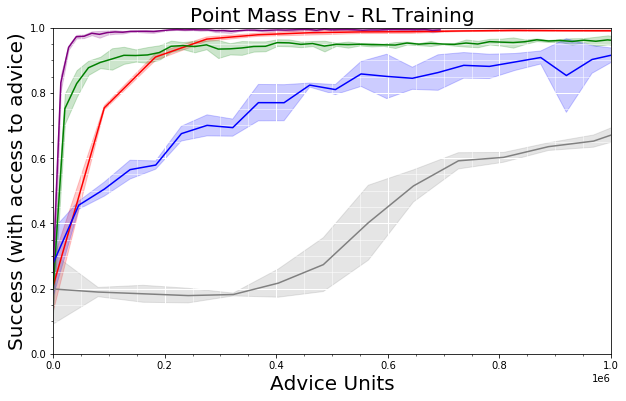

RUN NAMES ['K153', 'K154', 'K155']
LENGTHS [2430, 3091, 2999]
RUN NAMES ['K156', 'K157', 'K158']
LENGTHS [3189, 3220, 3077]
RUN NAMES ['K159']
LENGTHS [3364]
RUN NAMES ['K162', 'K163', 'K164']
LENGTHS [3289, 3356, 3189]
RUN NAMES ['K165', 'K166', 'K167']
LENGTHS [4406, 2873, 2933]


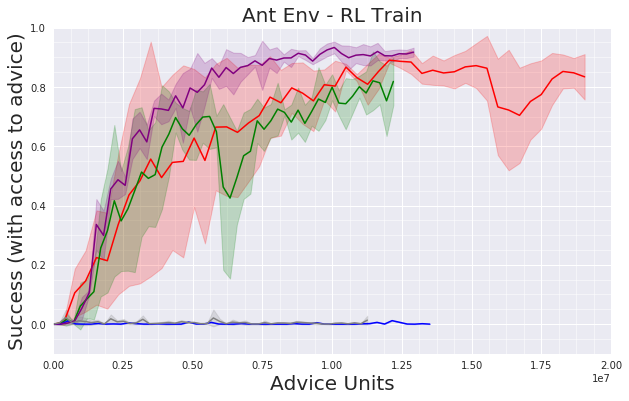

RUN NAMES ['T5443', 'T5505', 'T5458']
No files found with name T5443
RUN NAMES ['T5543', 'T5544', 'T5545']
No files found with name T5543
RUN NAMES ['T5546', 'T5547', 'T5548']
No files found with name T5546
RUN NAMES ['K342', 'K343', 'K344']
LENGTHS [13828, 13250, 14390]


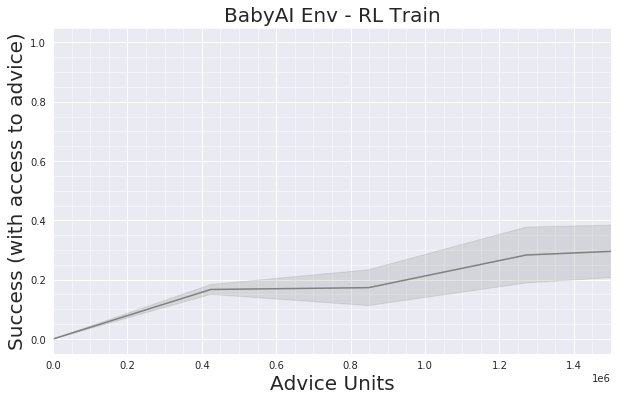

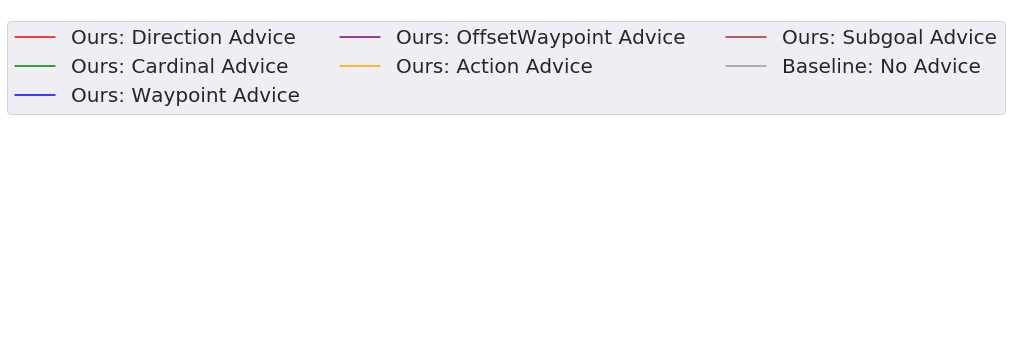

In [4]:
plt.rcParams['figure.figsize'] = [10, 6]
metrics = [
    'Train/Success',
]
x_label = 'feedback'

gray0 = [.75, 0.75, 0.75, 1]
gray1 = [.7, 0.7, 0.7, 1]
gray2 = [.65, 0.65, 0.65, 1]
gray3 = [.6, 0.6, 0.6, 1]
gray4 = [.55, 0.55, 0.55, 1]
gray5 = [.5, 0.5, 0.5, 1]

data_names = [
        (['K000', 'K001', 'K002'], 'Direction Advice', 'red', None),
        (['K003', 'K004', 'K005'], 'Cardinal Advice', 'green', None),
        (['K006', 'K007', 'K008'], 'Waypoint Advice', 'blue', None),
        (['K009', 'K010', 'K011'], 'OffsetWaypoint Advice', 'purple', None),
#         (['K015', 'K016', 'K017'], 'Baseline: No Advice Sparse Reward', 'yellow', '1'),
#         (['K012','K013'], 'Baseline: No Advice - Semi-Sparse Reward', 'orange', 'h'),
        (['K018', 'K019', 'K020'], 'Baseline: No Advice', 'gray', None),
#         (['K348', 'K349', 'K350'], 'Baseline: OffsetWaypoint Advice Reconstruction', gray4, 'D'),
#         (['K345', 'K346', 'K347'], 'Baseline: Direction Advice Reconstruction', gray5, '*'),
    ]

plot_curriculum(data_names, x_label, 
                y=metrics, 
                smooth=20, error_bars=True, 
                title="Point Mass Env - RL Training",
               y_lower=0, y_upper=1, y_label="Success (with access to advice)",
               save_name='rl_train_pm.pdf', x_min=0, x_max=1000000)

data_names = [
        (['K153', 'K154', 'K155'], 'Direction Advice', 'red', None),
        (['K156', 'K157', 'K158'], 'Cardinal Advice', 'green', None),
        ([ 'K159'], 'Waypoint Advice', 'blue', None), # 'K161', 'K160',
        (['K162', 'K163', 'K164'], 'OffsetWaypoint Advice', 'purple', None),
    
        (['K165', 'K166', 'K167'], 'Baseline: No Advice', 'gray', None),
#         (['K375', 'K376', 'K377'], 'Direction Advice Reconstruction', gray5, '*'),
#         (['K378', 'K379', 'K380'], 'OffsetWaypoint Advice Reconstruction', gray4, 'D'),
    ]

plot_curriculum(data_names, x_label, 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Ant Env - RL Train",
               y_lower=-.1, y_upper=1, y_label="Success (with access to advice)",
               save_name='rl_train_ant.pdf', x_max=20000000)

# plot_finetune_generalization(data_names, x_label=inside_x_label,
#                              smooth=40, 
#                              title="Ant Env - RL Train",
#                              y_label=outside_y_label, 
#                              save_name='temp.png', x_max=20000000)


runs = [
#         (['K333_1', 'K334', 'K335'], 'Action Advice', 'orange',None),
#         (['K336', 'K337', 'K338'], 'OffsetWaypoint Advice', 'purple', None),
#         (['K339', 'K340', 'K341'], 'Subgoal Advice', 'brown', None),
    
    
        (['T5443', 'T5505', 'T5458'], 'Action Advice', 'orange',None),
        (['T5543', 'T5544', 'T5545'], 'OffsetWaypoint Advice', 'purple', None),
        (['T5546', 'T5547', 'T5548'], 'Subgoal Advice', 'brown', None),
    
    
        (['K342', 'K343', 'K344'], 'Baseline: No Advice', 'gray', None),
#         (['K381', 'K382', 'K383'], 'Baseline: Subgoal Advice Reconstruction', gray0, None),
    ]


plot_curriculum(runs, x_label, 
                y=metrics, 
                smooth=20, error_bars=True, 
                title="BabyAI Env - RL Train",
               y_lower=-0.05, y_upper=1.05, y_label="Success (with access to advice)", 
                save_name='rl_train_babyai.pdf', x_max=1500000)


# LEGEND
legend = [
    ('Ours: Direction Advice', '.', 'red'),
    ('Ours: Cardinal Advice', ',', 'green'),
    ('Ours: Waypoint Advice', 'o', 'blue'),
    ('Ours: OffsetWaypoint Advice', 'v', 'purple'),
    ('Ours: Action Advice', 's', 'orange'),
    ('Ours: Subgoal Advice', 'P', 'brown'),
    ("Baseline: No Advice", '2', gray3),
#     ("Baseline: Behavioral Cloning", '2', gray3),
#     ("Baseline: No Advice [Hui et al. 2020]", '+', gray3),
#     ("Baseline: No Advice - Sparse Reward [Hui et al. '20]", '1', gray1),
#     ("Baseline: No Advice - Semi-Sparse Reward [Hui et al. '20]", 'h', gray2),
    
#     ("Baseline: OffsetWaypoint Advice Reconstruction [Zhu et al. '20]", 'D', gray4),
#     ("Baseline: Direction Advice Reconstruction [Zhu et al. '20]", '*', gray5),
#     ("Baseline: Subgoal Advice Reconstruction Advice [Zhu et al. '20]", 'x', gray0),

]

lines = []
for legend_name, marker, c in legend:
    legend_line = mlines.Line2D([], [], color=c, marker=None, label=legend_name)
    lines.append(legend_line)
    
plt.box(False)
plt.axis('off')
plt.legend(handles=lines, fontsize=20, ncol=3)
plt.savefig('figs/rl_train_legend.pdf', bbox_inches='tight')
plt.show()
    

In [ ]:
## First plot + more baselines

RUN NAMES ['K000', 'K001', 'K002']
LENGTHS [1120, 1085, 1111]
RUN NAMES ['K003', 'K004', 'K005']
LENGTHS [1186, 1192, 1158]
RUN NAMES ['K006', 'K007', 'K008']
LENGTHS [4186, 4239, 4173]
RUN NAMES ['K009', 'K010', 'K011']
LENGTHS [1112, 1140, 1109]
RUN NAMES ['K015', 'K016', 'K017']
LENGTHS [10470, 10460, 10412]
RUN NAMES ['K012', 'K013']
LENGTHS [5620, 5864]
RUN NAMES ['K018', 'K019', 'K020']
LENGTHS [1043, 1009, 1044]
RUN NAMES ['K348', 'K349', 'K350']
LENGTHS [202, 200, 190]
RUN NAMES ['K345', 'K346', 'K347']
LENGTHS [259, 251, 249]


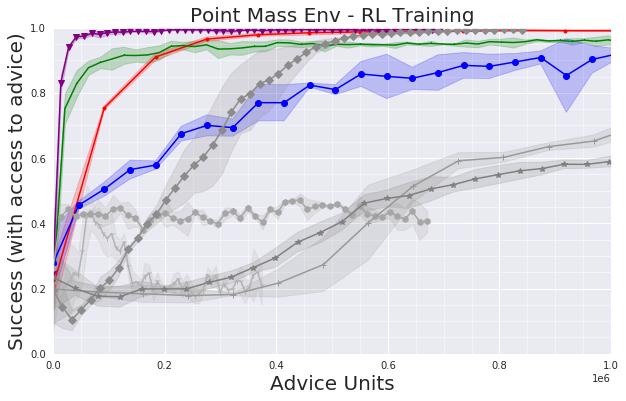

RUN NAMES ['K153', 'K154', 'K155']
LENGTHS [2430, 3091, 2999]
RUN NAMES ['K156', 'K157', 'K158']
LENGTHS [3189, 3220, 3077]
RUN NAMES ['K159', 'K160', 'K161']
LENGTHS [3364, 174, 174]
RUN NAMES ['K162', 'K163', 'K164']
LENGTHS [3289, 3356, 3189]
RUN NAMES ['K165', 'K166', 'K167']
LENGTHS [4406, 2873, 2933]
RUN NAMES ['K375', 'K376', 'K377']
LENGTHS [2631, 2610, 2478]
RUN NAMES ['K378', 'K379', 'K380']
LENGTHS [2564, 2540, 2530]


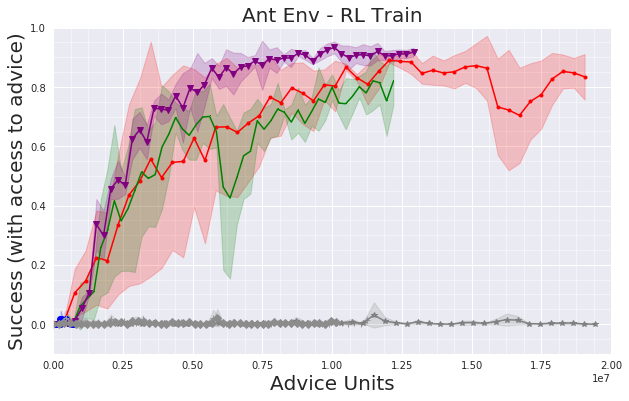

In [5]:
plt.rcParams['figure.figsize'] = [10, 6]
metrics = [
    'Train/Success',
]
x_label = 'feedback'

gray0 = [.75, 0.75, 0.75, 1]
gray1 = [.7, 0.7, 0.7, 1]
gray2 = [.65, 0.65, 0.65, 1]
gray3 = [.6, 0.6, 0.6, 1]
gray4 = [.55, 0.55, 0.55, 1]
gray5 = [.5, 0.5, 0.5, 1]

data_names = [
        (['K000', 'K001', 'K002'], 'Direction Advice', 'red', '.'),
        (['K003', 'K004', 'K005'], 'Cardinal Advice', 'green', ','),
        (['K006', 'K007', 'K008'], 'Waypoint Advice', 'blue', 'o'),
        (['K009', 'K010', 'K011'], 'OffsetWaypoint Advice', 'purple', 'v'),
#         (['K000', 'K001', 'K002'], 'Direction Advice', [0, 0, .5, 1], '.'),
#         (['K003', 'K004', 'K005'], 'Cardinal Advice', [0, 0, .7, 1], ','),
#         (['K006', 'K007', 'K008'], 'Waypoint Advice', [0, 0, 1, 1], 'o'),
#         (['K009', 'K010', 'K011'], 'OffsetWaypoint Advice', [0, 0, 1, 1], 'v'),
        (['K015', 'K016', 'K017'], 'Baseline: No Advice Sparse Reward', gray1, '1'),
        (['K012','K013'], 'Baseline: No Advice - Semi-Sparse Reward', gray2, 'h'),
#         (['K012', 'K013', 'K014'], 'Baseline: No Advice - Semi-Sparse Reward', gray2, 'h'),
        (['K018', 'K019', 'K020'], 'Baseline: No Advice', gray3, '+'),
        (['K348', 'K349', 'K350'], 'Baseline: OffsetWaypoint Advice Reconstruction', gray4, 'D'),
        (['K345', 'K346', 'K347'], 'Baseline: Direction Advice Reconstruction', gray5, '*'),
    ]

plot_curriculum(data_names, x_label, 
                y=metrics, 
                smooth=20, error_bars=True, 
                title="Point Mass Env - RL Training",
               y_lower=0, y_upper=1, y_label="Success (with access to advice)",
               save_name='rl_train_pm.png', x_min=0, x_max=1000000)

data_names = [
        (['K153', 'K154', 'K155'], 'Direction Advice', 'red', '.'),
        (['K156', 'K157', 'K158'], 'Cardinal Advice', 'green', ','),
        (['K159', 'K160', 'K161'], 'Waypoint Advice', 'blue', 'o'),
        (['K162', 'K163', 'K164'], 'OffsetWaypoint Advice', 'purple', 'v'),
    
        (['K165', 'K166', 'K167'], 'No Advice', gray3, '+'),
        (['K375', 'K376', 'K377'], 'Direction Advice Reconstruction', gray5, '*'),
        (['K378', 'K379', 'K380'], 'OffsetWaypoint Advice Reconstruction', gray4, 'D'),
    ]

plot_curriculum(data_names, x_label, 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Ant Env - RL Train",
               y_lower=-.1, y_upper=1, y_label="Success (with access to advice)",
               save_name='rl_train_ant.png', x_max=20000000)

# plot_finetune_generalization(data_names, x_label=inside_x_label,
#                              smooth=40, 
#                              title="Ant Env - RL Train",
#                              y_label=outside_y_label, 
#                              save_name='temp.png', x_max=20000000)


# runs = [
#         (['K333_1', 'K334', 'K335'], 'Action Advice', 'orange', 's'),
#         (['K336', 'K337', 'K338'], 'OffsetWaypoint Advice', 'purple', 'v'),
#         (['K339', 'K340', 'K341'], 'Subgoal Advice', 'brown', 'P'),
#         (['K342', 'K343', 'K344'], 'Baseline: No Advice', gray3, '+'),
#         (['K381', 'K382', 'K383'], 'Baseline: Subgoal Advice Reconstruction', gray0, 'x'),
#     ]


# plot_curriculum(runs, x_label, 
#                 y=metrics, 
#                 smooth=20, error_bars=True, 
#                 title="BabyAI Env - RL Train",
#                y_lower=-0.05, y_upper=1.05, y_label="Success (with access to advice)", 
#                 save_name='rl_train_babyai.png', x_max=4000000)


# # LEGEND
# legend = [
#     ('Ours: Direction Advice', '.', 'red'),
#     ('Ours: Cardinal Advice', ',', 'green'),
#     ('Ours: Waypoint Advice', 'o', 'blue'),
#     ('Ours: OffsetWaypoint Advice', 'v', 'purple'),
#     ('Ours: Action Advice', 's', 'orange'),
#     ('Ours: Subgoal Advice', 'P', 'brown'),
#     ("Baseline: Imitation Learning", '2', gray3),
#     ("Baseline: No Advice [Hui et al. 2020]", '+', gray3),
#     ("Baseline: No Advice - Sparse Reward [Hui et al. '20]", '1', gray1),
#     ("Baseline: No Advice - Semi-Sparse Reward [Hui et al. '20]", 'h', gray2),
    
#     ("Baseline: OffsetWaypoint Advice Reconstruction [Zhu et al. '20]", 'D', gray4),
#     ("Baseline: Direction Advice Reconstruction [Zhu et al. '20]", '*', gray5),
#     ("Baseline: Subgoal Advice Reconstruction Advice [Zhu et al. '20]", 'x', gray0),

# ]

# lines = []
# for legend_name, marker, c in legend:
#     legend_line = mlines.Line2D([], [], color=c, marker=marker, label=legend_name)
#     lines.append(legend_line)
    
# plt.box(False)
# plt.axis('off')
# plt.legend(handles=lines, fontsize=20, ncol=3)
# plt.savefig('figs/rl_train_legend.png', bbox_inches='tight')
# plt.show()
    

# Second PLOT

In [ ]:
plt.rcParams['figure.figsize'] = [3, 2]
metrics = [
    'Train/Success',
]
x_label = 'Advice Units'

outside_y_label = "Success Rate"
inside_y_label = ""
inside_x_label = ""
outside_x_label = "Advice Units"

runs = [
        (['K000', 'K001', 'K002'], 'RL training'),
        (['K144', 'K145', 'K146'], 'Distillation', 1, '#ff7f0e', None),
    ]

plt.xlim(0, 1000000)
plot_finetune_generalization(runs, 'Direction (PM)', smooth=10, x_label=inside_x_label, 
                             y_label=outside_y_label, x_max=1000000, save_name='bootstrap_direction_pm.pdf')



runs = [
        (['K003', 'K004', 'K005'], 'RL training'),
        (['K147', 'K148', 'K149'], 'Distillation', 1, '#ff7f0e', None),
    ]

plt.xlim(0, 250000)
plot_finetune_generalization(runs, 'Cardinal (PM)', smooth=10, x_label=inside_x_label, 
                             y_label=inside_y_label, x_max=250000, save_name='bootstrap_cardinal_pm.pdf')


runs = [
        (['K006', 'K007', 'K008'], 'RL training'),
        (['K150', 'K151', 'K152'], 'Distillation', 1, '#ff7f0e', None),
    ]

plt.xlim(0, 250000)
plot_finetune_generalization(runs, 'Waypoint (PM)', smooth=10, x_label=inside_x_label, 
                             y_label=inside_y_label, x_max=250000, save_name='bootstrap_waypoint_pm.pdf')




runs = [
        (['K153', 'K154', 'K155'], 'RL train - Direction Hints'),
        (['K168', 'K169', 'K170'], 'Off -> Dir', 1, '#ff7f0e', None),
]
plt.xlim(0, 1500000)
add_line(.92, 'RL Train at convergence (1.25e7)')
plot_finetune_generalization(runs, 'Direction (Ant)', smooth=10, 
                             x_label=inside_x_label, y_label=inside_y_label,
                            y_min=-0.1, save_name='bootstrap_direction_ant.pdf',
                            x_max=1500000)


runs = [
        (['K156', 'K157', 'K158'], 'RL train - Cardinal Hints'),
        (['K171', 'K172', 'K173'], 'Off -> Cardinal', 1, '#ff7f0e', None),
]
add_line(.84, 'RL Train at convergence (1.2e7)')
plt.xlim(0, 50000)
plot_finetune_generalization(runs, 'Cardinal (Ant)', smooth=10, 
                             x_label=outside_x_label, y_label=outside_y_label,
                            y_min=-0.1, save_name='bootstrap_cardinal_ant.pdf',
                            x_max=50000)

runs = [
        (['K159', 'K160', 'K161'], 'RL train - Waypoint Hints'),
        (['K174b', 'K175b', 'K176b'], 'Off -> Waypoint', 1, '#ff7f0e', None),
]
plt.xlim(0, 100000)
add_line(.02, 'RL Train at convergence (1e7)')
plot_finetune_generalization(runs, 'Waypoint (Ant)', smooth=10, 
                             x_label=outside_x_label, y_label=inside_y_label,
                            y_min=-0.1, save_name='bootstrap_waypoint_ant.pdf',
                            x_max=100000)



# runs = [
#         (['K333_1', 'K334', 'K335'], 'Action Advice', 'orange', 's'),
#         (['K336', 'K337', 'K338'], 'OffsetWaypoint Advice', 'purple', 'v'),
#         (['K339', 'K340', 'K341'], 'Subgoal Advice', 'brown', 'P'),



x_label = 'Advice Units'

runs = [
        (['K336', 'K337', 'K338'], 'RL Training'),
        (['K249b', 'K250b', 'K251b'], 'Distillation', 1, '#ff7f0e', None),
    ]

plt.xlim(0, 1000000)
plot_finetune_generalization(runs, 'OffsetWaypoint (babyai)', smooth=3, x_label=outside_x_label, 
                             metric='success_rate', y_label=inside_y_label, 
                             save_name='bootstrap_waypoint_babyai.pdf', x_max=1000000)


runs = [
        (['K339', 'K340', 'K341'], 'RL Training'),
        (['K252c', 'K253c', 'K254c'], 'Bootstrapping', 1, '#ff7f0e', None),
    ]

plt.xlim(0, 1000000)
plot_finetune_generalization(runs, 'Subgoal (babyai)', smooth=3, x_label=outside_x_label, 
                             metric='success_rate', 
                             y_label=inside_y_label, save_name='bootstrap_subgoal_babyai.pdf')


lines = [mlines.Line2D([], [], label='RL Training'),
         mlines.Line2D([], [], c='orange', label='Distillation')]
plt.box(False)
plt.axis('off')
plt.legend(handles=lines, fontsize=20, ncol=2)
plt.savefig('figs/bootstrap_legend.pdf', bbox_inches='tight')
plt.show()

# #         plt.box(False)
#         for x_data, y_data, y_std_data in zip(x_list, y_list, y_std_list):
# #             print("MAX", np.max(y_transform(y_data)))
#             plt.plot(x_data, y_transform(y_data))
#             plt.fill_between(x_data, y_data - y_std_data, y_data + y_std_data, alpha=0.2)
#             plt.xlim(-10, 0)
#             plt.ylim(-2, -1)
#             plt.legend(policy_list, fontsize=20)
#         plt.box(False)
#         plt.axis('off')
#         if save_name is not None:
#             plt.savefig('figs/legend_' + save_name)
#         plt.show()


In [ ]:
plt.rcParams['figure.figsize'] = [9, 6]
metrics = [
    'Train/Success',
]
x_label = 'Advice Units'

outside_y_label = "Success Rate"
inside_y_label = ""
inside_x_label = ""
outside_x_label = "Advice Units"

runs = [
        (['K000', 'K001', 'K002'], 'RL training'),
        (['K144', 'K145', 'K146'], 'Distillation', 1, '#ff7f0e', None),
    ]

# plt.xlim(0, 1000000)
plot_finetune_generalization(runs, 'Direction (PM)', smooth=10, x_label=inside_x_label, 
                             y_label=outside_y_label, save_name='bootstrap_direction_pm.png')



runs = [
        (['K003', 'K004', 'K005'], 'RL training'),
        (['K147', 'K148', 'K149'], 'Distillation', 1, '#ff7f0e', None),
    ]

# plt.xlim(0, 250000)
plot_finetune_generalization(runs, 'Cardinal (PM)', smooth=10, x_label=inside_x_label, 
                             y_label=inside_y_label, save_name='bootstrap_cardinal_pm.png')


runs = [
        (['K006', 'K007', 'K008'], 'RL training'),
        (['K150', 'K151', 'K152'], 'Distillation', 1, '#ff7f0e', None),
    ]

# plt.xlim(0, 250000)
plot_finetune_generalization(runs, 'Waypoint (PM)', smooth=10, x_label=inside_x_label, 
                             y_label=inside_y_label, save_name='bootstrap_waypoint_pm.png')




runs = [
        (['K153', 'K154', 'K155'], 'RL train - Direction Hints'),
        (['K168', 'K169', 'K170'], 'Off -> Dir', 1, '#ff7f0e', None),
]
# plt.xlim(0, 1500000)
add_line(.92, 'RL Train at convergence (1.25e7)')
plot_finetune_generalization(runs, 'Direction (Ant)', smooth=10, 
                             x_label=inside_x_label, y_label=inside_y_label,
                            y_min=-0.1, save_name='bootstrap_direction_ant.png')


runs = [
        (['K156', 'K157', 'K158'], 'RL train - Cardinal Hints'),
        (['K171', 'K172', 'K173'], 'Off -> Cardinal', 1, '#ff7f0e', None),
]
add_line(.84, 'RL Train at convergence (1.2e7)')
# plt.xlim(0, 50000)
plot_finetune_generalization(runs, 'Cardinal (Ant)', smooth=10, 
                             x_label=outside_x_label, y_label=outside_y_label,
                            y_min=-0.1, save_name='bootstrap_cardinal_ant.png')

runs = [
        (['K159', 'K160', 'K161'], 'RL train - Waypoint Hints'),
        (['K174b', 'K175b', 'K176b'], 'Off -> Waypoint', 1, '#ff7f0e', None),
]
# plt.xlim(0, 100000)
add_line(.02, 'RL Train at convergence (1e7)')
plot_finetune_generalization(runs, 'Waypoint (Ant)', smooth=10, 
                             x_label=outside_x_label, y_label=inside_y_label,
                            y_min=-0.1, save_name='bootstrap_waypoint_ant.png')



# runs = [
#         (['K333_1', 'K334', 'K335'], 'Action Advice', 'orange', 's'),
#         (['K336', 'K337', 'K338'], 'OffsetWaypoint Advice', 'purple', 'v'),
#         (['K339', 'K340', 'K341'], 'Subgoal Advice', 'brown', 'P'),



x_label = 'Advice Units'

runs = [
        (['K336', 'K337', 'K338'], 'RL Training'),
        (['K249b', 'K250b', 'K251b'], 'Distillation', 1, '#ff7f0e', None),
    ]

# plt.xlim(0, 1000000)
plot_finetune_generalization(runs, 'OffsetWaypoint (babyai)', smooth=3, x_label=outside_x_label, 
                             metric='success_rate', y_label=inside_y_label, 
                             save_name='bootstrap_waypoint_babyai.png')


runs = [
        (['K339', 'K340', 'K341'], 'RL Training'),
        (['K252c', 'K253c', 'K254c'], 'Bootstrapping', 1, '#ff7f0e', None),
    ]

# plt.xlim(0, 1000000)
plot_finetune_generalization(runs, 'Subgoal (babyai)', smooth=3, x_label=outside_x_label, 
                             metric='success_rate', 
                             y_label=inside_y_label, save_name='bootstrap_subgoal_babyai.png')


lines = [mlines.Line2D([], [], label='RL Training'),
         mlines.Line2D([], [], c='orange', label='Distillation')]
plt.box(False)
plt.axis('off')
plt.legend(handles=lines, fontsize=20, ncol=2)
plt.savefig('figs/bootstrap_legend.png', bbox_inches='tight')
plt.show()

# #         plt.box(False)
#         for x_data, y_data, y_std_data in zip(x_list, y_list, y_std_list):
# #             print("MAX", np.max(y_transform(y_data)))
#             plt.plot(x_data, y_transform(y_data))
#             plt.fill_between(x_data, y_data - y_std_data, y_data + y_std_data, alpha=0.2)
#             plt.xlim(-10, 0)
#             plt.ylim(-2, -1)
#             plt.legend(policy_list, fontsize=20)
#         plt.box(False)
#         plt.axis('off')
#         if save_name is not None:
#             plt.savefig('figs/legend_' + save_name)
#         plt.show()


# THIRD PLOT

In [ ]:
# L0
# TODO: REDO ANT TRAIN RUNS
runs = [
    (['K191'], 'RL No hints', 1, gray3, None),
]
plot_finetune_generalization(runs, 'Ant Env (Larger Maze)', metric=metric, smooth=10, x_label='Advice Units', 
                             y_label=y_label, y_min=-.05, save_name='distill_ant_l0.pdf', x_max=1000000)



In [ ]:
plt.rcParams['figure.figsize'] = [10, 6]

y_label = 'Success Rate of Agent w/o Advice'
metric = 'success_rate'

# L3
runs = [
    (['K069', 'K070', 'K071'], 'Distill - Direction Advice', 1, 'red', None),
    (['K072', 'K073', 'K074'], 'Distill - Cardinal Advice', 1, 'green', None),
    (['K075', 'K076', 'K077'], 'Distill - Waypoint Advice', 1, 'blue', None),
    (['K078', 'K079', 'K080'], 'Distill - OffsetWaypoint Advice', 1, 'purple', None),
    (['K090', 'K091', 'K092'], 'Distill - Demonstrations', 1, 'darkgoldenrod', None),
    (['K087', 'K088', 'K089'], 'RL Finetune - Dense reward)', 1, 'gray', None),
#     (['K081', 'K082', 'K083'], 'RL Finetune - Semi-sparse reward', 1, gray2, None),
]
plt.xlim(0, 1000000)
plot_finetune_generalization(runs, 'Point Mass Env (Larger Maze)', smooth=10, 
                             x_label='Advice Units', y_label=y_label,
                            y_min=0.4, y_max=1, save_name='distill_pm_l3.pdf', x_max=1000000)



# L0
runs = [
    (['K315', 'K316', 'K317'], 'Distill - Direction Advice', 1, 'red', None),
    (['K180', 'K181', 'K182'], 'Distill - Cardinal Advice', 1, 'green', None),
    (['K318', 'K319', 'K320'], 'Distill - OffsetWaypoint Advice', 1, 'purple', None),
    (['K189', 'K190', 'K191'], 'RL No hints', 1, gray3, None),
]
plt.xlim(0, 1000000)
add_line(.94, 'RL baseline at convergence (5.5e6)', color=gray3)
plot_finetune_generalization(runs, 'Ant Env (Larger Maze)', metric=metric, smooth=1, x_label='Advice Units', 
                             y_label=y_label, y_min=-.05, save_name='distill_ant_l0.pdf', x_max=1000000)




# L30
runs = [
    (['K426', 'K427', 'K428'], 'Distill - Action Advice', 1, 'orange', None),
    (['K429', 'K430', 'K431'], 'Distill - OffsetWaypoint Advice', 1, 'purple', None),
    (['K432', 'K433', 'K434'], 'Distill - Subgoal Advice', 1, 'brown', None),
    (['K435', 'K436', 'K437'], 'RL Finetune', 1, gray3, None),
]
plt.xlim(0, 10000)
plot_finetune_generalization(runs, 'BabyAI Env (New Task)', smooth=1, 
                             x_label='Advice Units', y_label=y_label,
                            y_min=-.05, y_max=1.05, save_name='distill_babyai_l30.pdf', x_max=10000)


# LEGEND
legend = [
    ('Ours: Direction Advice', None, 'red'),
    ('Ours: Cardinal Advice',None, 'green'),
    ('Ours: Waypoint Advice', None, 'blue'),
    ('Ours: OffsetWaypoint Advice', None, 'purple'),
    ('Ours: Action Advice', None, 'orange'),
    ('Ours: Subgoal Advice', None, 'brown'),
    ("Baseline: Behavioral Cloning", None, 'darkgoldenrod'),
    ("Baseline: Shaped-Reward RL", None, 'gray'),
#     ("Baseline: No Advice [Hui et al. 2020]", None, gray3),
#     ("Baseline: No Advice - Semi-Sparse Reward [Hui et al. '20]", None, gray2),
]

lines = []
for legend_name, marker, c in legend:
    legend_line = mlines.Line2D([], [], color=c, marker=marker, label=legend_name)
    lines.append(legend_line)
    
plt.box(False)
plt.axis('off')
plt.legend(handles=lines, fontsize=20, ncol=3)
plt.savefig('figs/distill_legend.pdf', bbox_inches='tight')
plt.show()


In [ ]:
# L2
runs = [
    (['K045', 'K046', 'K047'], 'Distill - Direction Advice', 1, 'red', None),
    (['K048', 'K049', 'K050'], 'Distill - Cardinal Advice', 1, 'green', None),
    (['K051', 'K052', 'K053'], 'Distill - Waypoint Advice', 1, 'blue', None),
    (['K054', 'K055', 'K056'], 'Distill - OffsetWaypoint Advice', 1, 'purple', None),
    (['K066', 'K067', 'K068'], 'Distill - Demonstrations', 1, 'darkgoldenrod', None),
#     (['T3916'], 'RL Finetune (waypoint reward from scratch)', 1),
#     (['K060', 'K061', 'K062'], 'RL Finetune (sparse reward)', 1),
    (['K063', 'K064', 'K065'], 'RL Finetune - Dense Reward', 1, 'gray', None),
#     (['K057', 'K058', 'K059'], 'RL Finetune - Semi-Sparse Reward', 1, gray2, None),
#     (['K351', 'K352', 'K353'], 'RL Finetune - Dense Reward + Direction Advice Reconstruction', 1),
#     (['K354', 'K355', 'K356'], 'RL Finetune - Dense Reward + OffsetWaypoint Advice Reconstruction', 1),
]

plot_finetune_generalization(runs, 'Point Mass Env - Test Env 2', smooth=10, 
                             x_label='Advice Units', y_label=y_label,
                            y_min=0.5, y_max=1, save_name='distill_pm_l2.pdf',
                            x_min=0, x_max=1000000)


# L13
runs = [
    (['K093', 'K094', 'K095'], 'Distill - Direction Advice', 1, 'red', None),
    (['K096', 'K097', 'K098'], 'Distill - Cardinal Advice', 1, 'green', None),
    (['K099', 'K100', 'K101'], 'Distill - Waypoint Advice', 1, 'blue', None),
    (['K102', 'K103', 'K104'], 'Distill - OffsetWaypoint Advice', 1, 'purple', None),
    (['K114', 'K115', 'K116'], 'Distill - Demonstrations', 1, 'darkgoldenrod', None),
#     (['K105', 'K106', 'K107'], 'RL Finetune (waypoint reward)', 1),
#     (['K108', 'K109', 'K110'], 'RL Finetune (sparse reward)', 1),
    (['K111', 'K112', 'K113'], 'RL Finetune - Dense Reward', 1, 'gray', None),
#     (['K363', 'K364', 'K365'], 'RL Finetune - Dense Reward + Direction Advice Reconstruction', 1),
#     (['K366', 'K367', 'K368'], 'RL Finetune - Dense Reward + OffsetWaypoint Advice Reconstruction', 1),
]
# plt.xlim(0, 1000000)
plot_finetune_generalization(runs, 'Test Env 3', smooth=10, 
                             x_label='Advice Units', y_label=y_label,
                            y_min=0, y_max=1, save_name='distill_pm_l13.pdf', x_max=1000000)


# L14
runs = [
    (['K117', 'K118', 'K119'], 'Distill - Direction Advice', 1, 'red', None),
#     (['K120', 'K121', 'K122'], 'Distill from Cardinal', 1),
    (['K141', 'K142', 'K143'], 'Distill - Cardinal Advice', 1, 'green', None),
    (['K123', 'K124', 'K125'], 'Distill - Waypoint Advice', 1, 'blue', None),
    (['K126', 'K127', 'K128'], 'Distill - OffsetWaypoint Advice', 1, 'purple', None),
    (['K138', 'K139', 'K140'], 'Distill - Demonstrations', 1, 'darkgoldenrod', None),
#     (['K129', 'K130', 'K131'], 'RL Finetune (waypoint reward)', 1),
#     (['K132', 'K133', 'K134'], 'RL Finetune (sparse reward)', 1),
    (['K135', 'K136', 'K137'], 'RL Finetune - Dense Reward', 1, 'gray', None),
#     (['K369', 'K370', 'K371'], 'RL Finetune - Dense Reward + Direction Advice Reconstruction', 1),
#     (['K372', 'K373', 'K374'], 'RL Finetune - Dense Reward + OffsetWaypoint Advice Reconstruction', 1),
]
# plt.xlim(0, 1000000)
plot_finetune_generalization(runs, 'Test Env 4', smooth=10, 
                             x_label='Advice Units', y_label=y_label,
                            y_min=0, y_max=1, save_name='distill_pm_l14.pdf', x_max=1000000)




# L2
runs = [
#     (['K207', 'K208', 'K209'], 'Distill Direction', 1),
#     (['K208'], 'Distill Direction', 1),
#     (['K321', 'K322'], 'Distill Direction (finetune)', 1),
    (['K321', 'K322', 'K323'], 'Distill - Direction Advice', 1, 'red', None),
    (['K210', 'K211', 'K212'], 'Distill - Cardinal Advice', 1, 'green', None),
#     (['K213', 'K214', 'K215'], 'Distill - Waypoint Advice', 1, 'blue', 'o'),
#     (['K216', 'K217', 'K218'], 'Distill OffsetWaypoint', 1),
#     (['K216', 'K217'], 'Distill OffsetWaypoint', 1),
    (['K324', 'K325', 'K326'], 'Distill - OffsetWaypoint Advice', 1, 'purple', None),
    (['K219', 'K220', 'K221'], 'RL No hints', 1, 'gray', None),
]
# plt.xlim(0, 150000)
add_line(.33, 'RL Train w/o hints at (3e6)', color='gray')
plot_finetune_generalization(runs, 'Test Env 2', metric=metric, smooth=10, x_label='Feedback', 
                             y_label=y_label, y_min=-.05, save_name='distill_ant_l2.pdf', x_max=150000)

# L3
runs = [
    (['K222', 'K223', 'K224'], 'Distill - Direction Advice', 1, 'red', None),
    (['K225', 'K226', 'K227'], 'Distill - Cardinal Advice', 1, 'green', None),
#     (['K228', 'K229', 'K230'], 'Distill - Waypoint Advice', 1, 'blue', 'o'),
#     (['K231', 'K232', 'K233'], 'Distill OffsetWaypoint', 1),
    (['K330', 'K331', 'K332'], 'Distill - OffsetWaypoint Advice', 1, 'purple', None),
    (['K234', 'K235', 'K236'], 'RL No hints', 1, 'gray', None),
]
# plt.xlim(0, 200000)
add_line(.16, 'RL Train at (2e6)', color='gray')
plot_finetune_generalization(runs, 'Test Env 3', metric=metric, smooth=10, 
                             x_label='Feedback', y_label=y_label, y_min=-.1, y_max=.4, 
                             save_name='distill_ant_l3.pdf', x_max=200000)


In [ ]:
plt.rcParams['figure.figsize'] = [10, 6]

y_label = 'Success Rate of Agent w/o Advice'

# L3
runs = [
    (['K069', 'K070', 'K071'], 'Distill - Direction Advice', 1, 'red', '.'),
    (['K072', 'K073', 'K074'], 'Distill - Cardinal Advice', 1, 'green', ','),
    (['K075', 'K076', 'K077'], 'Distill - Waypoint Advice', 1, 'blue', 'o'),
    (['K078', 'K079', 'K080'], 'Distill - OffsetWaypoint Advice', 1, 'purple', 'v'),
#     (['K090', 'K091', 'K092'], 'Distill - Demonstrations', 1, gray3, '2'),
    (['K087', 'K088', 'K089'], 'RL Finetune - Dense reward)', 1, gray3, '+'),
#     (['K081', 'K082', 'K083'], 'RL Finetune - Semi-sparse reward', 1, gray2, 'h'),
]
# plt.xlim(0, 1000000)
plot_finetune_generalization(runs, 'Point Mass Env (Larger Maze)', smooth=10, 
                             x_label='Advice Units', y_label=y_label,
                            y_min=0.4, y_max=1, save_name='distill_pm_l3.png')



# L0
runs = [
    (['K315', 'K316', 'K317'], 'Distill - Direction Advice', 1, 'red', '.'),
    (['K180', 'K181', 'K182'], 'Distill - Cardinal Advice', 1, 'green', ','),
    (['K318', 'K319', 'K320'], 'Distill - OffsetWaypoint Advice', 1, 'purple', 'v'),
    (['K189', 'K190', 'K191'], 'RL No hints', 1, gray3, '+'),
]
# plt.xlim(0, 1000000)
add_line(.94, 'RL Train at (5.5e6)', color=gray3)
plot_finetune_generalization(runs, 'Ant Env (Larger Maze)', metric=metric, smooth=10, x_label='Advice Units', 
                             y_label=y_label, y_min=-.05, save_name='distill_ant_l0.png')




# L30
runs = [
    (['K426', 'K427', 'K428'], 'Distill - Action Advice', 1, 'orange', 's'),
    (['K429', 'K430', 'K431'], 'Distill - OffsetWaypoint Advice', 1, 'purple', 'v'),
    (['K432', 'K433', 'K434'], 'Distill - Subgoal Advice', 1, 'brown', 'P'),
    (['K435', 'K436', 'K437'], 'RL Finetune', 1, gray3, '+'),
]
# plt.xlim(0, 10000)
plot_finetune_generalization(runs, 'BabyAI Env (New Task)', smooth=1, 
                             x_label='Advice Units', y_label=y_label,
                            y_min=-.05, y_max=1.05, save_name='distill_babyai_l30.png')


# LEGEND
legend = [
    ('Ours: Direction Advice', '.', 'red'),
    ('Ours: Cardinal Advice', ',', 'green'),
    ('Ours: Waypoint Advice', 'o', 'blue'),
    ('Ours: OffsetWaypoint Advice', 'v', 'purple'),
    ('Ours: Action Advice', 's', 'orange'),
    ('Ours: Subgoal Advice', 'P', 'brown'),
    ("Baseline: Imitation Learning", '2', gray3),
    ("Baseline: No Advice [Hui et al. 2020]", '+', gray3),
    ("Baseline: No Advice - Semi-Sparse Reward [Hui et al. '20]", 'h', gray2),
]

lines = []
for legend_name, marker, c in legend:
    legend_line = mlines.Line2D([], [], color=c, marker=marker, label=legend_name)
    lines.append(legend_line)
    
plt.box(False)
plt.axis('off')
plt.legend(handles=lines, fontsize=20, ncol=3)
plt.savefig('figs/distill_legend.png', bbox_inches='tight')
plt.show()


# Sample Plots

In [ ]:
plt.rcParams['figure.figsize'] = [10, 6]
metrics = [
    'Train/Success',
]
x_label = 'samples'

metrics = [
    'Train/Success',
]

outside_y_label = "Success Rate"
inside_y_label = ""
inside_x_label = ""
outside_x_label = "Samples"



gray0 = [.75, 0.75, 0.75, 1]
gray1 = [.7, 0.7, 0.7, 1]
gray2 = [.65, 0.65, 0.65, 1]
gray3 = [.6, 0.6, 0.6, 1]
gray4 = [.55, 0.55, 0.55, 1]
gray5 = [.5, 0.5, 0.5, 1]

data_names = [
        (['K000', 'K001', 'K002'], 'Direction Advice', 'red', None),
        (['K003', 'K004', 'K005'], 'Cardinal Advice', 'green', None),
        (['K006', 'K007', 'K008'], 'Waypoint Advice', 'blue', None),
        (['K009', 'K010', 'K011'], 'OffsetWaypoint Advice', 'purple', None),
#         (['K015', 'K016', 'K017'], 'Baseline: No Advice Sparse Reward', 'yellow', '1'),
        (['K018', 'K019', 'K020'], 'Baseline: No Advice', 'gray', None),
#         (['K348', 'K349', 'K350'], 'Baseline: OffsetWaypoint Advice Reconstruction', 'black', None),
#         (['K345', 'K346', 'K347'], 'Baseline: Direction Advice Reconstruction', gray5, None),
    ]

plot_curriculum(data_names, x_label, 
                y=metrics, 
                smooth=20, error_bars=True, 
                title="Point Mass Env - RL Training",
               y_lower=0, y_upper=1, y_label="Success (with access to advice)",
               save_name='rl_train_pm_samples.pdf', x_min=0, x_max=1000)

data_names = [
        (['K153', 'K154', 'K155'], 'Direction Advice', 'red', None),
        (['K156', 'K157', 'K158'], 'Cardinal Advice', 'green', None),
        (['K159', ], 'Waypoint Advice', 'blue', None),#'K160', 'K161'
        (['K162', 'K163', 'K164'], 'OffsetWaypoint Advice', 'purple', None),
    
        (['K165', 'K166', 'K167'], 'No Advice', 'gray', None),
#         (['K375', 'K376', 'K377'], 'Direction Advice Reconstruction', gray5, None),
#         (['K378', 'K379', 'K380'], 'OffsetWaypoint Advice Reconstruction', gray4, None),
    ]

plot_curriculum(data_names, x_label, 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Ant Env - RL Train",
               y_lower=-.1, y_upper=1, y_label="Success (with access to advice)",
               save_name='rl_train_ant_samples.pdf', x_max=None)


runs = [
        (['K333_1', 'K334', 'K335'], 'Action Advice', 'orange', None),
        (['K336', 'K337', 'K338'], 'OffsetWaypoint Advice', 'purple', None),
        (['K339', 'K340', 'K341'], 'Subgoal Advice', 'brown', None),
        (['K342', 'K343', 'K344'], 'Baseline: No Advice', gray3, None),
#         (['K381', 'K382', 'K383'], 'Baseline: Subgoal Advice Reconstruction', gray0, None),
    ]


plot_curriculum(runs, x_label, 
                y=metrics, 
                smooth=20, error_bars=True, 
                title="BabyAI Env - RL Train",
               y_lower=-0.05, y_upper=1.05, y_label="Success (with access to advice)", 
                save_name='rl_train_babyai_samples.pdf', x_max=None)


# LEGEND
legend = [
    ('Ours: Direction Advice', None, 'red'),
    ('Ours: Cardinal Advice', None, 'green'),
    ('Ours: Waypoint Advice', None, 'blue'),
    ('Ours: OffsetWaypoint Advice', None, 'purple'),
    ('Ours: Action Advice', None, 'orange'),
    ('Ours: Subgoal Advice', None, 'brown'),
#     ("Baseline: Imitation Learning", None, 'darkgoldenrod'),
    ("Baseline: No Advice", None, 'gray'),
#     ("Baseline: No Advice - Sparse Reward [Hui et al. '20]", '1', gray1),
#     ("Baseline: No Advice - Semi-Sparse Reward [Hui et al. '20]", 'h', gray2),
    
#     ("Baseline: OffsetWaypoint Advice Reconstruction [Zhu et al. '20]", 'D', gray4),
#     ("Baseline: Direction Advice Reconstruction [Zhu et al. '20]", '*', gray5),
#     ("Baseline: Subgoal Advice Reconstruction Advice [Zhu et al. '20]", 'x', gray0),

]

lines = []
for legend_name, marker, c in legend:
    legend_line = mlines.Line2D([], [], color=c, marker=marker, label=legend_name)
    lines.append(legend_line)
    
plt.box(False)
plt.axis('off')
plt.legend(handles=lines, fontsize=20, ncol=3)
plt.savefig('figs/rl_train_legend.pdf', bbox_inches='tight')
plt.show()
    

In [ ]:
plt.rcParams['figure.figsize'] = [3, 2]
metrics = [
    'Train/Success',
]
x_label = 'Samples'

outside_y_label = "Success Rate"
inside_y_label = ""
inside_x_label = ""
outside_x_label = "Samples"

frames_per_proc = 200
num_envs = 20
samples_per_itr = frames_per_proc * num_envs


runs = [
        (['K000', 'K001', 'K002'], 'RL training', samples_per_itr),
        (['K144', 'K145', 'K146'], 'Distillation', samples_per_itr, '#ff7f0e', None),
    ]

# plt.xlim(0, 1000000)
plot_finetune_generalization(runs, 'Direction (PM)', smooth=10, x_label=inside_x_label, 
                             y_label=outside_y_label, x_max=2e6 * samples_per_itr, save_name='bootstrap_direction_pm_samples.png')



runs = [
        (['K003', 'K004', 'K005'], 'RL training', samples_per_itr),
        (['K147', 'K148', 'K149'], 'Distillation', samples_per_itr, '#ff7f0e', None),
    ]

# plt.xlim(0, 250000)
plot_finetune_generalization(runs, 'Cardinal (PM)', smooth=10, x_label=inside_x_label, 
                             y_label=inside_y_label, x_max=0.5e6 * samples_per_itr, save_name='bootstrap_cardinal_pm_samples.png')


runs = [
        (['K006', 'K007', 'K008'], 'RL training', samples_per_itr),
        (['K150', 'K151', 'K152'], 'Distillation', samples_per_itr, '#ff7f0e', None),
    ]

# plt.xlim(0, 250000)
plot_finetune_generalization(runs, 'Waypoint (PM)', smooth=10, x_label=inside_x_label, 
                             y_label=inside_y_label, x_max=None, save_name='bootstrap_waypoint_pm_samples.png')




runs = [
        (['K153', 'K154', 'K155'], 'RL train - Direction Hints', samples_per_itr),
        (['K168', 'K169', 'K170'], 'Off -> Dir', samples_per_itr, '#ff7f0e', None),
]
# plt.xlim(0, 1500000)
add_line(.92, 'RL Train at convergence (1.25e7)')
plot_finetune_generalization(runs, 'Direction (Ant)', smooth=10, 
                             x_label=inside_x_label, y_label=inside_y_label,
                            y_min=-0.1, save_name='bootstrap_direction_ant_samples.png',
                            x_max=None)


runs = [
        (['K156', 'K157', 'K158'], 'RL train - Cardinal Hints', samples_per_itr),
        (['K171', 'K172', 'K173'], 'Off -> Cardinal', samples_per_itr, '#ff7f0e', None),
]
add_line(.84, 'RL Train at convergence (1.2e7)')
# plt.xlim(0, 50000)
plot_finetune_generalization(runs, 'Cardinal (Ant)', smooth=10, 
                             x_label=outside_x_label, y_label=outside_y_label,
                            y_min=-0.1, save_name='bootstrap_cardinal_ant_samples.png',
                            x_max=None)

runs = [
        (['K159', 'K160', 'K161'], 'RL train - Waypoint Hints', samples_per_itr),
        (['K174b', 'K175b', 'K176b'], 'Off -> Waypoint', samples_per_itr, '#ff7f0e', None),
]
# plt.xlim(0, 100000)
add_line(.02, 'RL Train at convergence (1e7)')
plot_finetune_generalization(runs, 'Waypoint (Ant)', smooth=10, 
                             x_label=outside_x_label, y_label=inside_y_label,
                            y_min=-0.1, save_name='bootstrap_waypoint_ant_samples.png',
                            x_max=1e6 * samples_per_itr)



# runs = [
#         (['K333_1', 'K334', 'K335'], 'Action Advice', 'orange', 's'),
#         (['K336', 'K337', 'K338'], 'OffsetWaypoint Advice', 'purple', 'v'),
#         (['K339', 'K340', 'K341'], 'Subgoal Advice', 'brown', 'P'),



x_label = 'Advice Units'

runs = [
        (['K336', 'K337', 'K338'], 'RL Training', samples_per_itr),
        (['K249b', 'K250b', 'K251b'], 'Distillation', samples_per_itr, '#ff7f0e', None),
    ]

# plt.xlim(0, 1000000)
plot_finetune_generalization(runs, 'OffsetWaypoint (babyai)', smooth=3, x_label=outside_x_label, 
                             metric='success_rate', y_label=inside_y_label, 
                             save_name='bootstrap_waypoint_babyai_samples.png', x_max=None)


runs = [
        (['K339', 'K340', 'K341'], 'RL Training', samples_per_itr),
        (['K252c', 'K253c', 'K254c'], 'Bootstrapping', samples_per_itr, '#ff7f0e', None),
    ]

# plt.xlim(0, 1000000)
plot_finetune_generalization(runs, 'Subgoal (babyai)', smooth=3, x_label=outside_x_label, 
                             metric='success_rate', 
                             y_label=inside_y_label, save_name='bootstrap_subgoal_babyai_samples.png')


lines = [mlines.Line2D([], [], label='RL Training'),
         mlines.Line2D([], [], c='orange', label='Distillation')]
plt.box(False)
plt.axis('off')
plt.legend(handles=lines, fontsize=20, ncol=2)
plt.savefig('figs/bootstrap_legend_samples.png', bbox_inches='tight')
plt.show()

# #         plt.box(False)
#         for x_data, y_data, y_std_data in zip(x_list, y_list, y_std_list):
# #             print("MAX", np.max(y_transform(y_data)))
#             plt.plot(x_data, y_transform(y_data))
#             plt.fill_between(x_data, y_data - y_std_data, y_data + y_std_data, alpha=0.2)
#             plt.xlim(-10, 0)
#             plt.ylim(-2, -1)
#             plt.legend(policy_list, fontsize=20)
#         plt.box(False)
#         plt.axis('off')
#         if save_name is not None:
#             plt.savefig('figs/legend_' + save_name)
#         plt.show()


In [ ]:
plt.rcParams['figure.figsize'] = [10, 6]

y_label = 'Success Rate of Agent w/o Advice'
metric = 'success_rate'


frames_per_proc = 200
num_envs = 20
samples_per_itr = frames_per_proc * num_envs

# L3
runs = [
    (['K069', 'K070', 'K071'], 'Distill - Direction Advice', samples_per_itr, 'red', None),
    (['K072', 'K073', 'K074'], 'Distill - Cardinal Advice', samples_per_itr, 'green', None),
    (['K075', 'K076', 'K077'], 'Distill - Waypoint Advice', samples_per_itr, 'blue', None),
    (['K078', 'K079', 'K080'], 'Distill - OffsetWaypoint Advice', samples_per_itr, 'purple', None),
#     (['K090', 'K091', 'K092'], 'Distill - Demonstrations', 1, gray3, '2'),
    (['K087', 'K088', 'K089'], 'RL Finetune - Dense reward)', samples_per_itr, 'gray', None),
#     (['K081', 'K082', 'K083'], 'RL Finetune - Semi-sparse reward', 1, gray2, 'h'),
]
# plt.xlim(0, 1000000)
plot_finetune_generalization(runs, 'Point Mass Env (Larger Maze)', smooth=10, 
                             x_label='Samples', y_label=y_label, 
                            y_min=0.4, y_max=1, save_name='distill_pm_l3_samples.pdf')



# L0
runs = [
    (['K315', 'K316', 'K317'], 'Distill - Direction Advice', samples_per_itr, 'red', None),
    (['K180', 'K181', 'K182'], 'Distill - Cardinal Advice', samples_per_itr, 'green', None),
    (['K318', 'K319', 'K320'], 'Distill - OffsetWaypoint Advice', samples_per_itr, 'purple', None),
    (['K189', 'K190', 'K191'], 'RL No hints', samples_per_itr, gray3, None),
]
# plt.xlim(0, 1000000)
add_line(.94, 'RL Train at convergence (5.5e6)', color=gray3)
plot_finetune_generalization(runs, 'Ant Env (Larger Maze)', metric=metric, smooth=10, x_label='Samples', 
                             y_label=y_label, y_min=-.05, save_name='distill_ant_l0_samples.pdf')




# L30
runs = [
    (['K426', 'K427', 'K428'], 'Distill - Action Advice', samples_per_itr, 'orange', None),
    (['K429', 'K430', 'K431'], 'Distill - OffsetWaypoint Advice', samples_per_itr, 'purple', None),
    (['K432', 'K433', 'K434'], 'Distill - Subgoal Advice', samples_per_itr, 'brown', None),
    (['K435', 'K436', 'K437'], 'RL Finetune', samples_per_itr, gray3, None),
]
# plt.xlim(0, 10000)
plot_finetune_generalization(runs, 'BabyAI Env (New Task)', smooth=1, 
                             x_label='Samples', y_label=y_label, x_max=.5e5,
                            y_min=-.05, y_max=1.05, save_name='distill_babyai_l30_samples.pdf')


# LEGEND
legend = [
    ('Ours: Direction Advice', None, 'red'),
    ('Ours: Cardinal Advice', None, 'green'),
    ('Ours: Waypoint Advice', None, 'blue'),
    ('Ours: OffsetWaypoint Advice', None, 'purple'),
    ('Ours: Action Advice', None, 'orange'),
    ('Ours: Subgoal Advice', None, 'brown'),
    ("Baseline: Behavioral Cloning", None, 'darkgoldenrod'),
    ("Baseline: Shaped-Reward RL", None, 'gray'),
#     ("Baseline: No Advice - Semi-Sparse Reward [Hui et al. '20]", 'h', gray2),
]

lines = []
for legend_name, marker, c in legend:
    legend_line = mlines.Line2D([], [], color=c, marker=marker, label=legend_name)
    lines.append(legend_line)
    
plt.box(False)
plt.axis('off')
plt.legend(handles=lines, fontsize=20, ncol=3)
plt.savefig('figs/distill_legend_samples.png', bbox_inches='tight')
plt.show()


# Supplement Figs

In [ ]:
x_label = 'feedback'

data_names = [
        (['K006', 'K007', 'K008'], 'Waypoint Advice', 'blue', 'o'),
        (['K009', 'K010', 'K011'], 'OffsetWaypoint Advice', 'purple', 'v'),
    ]

plot_curriculum(data_names, x_label, 
                y=metrics, 
                smooth=20, error_bars=True, 
                title="Point Mass Env - RL Training",
               y_lower=0, y_upper=1, y_label="Success (with access to advice)",
               save_name='rl_train_pm_waypoint.png', x_min=0, x_max=1000000)

data_names = [
        (['K159', 'K160', 'K161'], 'Waypoint Advice', 'blue', 'o'),
        (['K162', 'K163', 'K164'], 'OffsetWaypoint Advice', 'purple', 'v'),
    ]

plot_curriculum(data_names, x_label, 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Ant Env - RL Train",
               y_lower=-.1, y_upper=1, y_label="Success (with access to advice)",
               save_name='rl_train_ant_waypoint.png', x_max=15000000)


In [ ]:
runs = [
    (['K033', 'K034', 'K035'], 'OffsetWaypoint'),
    (['K030', 'K031', 'K032'], 'Waypoint'),
    
]
plt.rcParams['figure.figsize'] = [5, 5]
plot_final_generalization(runs, '', all_env_names=['6x6', '7x10', '10x10', '13x13'], save_name='pm_waypoint_0shot')


runs = [
    (['K455', 'K456', 'K457'], 'Waypoint'),
    (['K201', 'K202', 'K203'], 'OffsetWaypoint'),
]
plot_final_generalization(runs, '', all_env_names=['3x3', '6x6', '7x10'], save_name='ant_waypoint_0shot')

In [ ]:
data_names = [
        (['K438', 'K439', 'K440'], 'Waypoint MI', 'red', 'o'),
        (['K441', 'K442', 'K443'], 'Waypoint no MI', 'orange', 'o'),
        (['K444', 'K445', 'K446'], 'Cardinal MI', 'blue', 'o'),
        (['K447', 'K448', 'K449'], 'Cardinal no MI', 'purple', 'o'),
    ]

plot_curriculum(data_names, x_label, 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Ant Env - RL Train",
               y_lower=-.1, y_upper=1, y_label="Success (with access to advice)",
               save_name='rl_train_ant_waypoint.png')

In [ ]:
runs = [
#     (['K030', 'K031', 'K032'], 'Waypoint'),
    (['K458', 'K459', 'K460'], 'Waypoint, MI'),
    (['K461', 'K462', 'K463'], 'Waypoint no MI'),
    
]
plt.rcParams['figure.figsize'] = [5, 5]
plot_final_generalization(runs, '', all_env_names=['6x6', '7x10', '10x10', '13x13'], save_name='pm_waypoint_0shot_mi')
runs = [
        (['K464', 'K465', 'K466'], 'Cardinal, MI'),
        (['K467', 'K468', 'K469'], 'Cardinal, no MI'),
    ]

plot_final_generalization(runs, '', all_env_names=['6x6', '7x10', '10x10', '13x13'], save_name='pm_cardinal_0shot_mi')

# Sweeping

In [ ]:
data_names = [
        (['TT5412', 'TT5419'], 'Default', None, '.'),
        (['TT5416', 'TT5423'], 'FPP 5', None, '.'),
        (['TT5417', 'TT5424'], 'FPP 20', None, '.'),
        (['TT5418', 'TT5425'], 'FPP 40', None, '.'),
    ]

metrics = [
    'Train/Success',
]

x_label = 'feedback'

plot_curriculum(data_names, x_label, 
                y=metrics, 
                smooth=20, error_bars=True, 
                title="BabyAI RL sweep",
               y_lower=-0.1, y_upper=1, y_label="Success")


In [ ]:
data_names = [
        (['TT5435', 'TT5436', 'TT5437'], 'PA', None, '.'),
    ]

metrics = [
    'Train/Success',
]

x_label = 'feedback'

plot_curriculum(data_names, x_label, 
                y=metrics, 
                smooth=20, error_bars=True, 
                title="PA RL",
               y_lower=-0.1, y_upper=1, y_label="Success")


metrics = [
    'Train/Accuracy',
]

x_label = 'feedback'

plot_curriculum(data_names, x_label, 
                y=metrics, 
                smooth=20, error_bars=True, 
                title="PA RL",
               y_lower=-0.1, y_upper=1, y_label="Success")


In [ ]:
# O-shot PA (trying to figure out if we can ground correctly on the new codebase)
runs = [
    (['TT5454', 'TT5455'], 'PA'),
    
]
# plt.rcParams['figure.figsize'] = [15, 5]
plot_final_generalization(runs, '0-shot BabyAI with Hints')
plot_final_generalization(runs, '0-shot BabyAI with Hints', metric='stoch_accuracy')

In [ ]:
# DEBUG OSR20 (trying to figure out if we can ground correctly on the new codebase)
runs = [
    (['TT5457'], 'OSR20'),
    
]
# plt.rcParams['figure.figsize'] = [15, 5]
plot_final_generalization(runs, '0-shot BabyAI with Hints')
plot_final_generalization(runs, '0-shot BabyAI with Hints', metric='stoch_accuracy')

In [ ]:
# O-shot OSR20 (trying to figure out if we can ground correctly on the new codebase)
runs = [
    (['TT5456', 'TT5457', 'TT5459'], 'OSR20'),
    
]
# plt.rcParams['figure.figsize'] = [15, 5]
plot_final_generalization(runs, '0-shot BabyAI with Hints')
plot_final_generalization(runs, '0-shot BabyAI with Hints', metric='stoch_accuracy')

In [ ]:
data_names = [
        (['TT5427'], 'default', None, '.'),
        (['TT5432'], 'FPP5', None, '.'),
        (['TT5434'], 'FPP 40', None, '.'),
    ]

metrics = [
    'Distill/Accuracy_Val',
]

x_label = 'samples'

plot_curriculum(data_names, x_label, 
                y=metrics, 
                smooth=20, error_bars=False, 
                title="PA RL",
               y_lower=-0.1, y_upper=1, y_label="Success")



In [ ]:

# L30
runs = [
        (['TT5427'], 'default', 1, None, None),
        (['TT5432'], 'FPP5', .5, None, None),
        (['TT5434'], 'FPP 40', 4, None, None),
]
# plt.xlim(0, 10000)
plot_finetune_generalization(runs, 'BabyAI Env (New Task)', smooth=10)



In [ ]:
SOLUTIONS:
    - Info bottleneck
    - Recon loss (!)
    - Alternating
    - Finetune
    - Obs dropout
    - It's fine; roll with it (just reduce the max path length)
    - Make advice bigger, maybe

In [ ]:
TODO:
    - Check 49, 31 success rate (w/without obs)
    - Try distilling:
        - Normal + shorter horizon
        - Successful only
        - Finetune teacher first, briefly

In [ ]:
metric = 'success_rate'

runs = [
        (['TT5464'], 'Baseline RL Train Levels', 1, None, None),
        (['TT5465'], 'Baseline RL Train Levels', 1, None, None),
        (['TT5466'], 'Baseline RL Train Levels', 1, None, None),
]
plot_finetune_generalization(runs, 'BabyAI Env (Train Levels)', metric=metric, smooth=10)

runs = [
        (['TT5467'], 'Baseline RL L27', 1, None, None),
        (['TT5468'], 'Baseline RL L27', 1, None, None),
        (['TT5469'], 'Baseline RL L27', 1, None, None),
]
plot_finetune_generalization(runs, 'BabyAI Env (L27)', metric=metric, smooth=10)

runs = [
        (['TT5470'], 'Baseline RL L28', 1, None, None),
        (['TT5471'], 'Baseline RL L28', 1, None, None),
        (['TT5472'], 'Baseline RL L28', 1, None, None),
]
plot_finetune_generalization(runs, 'BabyAI Env (L28)', metric=metric, smooth=10)

runs = [
        (['TT5473'], 'Baseline RL L31', 1, None, None),
        (['TT5474'], 'Baseline RL L31', 1, None, None),
        (['TT5475'], 'Baseline RL L31', 1, None, None),
]
plot_finetune_generalization(runs, 'BabyAI Env (L31)', metric=metric, smooth=10)


runs = [
        (['TT5476'], 'Baseline RL L30', 1, None, None),
        (['TT5477'], 'Baseline RL L30', 1, None, None),
        (['TT5478'], 'Baseline RL L30', 1, None, None),
]
plot_finetune_generalization(runs, 'BabyAI Env (L30)', metric=metric, smooth=10)

In [ ]:
metric = 'success_rate'

runs = [
        (['TT5479'], 'Baseline IL Train Levels', 1, None, None),
        (['TT5480'], 'Baseline IL Train Levels', 1, None, None),
        (['TT5481'], 'Baseline IL Train Levels', 1, None, None),
]
plot_finetune_generalization(runs, 'BabyAI Env (Train Levels)', metric=metric, smooth=10)

runs = [
        (['TT5482'], 'Baseline IL L27', 1, None, None),
        (['TT5483'], 'Baseline IL L27', 1, None, None),
        (['TT5484'], 'Baseline IL L27', 1, None, None),
]
plot_finetune_generalization(runs, 'BabyAI Env (L27)', metric=metric, smooth=10)

runs = [
        (['TT5485'], 'Baseline IL L28', 1, None, None),
        (['TT5486'], 'Baseline IL L28', 1, None, None),
        (['TT5487'], 'Baseline IL L28', 1, None, None),
]
plot_finetune_generalization(runs, 'BabyAI Env (L28)', metric=metric, smooth=10)

runs = [
        (['TT5488'], 'Baseline IL L31', 1, None, None),
        (['TT5489'], 'Baseline IL L31', 1, None, None),
        (['TT5490'], 'Baseline IL L31', 1, None, None),
]
plot_finetune_generalization(runs, 'BabyAI Env (L31)', metric=metric, smooth=10)


runs = [
        (['TT5491'], 'Baseline IL L30', 1, None, None),
        (['TT5492'], 'Baseline IL L30', 1, None, None),
        (['TT5493'], 'Baseline IL L30', 1, None, None),
]
plot_finetune_generalization(runs, 'BabyAI Env (L30)', metric=metric, smooth=10)




In [ ]:
data_names = [
#         (['TT5479', 'TT5480', 'TT5481'], 'Train', None, None),
#         (['TT5482', 'TT5483', 'TT5484'], 'L27', None, None),
#         (['TT5485', 'TT5486', 'TT5487'], 'L28', None, None),
#         (['TT5488', 'TT5489', 'TT5490'], 'L31', None, None),
        (['TT5491', 'TT5492', 'TT5493'], 'L30', None, None),
    ]


metrics = [
    'Distill/Accuracy_Train',
    'Distill/Accuracy_Val',
]

x_label = 'feedback'

plot_curriculum(data_names, x_label, 
                y=metrics, 
                smooth=20, error_bars=True, 
                title="PA RL",
               y_lower=-0.1, y_upper=1, y_label="Success")

In [ ]:
data_names = [
        (['TT5448'], 'L30', None, None),
    ]


metrics = [
    'Train/Accuracy',
]

x_label = 'feedback'

plot_curriculum(data_names, x_label, 
                y=metrics, 
                smooth=20, error_bars=True, 
                title="PA RL",
               y_lower=-0.1, y_upper=1, y_label="Success")

In [ ]:
data_names = [
#         (['TT5479', 'TT5480', 'TT5481'], 'Train', None, None),
#         (['TT5482', 'TT5483', 'TT5484'], 'L27', None, None),
#         (['TT5485', 'TT5486', 'TT5487'], 'L28', None, None),
#         (['TT5488', 'TT5489', 'TT5490'], 'L31', None, None),
        (['TT5451', 'TT5453'], 'SUB', None, None),
    ]


metrics = [
    'Distill/Accuracy_Train',
    'Distill/Accuracy_Val',
]

x_label = 'samples'

plot_curriculum(data_names, x_label, 
                y=metrics, 
                smooth=20, error_bars=True, 
                title="PA RL",
               y_lower=-0.1, y_upper=1, y_label="Success")

In [ ]:

runs = [
        (['T5532', 'T5549', 'T5550'], 'PA-> Sub', 1, None, None),
]
plot_finetune_generalization(runs, 'PA-> Sub', metric=metric, smooth=10)



# New PA RUNS

## Training Runs

In [ ]:
data_names = [
        (['TT5443', 'TT5505', 'T5458'], 'PA', None, None),
#         ([], 'OSR', None, None),
#         ([], 'SUB', None, None),
        (['T5464', 'T5465', 'T5466'], 'None', None, None),
    ]


metrics = [
    'Train/Success',
]

x_label = 'feedback'

plot_curriculum(data_names, x_label, 
                y=metrics, 
                smooth=20, error_bars=True, 
                title="PA RL",
               y_lower=-0.1, y_upper=1, y_label="Success")


# Bootstrapping

In [ ]:
data_names = [
        (['TT5507', 'TT5508', 'T5460'], 'OSR', None, None),
        (['TT5443', 'TT5505', 'T5458'], 'SUB', None, None),
    ]


metrics = [
    'Train/Success',
]

x_label = 'feedback'

plot_curriculum(data_names, x_label, 
                y=metrics, 
                smooth=20, error_bars=True, 
                title="PA RL",
               y_lower=-0.1, y_upper=1, y_label="Success")


# Distillation

In [ ]:
metric = 'success_rate'
smooth = 10
x_label = 'Advice Units'
num_envs = 5
fpp = 40
feedback_per_itr = fpp * num_envs

pa_color = 'orange'
osr_color = 'purple'
sub_color = 'brown'
bc_color = 'darkgoldenrod'
rl_color = 'gray'


runs = [
        (['T5551', 'T5552', 'T5553'], 'Distill from PA', 1, pa_color, None),
        (['T5509', 'T5510', 'T5511'], 'Distill from OSR', 1, osr_color, None),
#         (['T5563', 'T5564', 'T5565'], 'Distill from SUB', 1, sub_color, None),
        (['T5482', 'T5483', 'T5484'], 'Distill from Oracle', feedback_per_itr, bc_color, None),
        (['T5467', 'T5468', 'T5469'], 'RL - scratch', 1, rl_color, None),
]
plot_finetune_generalization(runs, 'BabyAI Env (L27)', metric=metric, smooth=smooth, x_label=x_label)


runs = [
        (['T5554', 'T5555', 'T5556'], 'Distill from PA', 1, pa_color, None),
        (['T5512', 'T5513', 'T5514'], 'Distill from OSR', 1, osr_color, None),
#         (['T5566', 'T5567', 'T5568'], 'Distill from SUB', 1, sub_color, None),
        (['T5485', 'T5486', 'T5487'], 'Distill from Oracle', feedback_per_itr, bc_color, None),
        (['T5470', 'T5471', 'T5472'], 'RL - scratch', 1, rl_color, None),
]
plot_finetune_generalization(runs, 'BabyAI Env (L28)', metric=metric, smooth=smooth, x_label=x_label)


runs = [
        (['T5557', 'T5558', 'T5559'], 'Distill from PA', 1, pa_color, None),
        (['T5515', 'T5516', 'T5517'], 'Distill from OSR', 1, osr_color, None),
#         (['T5569', 'T5570', 'T5571'], 'Distill from SUB', 1, sub_color, None),
        (['T5488', 'T5489', 'T5490'], 'Distill from Oracle', feedback_per_itr, bc_color, None),
        (['T5473', 'T5474', 'T5475'], 'RL - scratch', 1, rl_color, None),
]
plot_finetune_generalization(runs, 'BabyAI Env (L31)', metric=metric, smooth=smooth, x_label=x_label)


runs = [
        (['T5560', 'T5561', 'T5562'], 'Distill from PA', 1, pa_color, None),
        (['T5518', 'T5519', 'T5520'], 'Distill from OSR', 1, osr_color, None),
#         (['T5572', 'T5573', 'T5574'], 'Distill from SUB', 1, sub_color, None),
        (['T5491', 'T5492', 'T5493'], 'Distill from Oracle', feedback_per_itr, bc_color, None),
        (['T5476', 'T5477', 'T5478'], 'RL - scratch', 1, rl_color, None),
]
plot_finetune_generalization(runs, 'BabyAI Env (L30)', metric=metric, smooth=smooth, x_label=x_label)


In [ ]:

runs = [
        (['T5509'], 'Distill from OSR', 1, None, None),
        ([ 'T5510'], 'Distill from OSR', 1, None, None),
        ([ 'T5511'], 'Distill from OSR', 1, None, None),
]
plot_finetune_generalization(runs, 'BabyAI Env (L27)', metric=metric, smooth=smooth, x_label=x_label)



In [ ]:
num_envs = 5
fpp = 40
feedback_per_itr = fpp * num_envs

runs = [
        (['T5596'], 'Distill from PA', 1, None, None),
        (['T5605'], 'Distill from Oracle', feedback_per_itr, None, None),
        (['T5606'], 'Distill from OSR', 1, None, None),
        (['T5554',], 'Distill from PA (OG)', 1, None, None),
        (['T5485'], 'Distill from Oracle (OG)', feedback_per_itr, None, None),
        (['T5512'], 'Distill from OSR (OG)', 1, None, None),
]
plot_finetune_generalization(runs, 'BabyAI Env (L28)', metric=metric, smooth=smooth, x_label=x_label)






In [ ]:

runs = [
        (['T5607', 'T5608', 'T5609'], 'Distill from PA to Sub', 1, None, None),
]
plot_finetune_generalization(runs, 'BabyAI Env (L27)', metric=metric, smooth=smooth, x_label=x_label)


runs = [
        (['T5610', 'T5611', 'T5612'], 'Distill from PA to Sub', 1, None, None),
]
plot_finetune_generalization(runs, 'BabyAI Env (L28)', metric=metric, smooth=smooth, x_label=x_label)



runs = [
        (['T5613', 'T5614', 'T5615'], 'Distill from PA to Sub', 1, None, None),
]
plot_finetune_generalization(runs, 'BabyAI Env (L31)', metric=metric, smooth=smooth, x_label=x_label)



runs = [
        (['T5616', 'T5617', 'T5618'], 'Distill from PA to Sub', 1, None, None),
]
plot_finetune_generalization(runs, 'BabyAI Env (L30)', metric=metric, smooth=smooth, x_label=x_label)




In [ ]:

runs = [
        (['T5624'], 'Default', 1, None, None),
        (['T5625'], 'DSO', 1, None, None),
        (['T5626'], 'H100', 1, None, None),
        (['T5627'], 'DSO long', 1, None, None),
]
plot_finetune_generalization(runs, 'BabyAI Env (L30)', metric=metric, smooth=smooth, x_label=x_label)



In [ ]:
# Sweep over FPP babyai
data_names = [
        (['T5751'], 'FPP 20', 'red', None),
        (['T5752'], 'FPP 40', 'orange', None),
        (['T5753'], 'FPP 80', 'green', None),
        (['T5754'], 'FPP 160', 'purple', None),
    ]
x_label = 'feedback'
metrics = ['Train/Success']
plot_curriculum(data_names, x_label, 
                y=metrics, 
                smooth=50, error_bars=True,
               y_lower=-.1, y_upper=1, y_label="Success")
metrics = ['Train/Accuracy']
plot_curriculum(data_names, x_label, 
                y=metrics, 
                smooth=50, error_bars=True,
               y_lower=-.1, y_upper=1, y_label="Accuracy")

In [ ]:
# Sweep over FPP PM
data_names = [
        (['T5746'], 'FPP 20', 'red', None),
        (['T5747'], 'FPP 40', 'orange', None),
        (['T5748'], 'FPP 80', 'green', None),
        (['T5749'], 'FPP 160', 'blue', None),
        (['T5750'], 'FPP 320', 'purple', None),
    ]
x_label = 'feedback'
metrics = ['Train/Success']
plot_curriculum(data_names, x_label, 
                y=metrics, 
                smooth=50, error_bars=True,
               y_lower=-.1, y_upper=1, y_label="Success")

# Sweep over FPP PM
data_names = [
        (['T5766'], 'FPP 20', 'red', None),
        (['T5767'], 'FPP 40', 'orange', None),
        (['T5768'], 'FPP 80', 'green', None),
        (['T5769'], 'FPP 160', 'blue', None),
        (['T5770'], 'FPP 320', 'purple', None),
    ]
x_label = 'feedback'
metrics = ['Train/Success']
plot_curriculum(data_names, x_label, 
                y=metrics, 
                smooth=50, error_bars=True,
               y_lower=-.1, y_upper=1, y_label="Success")

# FINALEST RUNS

## Training

### PM RL Training Curves

In [35]:
plt.rcParams['figure.figsize'] = [10, 5]

RUN NAMES ['R0000', 'R0001', 'R0002']
LENGTHS [546, 568, 512]
RUN NAMES ['R0003', 'R0004', 'R0005']
LENGTHS [2482, 2457, 2501]
RUN NAMES ['R0006', 'R0007', 'R0008']
LENGTHS [3909, 3957, 3959]
RUN NAMES ['R0009', 'R0010', 'R0011']
LENGTHS [2259, 2298, 2227]
RUN NAMES ['R0012', 'R0013', 'R0014']
LENGTHS [2446, 2412, 2399]


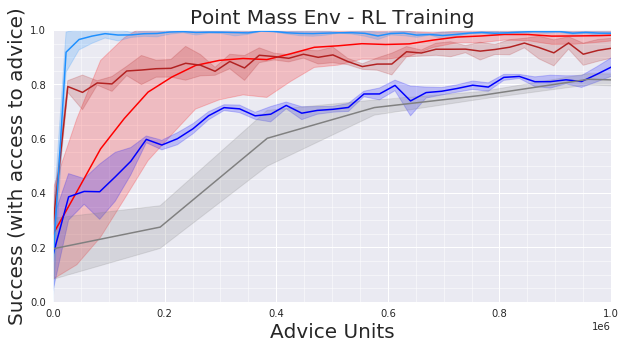

lengths [2244773, 2319484, 2093523]
lengths [1331644, 1317723, 1335092]
lengths [1388944, 1462037, 1442764]
lengths [1171088, 1193846, 1194451]
lengths [9760000, 9600000, 9520000]


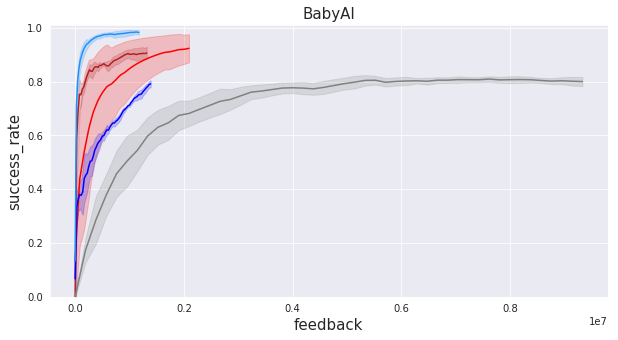

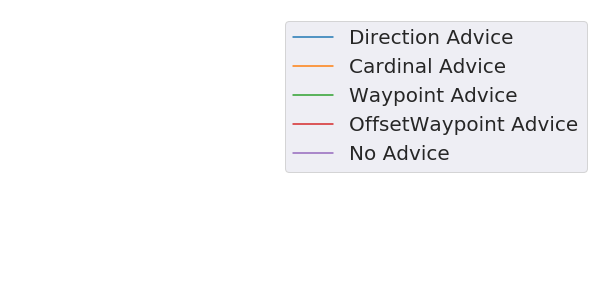

In [36]:
x_unit = 'feedback'

data_names = [
        (['R0000', 'R0001', 'R0002'], 'Direction Advice', 1, 'red', None),
        (['R0003', 'R0004', 'R0005'], 'Cardinal Advice', 1, 'firebrick', None),
        (['R0006', 'R0007', 'R0008'], 'Waypoint Advice', 1, 'blue', None),
        (['R0009', 'R0010', 'R0011'], 'OffsetWaypoint Advice', 1, 'dodgerblue', None),
        (['R0012', 'R0013', 'R0014'], 'No Advice', 1, 'gray', None),
    ]

metrics = ['Train/Success']
plot_curriculum(data_names, x_unit, 
                y=metrics, 
                smooth=20, error_bars=True, 
                title="Point Mass Env - RL Training",
               y_lower=0, y_upper=1, y_label="Success (with access to advice)",
               save_name=None, x_max=1e6)


metric = 'success_rate'
plot_finetune_generalization(data_names, 'BabyAI', metric=metric, smooth=smooth, 
                             x_label=x_unit)

### PM 0-shot

In [ ]:
runs = [
    (['R0018', 'R0019', 'R0020'], 'Direction'),
    (['R0021', 'R0022', 'R0023'], 'Cardinal'),
    (['R0042', 'R0043', 'R0044'], 'Cardinal ++'),
#     (['R0024', 'R0025', 'R0026'], 'Waypoint'),
#     (['R0036', 'R0037', 'R0038'], 'Waypoint ++'),  # TODO
    (['R0027', 'R0028', 'R0029'], 'Offset'),  # TODO: run these
    (['R0030', 'R0031', 'R0032'], 'None'),
]
plt.rcParams['figure.figsize'] = [15, 5]
plot_final_generalization(runs, '0-shot PM with Hints')

### BabyAI Training Curves

RUN NAMES ['R0141', 'R0142', 'R0143']
LENGTHS [5631, 4360, 3520]
RUN NAMES ['R0144', 'R0145', 'R0146']
LENGTHS [2459, 5922, 5947]
RUN NAMES ['R0147', 'R0148', 'R0149']
LENGTHS [17397, 17090, 17016]
RUN NAMES ['R0402', 'R0403', 'R0404']
LENGTHS [10100, 10100, 10100]


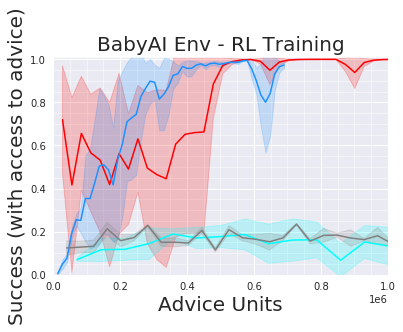

In [16]:
x_unit = 'feedback'
smooth = 100

data_names = [
        (['R0141', 'R0142', 'R0143'], 'PreAction Advice', 1, 'red', None),
        (['R0144', 'R0145', 'R0146'], 'Offset Advice', 1, 'dodgerblue', None),
        (['R0147', 'R0148', 'R0149'], 'Subgoal Advice', 1, 'cyan', None),
#         (['R0150', 'R0151', 'R0152'], 'No Advice', 'purple', None),
        (['R0402', 'R0403', 'R0404'], 'No Advice', 1, 'gray', None),
    
    ]

metrics = ['Train/Success']
plot_curriculum(data_names, x_unit, 
                y=metrics, 
                smooth=smooth, error_bars=True, 
                title="BabyAI Env - RL Training",
               y_lower=0, y_upper=1.01, y_label="Success (with access to advice)",
               save_name=None, x_max=1e6)

# metrics = ['Train/Accuracy']
# plot_curriculum(data_names, x_unit, 
#                 y=metrics, 
#                 smooth=smooth, error_bars=True, 
#                 title="BabyAI Env - RL Training",
#                y_lower=0, y_upper=1.01, y_label="Accuracy",
#                save_name=None)

# metric = 'success_rate'
# plot_finetune_generalization(data_names, 'BabyAI', metric=metric, smooth=smooth, 
#                              x_label=x_unit)
# plot_finetune_generalization(data_names, 'BabyAI', metric='stoch_accuracy', 
#                              smooth=smooth, x_label=x_unit)

### BabyAI 0-shot

In [ ]:
runs = [
#     (['R0156', 'R0157', 'R0158'], 'PA'),
#     (['R0206'], 'PA finetuned'), # looks good!
#     (['R0159', 'R0160', 'R0161'], 'OSR'),
#     (['R0162', 'R0163', 'R0164'], 'Sub'),
#     (['R0180', 'R0181', 'R0182'], 'OSR bootstrap'),
#     (['R0207', 'R0208', 'R0209'], 'OSR Finetuned'),
#     (['R0183', 'R0184', 'R0185'], 'Sub bootstrap'),
    (['R0210', 'R0211', 'R0212'], 'Sub finetuned'),
    (['R0213', 'R0214', 'R0215'], 'Sub finetuned'),
    (['R0216', 'R0217', 'R0218'], 'Sub finetuned'),
    (['R0219', 'R0220', 'R0221'], 'Sub finetuned'),
#     (['R0186', 'R0187'], 'Sub++ bootstrap'), # not used
]
plt.rcParams['figure.figsize'] = [15, 5]
plot_final_generalization(runs, '0-shot Babyai with Hints')
plot_final_generalization(runs, '0-shot Babyai with Hints', metric='stoch_accuracy')

### Ant Training

RUN NAMES ['R0384', 'R0385', 'R0386']
LENGTHS [2216, 1297, 1267]
RUN NAMES ['R0303', 'R0304', 'R0305']
LENGTHS [2849, 2519, 2504]
RUN NAMES ['R0306', 'R0307', 'R0308']
LENGTHS [2440, 2412, 2439]
RUN NAMES ['R0387', 'R0388', 'R0389']
LENGTHS [3044, 3137, 3060]
RUN NAMES ['R0312', 'R0313', 'R0314']
LENGTHS [6362, 6282, 6325]


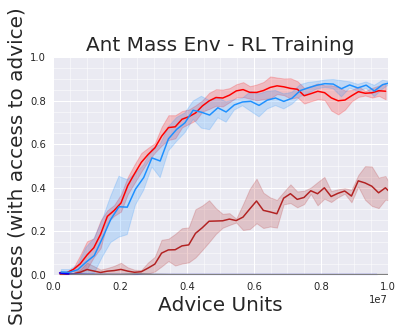

In [18]:
# x_unit = 'feedback'
smooth = 200


data_names = [

    
        (['R0384', 'R0385', 'R0386'], 'Direction Advice', 'red', None),
        (['R0303', 'R0304', 'R0305'], 'Cardinal Advice', 'firebrick', None),
        (['R0306', 'R0307', 'R0308'], 'Waypoint Advice', 'blue', None),
        (['R0387', 'R0388', 'R0389'], 'OffsetWaypoint Advice', 'dodgerblue', None),
        (['R0312', 'R0313', 'R0314'], 'No Advice', 'gray', None),
    ]

metrics = ['Train/Success']
plot_curriculum(data_names, x_unit, 
                y=metrics, 
                smooth=smooth, error_bars=True, 
                title="Ant Mass Env - RL Training",
               y_lower=0, y_upper=1, y_label="Success (with access to advice)",
               save_name=None, x_max=1e7)

### Ant Zero-shot

In [ ]:
runs = [
    (['R0372', 'R0373', 'R0374'], 'Direction'),
    (['R0375', 'R0376', 'R0377'], 'Direction BSF'),
#     (['R0021', 'R0022', 'R0023'], 'Cardinal'),
#     (['R0042', 'R0043', 'R0044'], 'Cardinal ++'),
#     (['R0024', 'R0025', 'R0026'], 'Waypoint'),
#     (['R0036', 'R0037', 'R0038'], 'Waypoint ++'),
    (['R0378', 'R0379', 'R0380'], 'Offset'),
    (['R0381', 'R0382', 'R0383'], 'Offset BSF'),
#     (['R0030', 'R0031', 'R0032'], 'None'),
]
plt.rcParams['figure.figsize'] = [15, 5]
plot_final_generalization(runs, '0-shot PM with Hints')

## Bootstrapping

### PM

lengths [1331644, 1317723, 1335092]
lengths [1388944, 1462037, 1442764]
lengths [2218583, 2224806, 2174050]
lengths [906450, 2486030, 2431160]


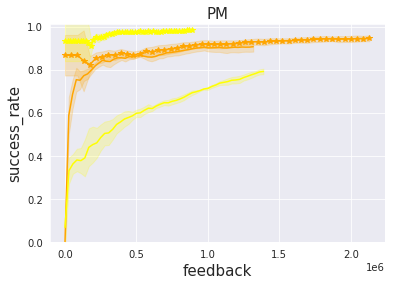

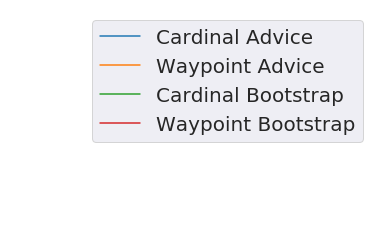

In [20]:
x_unit = 'feedback'

data_names = [
        (['R0003', 'R0004', 'R0005'], 'Cardinal Advice', 1, 'orange', None),
        (['R0006', 'R0007', 'R0008'], 'Waypoint Advice', 1, 'yellow', None),
    
    
        (['R0039', 'R0040', 'R0041'], 'Cardinal Bootstrap', 1, 'orange', '*'),
        (['R0033', 'R0034', 'R0035'], 'Waypoint Bootstrap', 1, 'yellow', '*'),
    ]

metric = 'success_rate'
plot_finetune_generalization(data_names, 'PM', metric=metric, smooth=smooth, x_label=x_unit, y_min=0)

lengths [1331644, 1317723, 1335092]
lengths [2218583, 2224806, 2174050]
lengths [1331644, 1317723, 1335092]


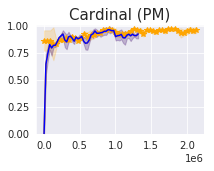

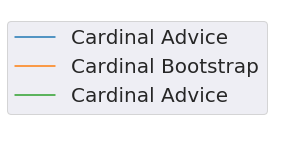

In [39]:
plt.rcParams['figure.figsize'] = [3, 2]
metrics = [
    'Train/Success',
]
x_label = 'Advice Units'

outside_y_label = "Success Rate"
inside_y_label = ""
inside_x_label = ""
outside_x_label = "Advice Units"

# data_names = [
#         (['R0000', 'R0001', 'R0002'], 'Direction Advice', 'red', None),
#         (['R0003', 'R0004', 'R0005'], 'Cardinal Advice', 'firebrick', None),
#         (['R0006', 'R0007', 'R0008'], 'Waypoint Advice', 'blue', None),
#         (['R0009', 'R0010', 'R0011'], 'OffsetWaypoint Advice', 'dodgerblue', None),
#         (['R0012', 'R0013', 'R0014'], 'No Advice', 'gray', None),
#     ]



data_names = [
        (['R0003', 'R0004', 'R0005'], 'Cardinal Advice', 1, 'orange', None),
        (['R0039', 'R0040', 'R0041'], 'Cardinal Bootstrap', 1, 'orange', '*'),
        (['R0003', 'R0004', 'R0005'], 'Cardinal Advice', 1,'blue', None),
    ]

# plot_finetune_generalization(runs, 'Cardinal (PM)', smooth=10, x_label=inside_x_label, 
#                              y_label=inside_y_label, x_max=1000000, 
#                              save_name='bootstrap_cardinal_pm.pdf')

plot_finetune_generalization(data_names, 'Cardinal (PM)', smooth=10, x_label=inside_x_label, 
                             y_label=inside_y_label, 
                             save_name='bootstrap_cardinal_pm.pdf')


# print("=" * 100)


# runs = [
#         (['K006', 'K007', 'K008'], 'RL training'),
#         (['K150', 'K151', 'K152'], 'Distillation', 1, '#ff7f0e', None),
#     ]

# plt.xlim(0, 250000)
# plot_finetune_generalization(runs, 'Waypoint (PM)', smooth=10, x_label=inside_x_label, 
#                              y_label=inside_y_label, x_max=250000, save_name='bootstrap_waypoint_pm.pdf')




# runs = [
#         (['K153', 'K154', 'K155'], 'RL train - Direction Hints'),
#         (['K168', 'K169', 'K170'], 'Off -> Dir', 1, '#ff7f0e', None),
# ]
# plt.xlim(0, 1500000)
# add_line(.92, 'RL Train at convergence (1.25e7)')
# plot_finetune_generalization(runs, 'Direction (Ant)', smooth=10, 
#                              x_label=inside_x_label, y_label=inside_y_label,
#                             y_min=-0.1, save_name='bootstrap_direction_ant.pdf',
#                             x_max=1500000)


# runs = [
#         (['K156', 'K157', 'K158'], 'RL train - Cardinal Hints'),
#         (['K171', 'K172', 'K173'], 'Off -> Cardinal', 1, '#ff7f0e', None),
# ]
# add_line(.84, 'RL Train at convergence (1.2e7)')
# plt.xlim(0, 50000)
# plot_finetune_generalization(runs, 'Cardinal (Ant)', smooth=10, 
#                              x_label=outside_x_label, y_label=outside_y_label,
#                             y_min=-0.1, save_name='bootstrap_cardinal_ant.pdf',
#                             x_max=50000)

# runs = [
#         (['K159', 'K160', 'K161'], 'RL train - Waypoint Hints'),
#         (['K174b', 'K175b', 'K176b'], 'Off -> Waypoint', 1, '#ff7f0e', None),
# ]
# plt.xlim(0, 100000)
# add_line(.02, 'RL Train at convergence (1e7)')
# plot_finetune_generalization(runs, 'Waypoint (Ant)', smooth=10, 
#                              x_label=outside_x_label, y_label=inside_y_label,
#                             y_min=-0.1, save_name='bootstrap_waypoint_ant.pdf',
#                             x_max=100000)



# # runs = [
# #         (['K333_1', 'K334', 'K335'], 'Action Advice', 'orange', 's'),
# #         (['K336', 'K337', 'K338'], 'OffsetWaypoint Advice', 'purple', 'v'),
# #         (['K339', 'K340', 'K341'], 'Subgoal Advice', 'brown', 'P'),



# x_label = 'Advice Units'

# runs = [
#         (['K336', 'K337', 'K338'], 'RL Training'),
#         (['K249b', 'K250b', 'K251b'], 'Distillation', 1, '#ff7f0e', None),
#     ]

# plt.xlim(0, 1000000)
# plot_finetune_generalization(runs, 'OffsetWaypoint (babyai)', smooth=3, x_label=outside_x_label, 
#                              metric='success_rate', y_label=inside_y_label, 
#                              save_name='bootstrap_waypoint_babyai.pdf', x_max=1000000)


# runs = [
#         (['K339', 'K340', 'K341'], 'RL Training'),
#         (['K252c', 'K253c', 'K254c'], 'Bootstrapping', 1, '#ff7f0e', None),
#     ]

# plt.xlim(0, 1000000)
# plot_finetune_generalization(runs, 'Subgoal (babyai)', smooth=3, x_label=outside_x_label, 
#                              metric='success_rate', 
#                              y_label=inside_y_label, save_name='bootstrap_subgoal_babyai.pdf')


# lines = [mlines.Line2D([], [], label='RL Training'),
#          mlines.Line2D([], [], c='orange', label='Distillation')]
# plt.box(False)
# plt.axis('off')
# plt.legend(handles=lines, fontsize=20, ncol=2)
# plt.savefig('figs/bootstrap_legend.pdf', bbox_inches='tight')
# plt.show()


### BabyAI

lengths [684572, 1646809, 1653502]
lengths [3654384, 4454488, 3588666]
lengths [575561, 2593784, 569944]
lengths [6389807, 7115981, 6540700]


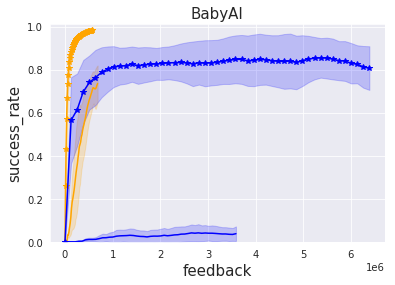

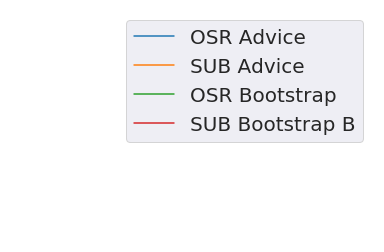

In [21]:
x_unit = 'feedback'

data_names = [
        (['R0144', 'R0145', 'R0146'], 'OSR Advice', 1, 'orange', None),
        (['R0147', 'R0148', 'R0149'], 'SUB Advice', 1, 'blue', None),
    
    
        (['R0171', 'R0172', 'R0173'], 'OSR Bootstrap', 1, 'orange', '*'),
#         (['R0177', 'R0178'], 'SUB Bootstrap A', 1, 'green', '*'),
#         (['R0177', 'R0178', 'R0179'], 'SUB Bootstrap A', 1, 'green', '*'),
        (['R0174', 'R0175', 'R0176'], 'SUB Bootstrap B', 1, 'blue', '*'),
    ]

metric = 'success_rate'
plot_finetune_generalization(data_names, 'BabyAI', metric=metric, smooth=smooth, x_label=x_unit, y_min=0)

lengths [2229892]
lengths [1655903]
lengths [0]


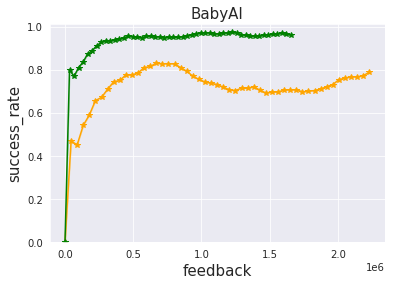

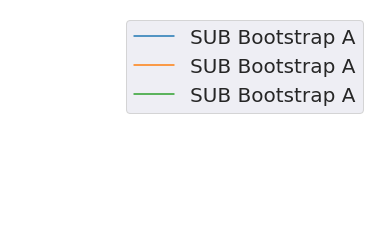

In [22]:
x_unit = 'feedback'

data_names = [
        (['R0177'], 'SUB Bootstrap A', 1, 'orange', '*'),
        (['R0178',], 'SUB Bootstrap A', 1, 'green', '*'),
        (['R0179'], 'SUB Bootstrap A', 1, 'purple', '*'),
    ]

metric = 'success_rate'
plot_finetune_generalization(data_names, 'BabyAI', metric=metric, smooth=smooth, x_label=x_unit, y_min=0)

### Ant

lengths [742597, 480332, 749415]
lengths [684398, 826750, 455304]
lengths [11490803, 10171085, 10134205]
lengths [9704417, 9625051, 9705161]


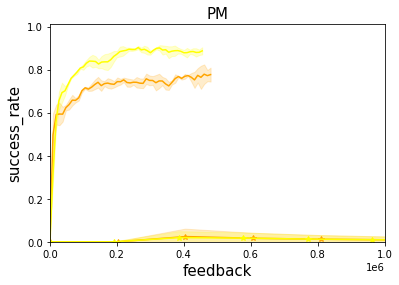

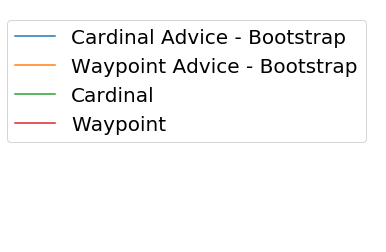

In [11]:
x_unit = 'feedback'
smooth=50

data_names = [
        (['R0315', 'R0316', 'R0317'], 'Cardinal Advice - Bootstrap', 1, 'orange', None),
        (['R0318', 'R0319', 'R0320'], 'Waypoint Advice - Bootstrap', 1, 'yellow', None),
    
    
        (['R0303', 'R0304', 'R0305'], 'Cardinal', 1, 'orange', '*'),
        (['R0306', 'R0307', 'R0308'], 'Waypoint', 1, 'yellow', '*'),
    ]

metric = 'success_rate'
plot_finetune_generalization(data_names, 'PM', metric=metric, smooth=smooth, x_label=x_unit, x_max=1e6)

## Distillation

### PM

lengths [1046854, 1288331, 1077921]
lengths [2500362, 1093927, 1004164]


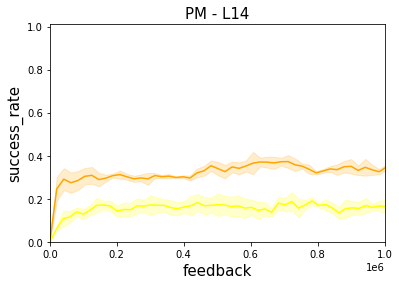

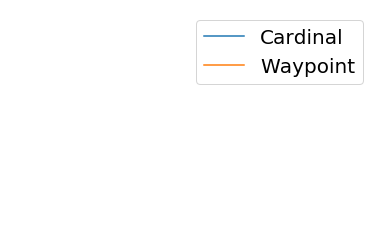

In [5]:
x_unit = 'feedback'
metric = 'success_rate'
smooth=50

# data_names = [
#         (['R0069', 'R0070', 'R0071'], 'Direction', 1, 'red', None),
#         (['R0072', 'R0073', 'R0074'], 'Cardinal', 1, 'orange', None),
#         (['R0075', 'R0076', 'R0077'], 'Waypoint', 1, 'yellow', None), # TODO: check Tues
#         (['R0078', 'R0079', 'R0080'], 'Offset', 1, 'green', None),  # TODO: stop Tues morn
#         (['R0081', 'R0082', 'R0083'], 'RL', 1, 'blue', None),
#         (['R0084', 'R0085', 'R0086'], 'Distill from Oracle', 100 * 20, 'purple', None),
#     ]


# plot_finetune_generalization(data_names, 'PM - L2', metric=metric, smooth=smooth, x_label=x_unit, x_max=3e5)

# data_names = [
#         (['R0087', 'R0088', 'R0089'], 'Direction', 1, 'red', None),
#         (['R0090', 'R0091', 'R0092'], 'Cardinal', 1, 'orange', None),
#         (['R0093', 'R0094', 'R0095'], 'Waypoint', 1, 'yellow', None),
#         (['R0096', 'R0097', 'R0098'], 'Offset', 1, 'green', None),
#         (['R0099', 'R0100', 'R0101'], 'RL', 1, 'blue', None),
#         (['R0102', 'R0103', 'R0104'], 'Distill from Oracle', 100 * 20, 'purple', None),
#     ]

# plot_finetune_generalization(data_names, 'PM - L3', metric=metric, smooth=smooth, x_label=x_unit, x_max=3e5, y_min=-.01)


# data_names = [
#         (['R0105', 'R0106', 'R0107'], 'Direction', 1, 'red', None),
#         (['R0108', 'R0109', 'R0110'], 'Cardinal', 1, 'orange', None),
#         (['R0111', 'R0112', 'R0113'], 'Waypoint', 1, 'yellow', None),
#         (['R0114', 'R0115', 'R0116'], 'Offset', 1, 'green', None),
#         (['R0117', 'R0118', 'R0119'], 'RL', 1, 'blue', None),
#         (['R0120', 'R0121', 'R0122'], 'Distill from Oracle', 100 * 20, 'purple', None),
#     ]

# plot_finetune_generalization(data_names, 'PM - L13', metric=metric, smooth=smooth, x_label=x_unit, x_max=3e5)


data_names = [
#         (['R0123', 'R0124', 'R0125'], 'Direction', 1, 'red', None),
        (['R0126', 'R0127', 'R0128'], 'Cardinal', 1, 'orange', None),
        (['R0129', 'R0130', 'R0131'], 'Waypoint', 1, 'yellow', None),
#         (['R0132', 'R0133', 'R0134'], 'Offset', 1, 'green', None),
#         (['R0135', 'R0136', 'R0137'], 'RL', 1, 'blue', None),
#         (['R0138', 'R0139', 'R0140'], 'Distill from Oracle', 100 * 20, 'purple', None),
    ]

plot_finetune_generalization(data_names, 'PM - L14', metric=metric, smooth=smooth, x_label=x_unit, x_max=1e6)

### BabyAI

lengths [795000, 300000, 300000]
lengths [108632, 104954, 101794]
lengths [146490, 99475, 153259]
lengths [332000, 336000, 228200]
lengths [116000, 116000, 116000]
lengths [1200000, 1200000, 1200000]


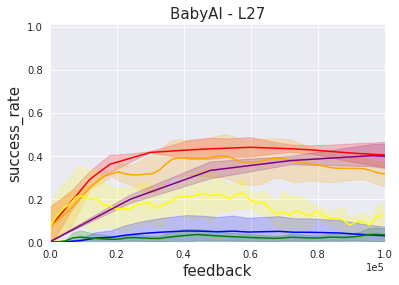

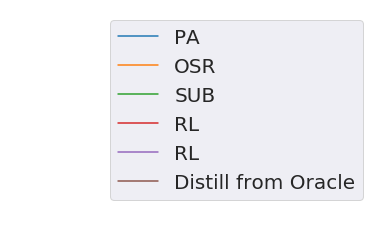

lengths [1620000, 1050000, 1050000]
lengths [347295, 389586, 341951]
lengths [308405, 301550, 320054]
lengths [416000, 416000, 384000]
lengths [172000, 164000, 156000]
lengths [2250000, 2310000, 2250000]


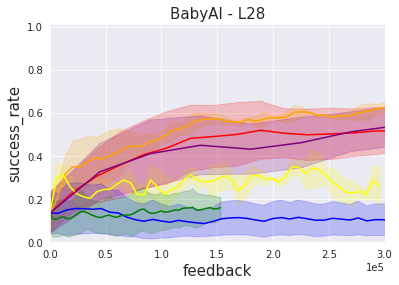

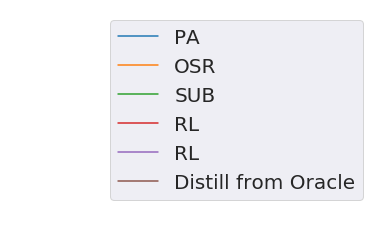

lengths [1455000, 975000, 975000]
lengths [1347230, 1331693, 1322929]
lengths [870899, 3192690, 1317680]
lengths [1484000, 1676200, 1504000]
lengths [152000, 152000, 152000]
lengths [480000, 480000, 495000]


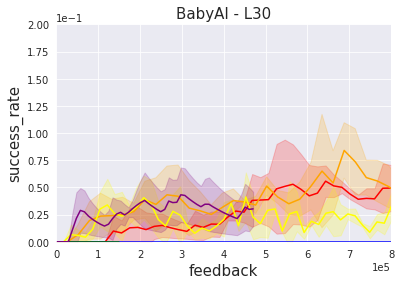

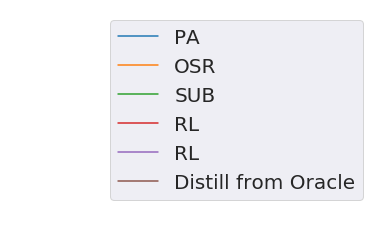

lengths [1455000, 1005000, 1470000]
lengths [660479, 541493, 531239]
lengths [609183, 596795, 627933]
lengths [508000, 520000, 592000]
lengths [148000, 148000, 152000]
lengths [510000, 510000, 510000]


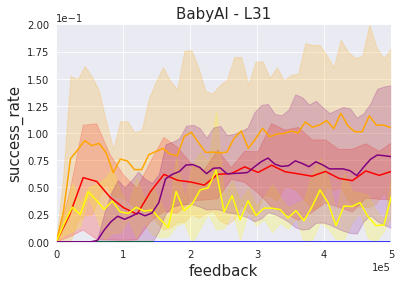

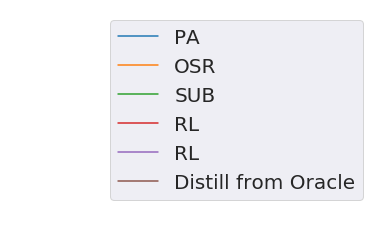

lengths [250, 250, 250]
lengths [545, 539, 537]
lengths [363, 365, 279]
lengths [1000, 1000, 250]
lengths [6850, 6550, 6500]
lengths [200, 200, 200]


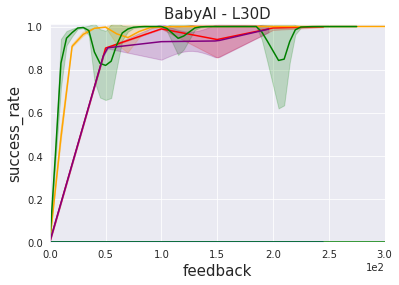

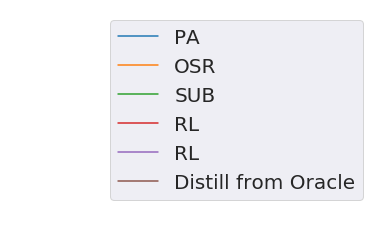

lengths [250, 250, 250]
lengths [545, 539, 537]
lengths [363, 365, 279]
lengths [1000, 1000, 250]
lengths [6850, 6550, 6500]
lengths [200, 200, 200]


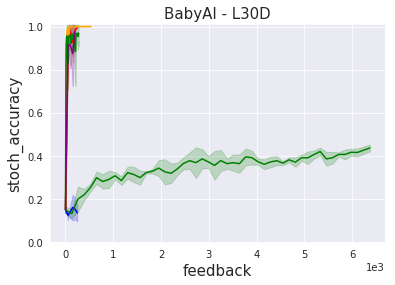

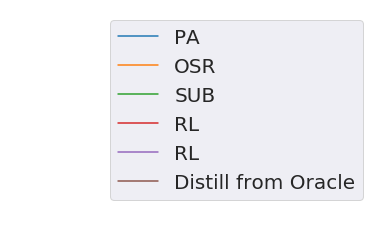

In [92]:
x_unit = 'feedback'
metric = 'success_rate'

data_names = [
        (['R0222', 'R0223', 'R0224'], 'PA', 1, 'red', None),
        (['R0225', 'R0226', 'R0227'], 'OSR', 1, 'orange', None),
        (['R0228', 'R0229', 'R0230'], 'SUB', 1, 'yellow', None),
        (['R0231', 'R0232', 'R0233'], 'RL', 1, 'blue', None),
        (['R0405', 'R0406', 'R0407'], 'RL', 1, 'green', None),
        (['R0234', 'R0235', 'R0236'], 'Distill from Oracle', 150*5, 'purple', None),
    ]


plot_finetune_generalization(data_names, 'BabyAI - L27', metric=metric, smooth=smooth, x_label=x_unit, x_max=1e5)
# plot_finetune_generalization(data_names, 'BabyAI - L27', metric='stoch_accuracy', smooth=smooth, x_label=x_unit, x_max=1e5)

data_names = [
        (['R0237', 'R0238', 'R0239'], 'PA', 1, 'red', None),
        (['R0240', 'R0241', 'R0242'], 'OSR', 1, 'orange', None),
        (['R0243', 'R0244', 'R0245'], 'SUB', 1, 'yellow', None),
        (['R0246', 'R0247', 'R0248'], 'RL', 1, 'blue', None),
        (['R0408', 'R0409', 'R0410'], 'RL', 1, 'green', None),
        (['R0249', 'R0250', 'R0251'], 'Distill from Oracle', 150*5, 'purple', None),
    ]


plot_finetune_generalization(data_names, 'BabyAI - L28', metric=metric, smooth=smooth, x_label=x_unit, x_max=3e5)


data_names = [
        (['R0252', 'R0253', 'R0254'], 'PA', 1, 'red', None),
        (['R0255', 'R0256', 'R0257'], 'OSR', 1, 'orange', None),
        (['R0258', 'R0259', 'R0260'], 'SUB', 1, 'yellow', None),
        (['R0261', 'R0262', 'R0263'], 'RL', 1, 'blue', None),
        (['R0411', 'R0412', 'R0413'], 'RL', 1, 'green', None),
        (['R0264', 'R0265', 'R0266'], 'Distill from Oracle', 150*5, 'purple', None),
    ]


plot_finetune_generalization(data_names, 'BabyAI - L30', metric=metric, smooth=smooth, x_label=x_unit, x_max=8e5, y_max=.2)


data_names = [
        (['R0267', 'R0268', 'R0269'], 'PA', 1, 'red', None),
        (['R0270', 'R0271', 'R0272'], 'OSR', 1, 'orange', None),
        (['R0273', 'R0274', 'R0275'], 'SUB', 1, 'yellow', None),
        (['R0276', 'R0277', 'R0278'], 'RL', 1, 'blue', None),
        (['R0414', 'R0415', 'R0416'], 'RL', 1, 'green', None),
        (['R0279', 'R0280', 'R0281'], 'Distill from Oracle', 150*5, 'purple', None),
    ]


plot_finetune_generalization(data_names, 'BabyAI - L31', metric=metric, smooth=smooth, x_label=x_unit, x_max=5e5, y_max=.2)



data_names = [
        (['R0282', 'R0283', 'R0284'], 'PA', 1, 'red', None),
        (['R0285', 'R0286', 'R0287'], 'OSR', 1, 'orange', None),
        (['R0288', 'R0289', 'R0290'], 'SUB', 1, 'green', None),
        (['R0291', 'R0292', 'R0293'], 'RL', 1, 'blue', None),
        (['R0417', 'R0418', 'R0419'], 'RL', 1, 'green', None),
        (['R0294', 'R0295', 'R0296'], 'Distill from Oracle', 50*1, 'purple', None),
#         (['5840'], 'RL - shaped', 1, 'brown', None),
    ]

ss = 1.25
plot_finetune_generalization(data_names, 'BabyAI - L30D', metric=metric, smooth=ss, 
                             x_label=x_unit, x_max=3e2,)
plot_finetune_generalization(data_names, 'BabyAI - L30D', metric='stoch_accuracy', 
                             smooth=ss, x_label=x_unit)

### Ant

lengths [28720000, 19120000, 29280000]
lengths [690702, 611917, 746034]
lengths [303727, 367439, 377102]


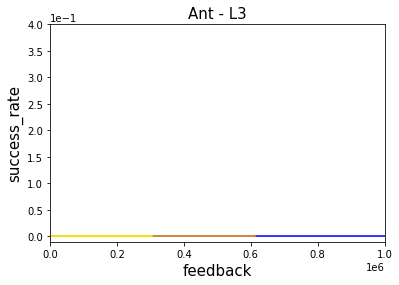

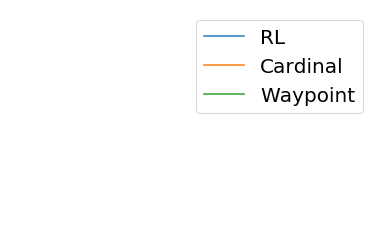

In [9]:
x_unit = 'feedback'
metric = 'success_rate'
smooth=50

# data_names = [
#         (['R0327', 'R0328', 'R0329'], 'Direction', 1, 'red', None),
#         (['R0330', 'R0331', 'R0332'], 'Cardinal', 1, 'orange', None),
#         (['R0333', 'R0334', 'R0335'], 'Waypoint', 1, 'yellow', None),
#         (['R0336', 'R0337', 'R0338'], 'Offset', 1, 'green', None),
#         (['R0339', 'R0340', 'R0341'], 'RL', 1, 'blue', None),
#     ]


# plot_finetune_generalization(data_names, 'Ant - L0', metric=metric, smooth=smooth, x_label=x_unit, x_max=5e5)


# data_names = [
#         (['R0345', 'R0346', 'R0347'], 'Direction', 1, 'red', None),
#         (['R0348', 'R0349', 'R0350'], 'Cardinal', 1, 'orange', None),
#         (['R0351', 'R0352', 'R0353'], 'Waypoint', 1, 'yellow', None),
#         (['R0354', 'R0355', 'R0356'], 'Offset', 1, 'green', None),
#         (['R0357', 'R0358', 'R0359'], 'RL', 1, 'blue', None),
#     ]


# plot_finetune_generalization(data_names, 'Ant - L2', metric=metric, smooth=smooth, x_label=x_unit, x_max=5e5)


data_names = [
        (['R0375', 'R0376', 'R0377'], 'RL', 1, 'blue', None),
#         (['R0363', 'R0364', 'R0365'], 'Direction', 1, 'red', None),
        (['R0366', 'R0367', 'R0368'], 'Cardinal', 1, 'orange', None),
        (['R0369', 'R0370', 'R0371'], 'Waypoint', 1, 'yellow', None),
#         (['R0372', 'R0373', 'R0374'], 'Offset', 1, 'green', None),
    ]


plot_finetune_generalization(data_names, 'Ant - L3',
                             metric=metric, smooth=smooth, x_label=x_unit,
                            y_min=-.01, y_max=.4, x_max=1e6)


## Hparam Sweep/Misc

In [ ]:
x_unit = 'feedback'
smooth = 20

data_names = [
#         (['5777'], 'D5 FPP200', 1, 'red', None),
#         (['5778'], 'D15 FPP200', 1, 'orange', None),
#         (['5779'], 'D25 FPP200', 1, 'yellow', None), # BSF?
        (['5780'], 'D100 FPP200', 1, 'green', None), # BSF?
    
#         (['5781'], 'D5 FPP100', 1, 'red', None),
#         (['5782'], 'D15 FPP100', 1, 'orange', '*'),
#         (['5783'], 'D25 FPP100', 1, 'yellow', None),
        (['5784'], 'D100 FPP100', 1, 'green', '*'), # BSF? x2!!
    
    
#         (['5785'], 'D5 FPP50', 1, 'red', 'x'),
#         (['5786'], 'D15 FPP50', 1, 'orange', 'x'), # BSF
#         (['5787'], 'D25 FPP50', 1, 'yellow', 'x'), # none
        (['5788'], 'D100 FPP50', 1, 'green', 'x'), # none
    
    
    ]


metric = 'success_rate'
plot_finetune_generalization(data_names, 'BabyAI', metric=metric, smooth=smooth, x_label=x_unit, x_max=1e6)
# plot_finetune_generalization(data_names, 'BabyAI', metric='stoch_accuracy', smooth=smooth, x_label=x_unit)

In [ ]:
x_unit = 'feedback'
smooth = 20

data_names = [
#         (['5794'], 'D5 FPP40', 1, 'red', None), 
#         (['5795'], 'D15 FPP40', 1, 'orange', None),
#         (['5796'], 'D50 FPP40', 1, 'green', None), # BSF
#         (['5797'], 'D100 FPP40', 1, 'blue', None), # BSF
    
    
#         (['5798'], 'D5 FPP150', 1, 'red', '*'),
#         (['5799'], 'D15 FPP150', 1, 'orange', '*'),
#         (['5800'], 'D50 FPP150', 1, 'green', '*'),
#         (['5801'], 'D100 FPP150', 1, 'blue', '*'), # BSF
    
    
    
        (['5810'], 'D5 FPP150', 1, 'red', '*'),
        (['5809'], 'D100 FPP40', 1, 'blue', None), # BSF
    
    
    ]


metric = 'success_rate'
plot_finetune_generalization(data_names, 'BabyAI', metric=metric, smooth=smooth, x_label=x_unit)
plot_finetune_generalization(data_names, 'BabyAI', metric='stoch_accuracy', smooth=smooth, x_label=x_unit)



metrics = ['Distill/Accuracy_Val']
plot_curriculum(data_names, x_unit, 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="BabyAI",
               y_lower=0.2, y_upper=.9, y_label="Acc",
               save_name=None)


metrics = ['Distill/Loss_Val']
plot_curriculum(data_names, x_unit, 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="BabyAI",
                y_label="Loss",
               save_name=None)

metrics = ['Distill/Entropy_Val']
plot_curriculum(data_names, x_unit, 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="BabyAI",
                y_label="Entropy",
               save_name=None)

In [ ]:
metric='success_rate'
x_unit='Itrs'

data_names = [
        (['R0222'], 'Online', 1, 'red', None),
        (['TT5820'], 'Full', 1, 'blue', None),
    ]


plot_finetune_generalization(data_names, 'BabyAI - L27', metric=metric, smooth=smooth, x_label=x_unit)
plot_finetune_generalization(data_names, 'BabyAI - L27', metric='stoch_accuracy', smooth=smooth, x_label=x_unit)


In [ ]:
metric='success_rate'
x_unit='Itrs'
smooth=10

# data_names = [
# #         # PM - Direction - conclusion: together is smoother, but converge to about the same place.
# #         (['R0000'], 'Sep', 1, 'red', None),
# #         (['T5818'], 'Together', 1, 'blue', None),
    
#         # PM - Waypoint
#         (['R0007'], 'Sep', 1, 'red', None), # About the same so far.
#         (['T5819'], 'Together', 1, 'blue', None),
#     ]


# plot_finetune_generalization(data_names, 'PM', metric=metric, smooth=smooth, x_label=x_unit)


# data_names = [
# #         # babyai - PA - together is smoother, but same convergence
# #         (['R0141'], 'Sep', 1, 'red', None), # About the same so far.
# #         (['T5816'], 'Together', 1, 'blue', None),
    
    
#         # babyai - OSR - about the same
#         (['R0145'], 'Sep', 1, 'red', None), # About the same so far.
#         (['T5817'], 'Together', 1, 'blue', None),
#     ]


# plot_finetune_generalization(data_names, 'BabyAI', metric=metric, smooth=smooth, x_label=x_unit)
# plot_finetune_generalization(data_names, 'BabyAI', metric='stoch_accuracy', smooth=smooth, x_label=x_unit)



data_names = [
        # babyai - PA - together is smoother, but same convergence
        (['T5813', 'T5815'], 'Sep', 1, 'red', None), # About the same so far.
        (['T5812', 'T5814'], 'Together', 1, 'blue', None),
    ]


plot_finetune_generalization(data_names, 'BabyAI', metric=metric, smooth=smooth, x_label=x_unit)


In [ ]:
data_names = [
        (['R0090'], 'reloaded', 1, 'orange', None),
        (['r0090'], 'old', 1, 'black', None),
    ]

plot_finetune_generalization(data_names, 'Debugging reloading', metric=metric, smooth=smooth, x_label=x_unit, x_max=1e6)


ENV DICT dict_keys([0, 2, 3, 6])


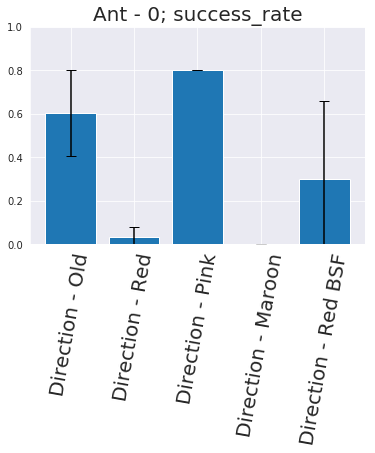

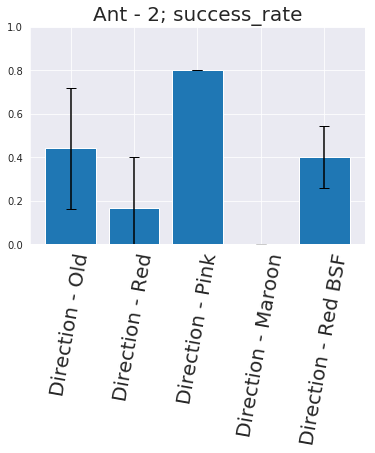

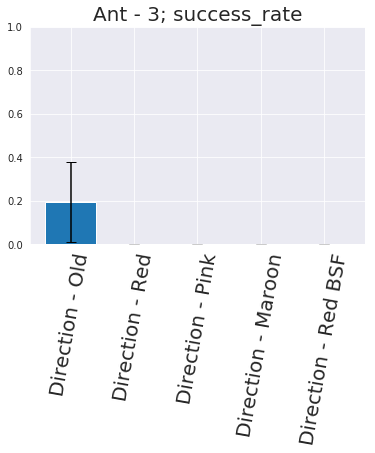

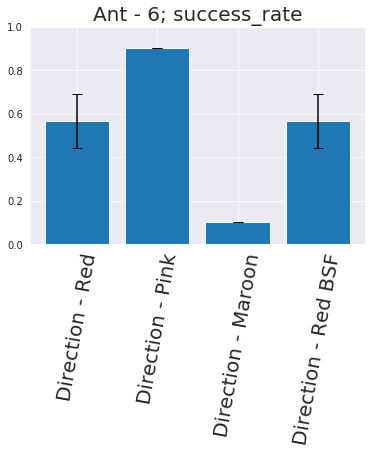

In [53]:
# Sweep over 0-shot ants

runs = [
    # OLD
    (['K192', 'K193', 'K194'], 'Direction - Old'),
#     (['K195', 'K196', 'K197'], 'Cardinal'),
#     (['K198', 'K199', 'K200'], 'Waypoint'),
#     (['K201', 'K202', 'K203'], 'OffsetWaypoint'),
#     (['K204', 'K205', 'K206'], 'No hints'),
    
    # NEW
    (['T5826', 'T5827', 'T5828'], 'Direction - Red'),
    (['T5829'], 'Direction - Pink'),
    (['T5830'], 'Direction - Maroon'),
    (['T5831', 'T5832', 'T5833'], 'Direction - Red BSF'),
#     (['T5831',], 'Direction - Red BSF'),
#     ([ 'T5832',], 'Direction - Red BSF'),
#     ([ 'T5833'], 'Direction - Red BSF'),
    
]
plot_final_generalization(runs, 'Ant')

lengths [2000]
lengths [400]
lengths [200]


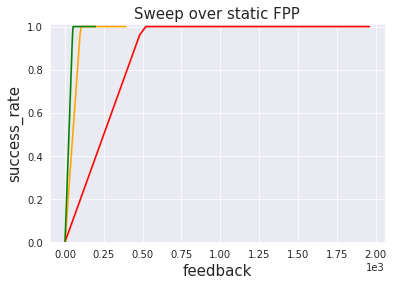

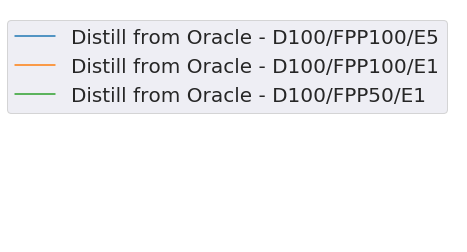

In [65]:

data_names = [
        (['TT5837'], 'Distill from Oracle - D100/FPP100/E5', 100 * 5, 'red', None),
        (['TT5838'], 'Distill from Oracle - D100/FPP100/E1', 100 * 1, 'orange', None),
        (['TT5839'], 'Distill from Oracle - D100/FPP50/E1', 50 * 1, 'green', None),
    ]


plot_finetune_generalization(data_names, 'Sweep over static FPP', metric=metric, smooth=1, x_label=x_unit)

lengths [580]
lengths [760]
lengths [1360]
lengths [1800]


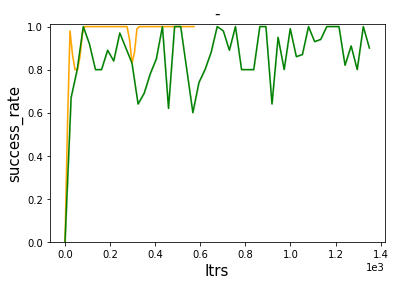

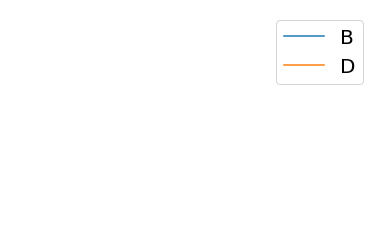

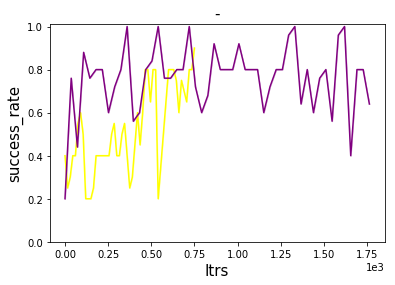

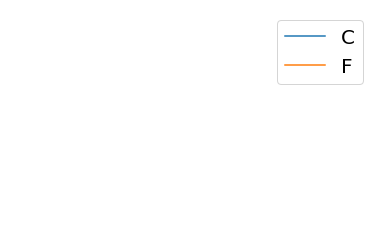

In [61]:

data_names = [
        (['TT5894'], 'B', 1, 'orange', None),  # good!
        (['TT5895'], 'C', 1, 'yellow', None),  # medium
        (['TT5885'], 'D', 1, 'green', None),  # OK
#         (['TT5886'], 'E', 1, 'blue', None),  # OK
        (['TT5887'], 'F', 1, 'purple', None),  # OK
    ]
x_unit = 'Itrs'
metric='success_rate'

plot_finetune_generalization(data_names, '-', metric=metric, smooth=1, x_label=x_unit, 
                            new_logging=True)




# data_names = [
#         (['TT5896'], 'G', 1, 'red', None), # BAD
#         (['TT5897'], 'H', 1, 'orange', None), # Runs, success goes down from .4 to 0
#         (['TT5890'], 'I', 1, 'green', None),  # OK
# #         (['TT5891'], 'J', 1, 'green', None),
#         (['TT5892'], 'J', 1, 'purple', None),  # OK
#     ]
# x_unit = 'Itrs'
# metric='success_rate'

# plot_finetune_generalization(data_names, '-', metric=metric, smooth=5, x_label=x_unit, 
#                             new_logging=False)

In [62]:

# data_names = [
#         (['T5886'], 'A', 1, 'red', None),
#     ]
# x_unit = 'Itrs'
# metric='success_rate'

# plot_finetune_generalization(data_names, '-', metric=metric, smooth=1, x_label=x_unit, 
#                             new_logging=True)



# data_names = [
#         (['R0237'], 'A', 1, 'red', None),
#     ]
# x_unit = 'Itrs'
# metric='success_rate'

# plot_finetune_generalization(data_names, '-', metric=metric, smooth=1, x_label=x_unit, 
#                             new_logging=False)


In [63]:

# data_names = [
#         (['TT5619'], 'Michael', 1, 'red', None),
#         (['TT5620'], 'Ale', 1, 'orange', None),
#         (['T5400'], 'O1', 1, 'yellow', None),
#         (['T5362'], 'O2', 1, 'green', None),
#         (['T4478'], 'O3', 1, 'blue', None),
#         (['T4437'], 'O4', 1, 'purple', None),
#     ]
# x_unit = 'Itrs'
# metric='success_rate'

# plot_finetune_generalization(data_names, '-', metric=metric, smooth=1, x_label=x_unit, 
#                             new_logging=False, x_max=1000)


lengths [1460]
lengths [340]
lengths [320]


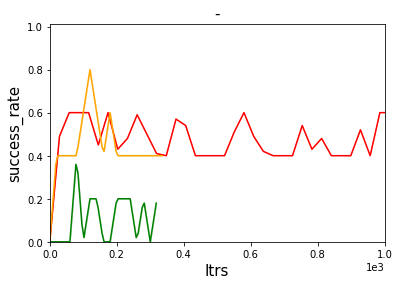

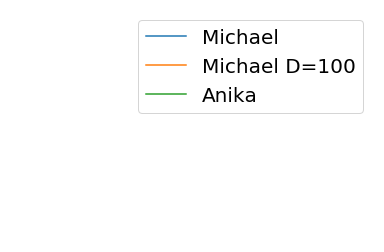

In [64]:

data_names = [
        (['TT5898'], 'Michael', 1, 'red', None),
        (['TT5899'], 'Michael D=100', 1, 'orange', None),
        (['TT5900'], 'Anika', 1, 'green', None),
    ]
x_unit = 'Itrs'
metric='success_rate'

plot_finetune_generalization(data_names, '-', metric=metric, smooth=1, x_label=x_unit, 
                            new_logging=True, x_max=1000)


lengths [1360]
lengths [720]
lengths [160]


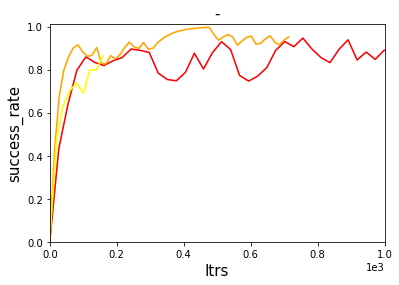

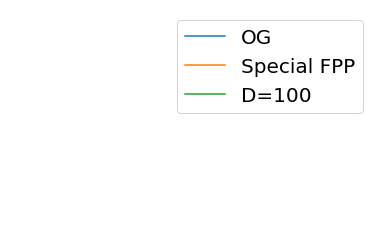

In [66]:

data_names = [
        (['TT5885'], 'OG', 1, 'red', None),
        (['TT5901'], 'Special FPP', 1, 'orange', None),
        (['TT5902'], 'D=100', 1, 'yellow', None),
    ]
x_unit = 'Itrs'
metric='success_rate'

plot_finetune_generalization(data_names, '-', metric=metric, smooth=5, x_label=x_unit, 
                            new_logging=True, x_max=1000)
